# Data Merging & Preparation

In [ ]:
import pandas as pd
import numpy as np
import ast

### Posts, Reactions, About, and Comments numerical features

In [ ]:
test_data_numerical_features = pd.read_csv(r"/content/drive/MyDrive/Master Thesis/Final_Data/test_data_numerical_features.csv")
train_data_numerical_features = pd.read_csv(r"/content/drive/MyDrive/Master Thesis/Final_Data/train_data_numerical_features.csv")

In [ ]:
test_data_numerical_features.head(1)


,Unnamed: 0,Organization Name,username,about,followers,posts,comments,reactions,experience,education,...,reposts_number_posts,post_times,cleaned_comments,num_comments,comment_days_ago,account_name,engagements_comments,cleaned_reactions,reaction_types,reaction_times
0,17116,SKU IQ,joseph-chen-cmrp-691bb510,Joseph has 18 years of experience working on t...,5306,"['Feed post number 1\nJoseph Chen, CMRP\nJosep...","[""Feed post number 1\nJoseph Chen, CMRP commen...","['Feed post number 1\nJoseph Chen, CMRP likes ...","[{'title': 'Founder & CEO', 'company_name': 'L...","[{'degree': '', 'institution': 'Certified Mark...",...,"[0, 1, 0, 1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 2, 0, 0]","[60, 90, 120, 120, 150, 150, 270, 270, 365, 36...","['Congratulations!!!!👏', 'Catherine Chen “CC” ...",7,"[5, 5, 7, 14, 14, 14, 28]","Joseph Chen, CMRP","[130, 36, 48, 260, 88, 54, 184]",['👏🏼 I’d like to give a big shoot out to the e...,"['likes this', 'likes this', 'likes this', 'li...","[1, 1, 7, 3, 7, 6, 7, 4, 5]"


In [ ]:
test_data_numerical_features.columns

Index(['Unnamed: 0', 'Organization Name', 'username', 'about', 'followers',
       'posts', 'comments', 'reactions', 'experience', 'education',
       'Founded Date', 'equity_raised_in_5_years', 'Success_after_5_years',
       'equity_rounds_raised_after_5_years', 'Equity_raised_until_now',
       'Success_until_now', 'cleaned_posts', 'num_posts', 'num_reposted_posts',
       'engagements_posts', 'comments_on_posts', 'reposts_number_posts',
       'post_times', 'cleaned_comments', 'num_comments', 'comment_days_ago',
       'account_name', 'engagements_comments', 'cleaned_reactions',
       'reaction_types', 'reaction_times'],
      dtype='object')

In [ ]:
# 1. Drop 'Unnamed' and specified columns
columns_to_drop = [
    'Unnamed: 0', 'about', 'posts', 'comments', 'reactions',
    'experience', 'education', 'Founded Date', 'cleaned_posts', 'cleaned_comments',
    'cleaned_reactions', 'account_name'
]
test_data_numerical_features = test_data_numerical_features.drop(columns=columns_to_drop)

# Function to safely convert strings to lists
def safe_literal_eval(val):
    if isinstance(val, str):
        try:
            # Attempt to evaluate the string
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            # Return None if evaluation fails
            return None
    return val

# Apply the function to the relevant columns
columns_to_process = [
    'engagements_posts', 'comments_on_posts', 'reposts_number_posts',
    'engagements_comments', 'post_times', 'comment_days_ago', 'reaction_times'
]

for column in columns_to_process:
    test_data_numerical_features[column] = test_data_numerical_features[column].apply(safe_literal_eval)

# Function to handle lists and clean None values
def safe_max(lst):
    if isinstance(lst, list):
        lst = [x for x in lst if x is not None]  # Remove None values
        return max(lst) if lst else None  # Return max if list is not empty
    return None

def safe_mean(lst):
    if isinstance(lst, list):
        lst = [x for x in lst if x is not None]  # Remove None values
        return sum(lst) / len(lst) if lst else None  # Return mean if list is not empty
    return None

# Compute max and mean for the processed columns
for column in ['engagements_posts', 'comments_on_posts', 'reposts_number_posts', 'engagements_comments']:
    test_data_numerical_features[f'{column}_max'] = test_data_numerical_features[column].apply(safe_max)
    test_data_numerical_features[f'{column}_mean'] = test_data_numerical_features[column].apply(safe_mean)
# Drop the original columns
test_data_numerical_features = test_data_numerical_features.drop(columns=['engagements_posts', 'comments_on_posts', 'reposts_number_posts', 'engagements_comments'])

# Compute max and mean for the time-related columns
for column in ['post_times', 'comment_days_ago', 'reaction_times']:
    test_data_numerical_features[f'{column}_max'] = test_data_numerical_features[column].apply(safe_max)
    test_data_numerical_features[f'{column}_mean'] = test_data_numerical_features[column].apply(safe_mean)
# Drop the original time-related columns
test_data_numerical_features = test_data_numerical_features.drop(columns=['post_times', 'comment_days_ago', 'reaction_times'])

# 2. Process reaction_types column
def process_reaction_types(val):
    if isinstance(val, str):
        try:
            # Remove the surrounding quotes and evaluate as list
            val = ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return None  # Return None if evaluation fails
    if isinstance(val, list):
        # Remove None or NaN values from the list
        val = [x for x in val if pd.notna(x)]
        return val
    return None

test_data_numerical_features['reaction_types'] = test_data_numerical_features['reaction_types'].apply(process_reaction_types)

# Identify unique reaction types across all rows
unique_reactions = set(
    reaction
    for reactions_list in test_data_numerical_features['reaction_types'].dropna()
    for reaction in reactions_list
)

# Create new columns for each unique reaction type and calculate frequencies
for reaction in unique_reactions:
    test_data_numerical_features[f'reaction_type_{reaction}'] = test_data_numerical_features['reaction_types'].apply(
        lambda x: x.count(reaction) / len(x) if isinstance(x, list) and len(x) > 0 else 0
    )

# Add a column for the count of items in reaction_types
test_data_numerical_features['post_founder_reacted_to_count'] = test_data_numerical_features['reaction_types'].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

# Drop the original reaction_types column
test_data_numerical_features = test_data_numerical_features.drop(columns=['reaction_types'])


In [ ]:
test_data_numerical_features.columns


Index(['Organization Name', 'username', 'followers',
       'equity_raised_in_5_years', 'Success_after_5_years',
       'equity_rounds_raised_after_5_years', 'Equity_raised_until_now',
       'Success_until_now', 'num_posts', 'num_reposted_posts', 'num_comments',
       'engagements_posts_max', 'engagements_posts_mean',
       'comments_on_posts_max', 'comments_on_posts_mean',
       'reposts_number_posts_max', 'reposts_number_posts_mean',
       'engagements_comments_max', 'engagements_comments_mean',
       'post_times_max', 'post_times_mean', 'comment_days_ago_max',
       'comment_days_ago_mean', 'reaction_times_max', 'reaction_times_mean',
       'reaction_type_likes this', 'reaction_type_finds this insightful',
       'reaction_type_supports this', 'post_founder_reacted_to_count'],
      dtype='object')

In [ ]:
# Display the data types as a DataFrame
data_types = pd.DataFrame(test_data_numerical_features.dtypes, columns=['Data Type'])
data_types

,Data Type
Organization Name,object
username,object
followers,int64
equity_raised_in_5_years,object
Success_after_5_years,int64
equity_rounds_raised_after_5_years,object
Equity_raised_until_now,object
Success_until_now,int64
num_posts,int64
num_reposted_posts,int64


### Experience Feautres

In [ ]:
test_experience_education_df= pd.read_csv(r"/content/drive/MyDrive/Master Thesis/Final_Data/test_experience_education_df.csv")
train_experience_education_df = pd.read_csv(r"/content/drive/MyDrive/Master Thesis/Final_Data/train_experience_education_df.csv")


### Text analysis Data: comments, posts, reactions, about

Defining a function, that prints all the columns, even if there are a lot of columns in one list

In [ ]:
def get_all_columns_in_batches(dataframe, batch_size=10):
    """
    Returns all column names of a dataframe concatenated into a single list in batch-wise manner.

    Parameters:
    - dataframe (pd.DataFrame): The input dataframe.
    - batch_size (int): The size of each batch for processing columns.

    Returns:
    - list: A concatenated list of all column names.
    """
    # Get all columns
    columns = dataframe.columns.tolist()

    # Concatenate batches into a single list
    all_columns = []
    for i in range(0, len(columns), batch_size):
        all_columns += columns[i:i + batch_size]

    return all_columns

### Posts

In [ ]:
posts_train_data0 = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data_text_variables/train_posts_data_output.csv")
posts_test_data0 = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data_text_variables/test_posts_data_output.csv")

<ipython-input-11-57db35d7ce93>:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  posts_train_data0 = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data_text_variables/train_posts_data_output.csv")


In [ ]:
# Example usage
all_columns = get_all_columns_in_batches(posts_train_data0, batch_size=10)
print(all_columns)

['Unnamed: 0.1', 'Unnamed: 0', 'username', 'cleaned_posts', 'Success_after_5_years', 'equity_rounds_raised_after_5_years', 'Success_until_now', 'cleaned_text', 'posts_cluster_Kmeans_initial_model', 'posts_grid_optimized_k-means_cluster', 'tokens', 'posts_LDA_assigned_topic', 'cleaned_text1', 'posts_cluster_Bert_Kmeans', 'posts_K-means_Bert_cluster', 'posts_K-means_Bertopic_topic', 'posts_K-means_Bertopic_topic_label', 'posts_vader_sentiment_neg', 'posts_vader_sentiment_neu', 'posts_vader_sentiment_pos', 'posts_vader_sentiment_compound', 'posts_bert_emotion_prediction', 'log_reg_success_TF-IDF_posts', 'log_reg_neutral_TF-IDF_posts', 'log_reg_failure_TF-IDF_posts', 'random_forest_success_TF-IDF_posts', 'random_forest_neutral_TF-IDF_posts', 'random_forest_failure_TF-IDF_posts', 'xgboost_success_TF-IDF_posts', 'xgboost_neutral_TF-IDF_posts', 'xgboost_failure_TF-IDF_posts', 'neural_network_success_TF-IDF_posts', 'neural_network_neutral_TF-IDF_posts', 'neural_network_failure_TF-IDF_posts', '

In [ ]:
# Define the columns to hot encode
hot_encode_columns = [
    'posts_cluster_Kmeans_initial_model', 'posts_grid_optimized_k-means_cluster',
    'posts_LDA_assigned_topic', 'posts_cluster_Bert_Kmeans', 'posts_K-means_Bert_cluster',
    'posts_K-means_Bertopic_topic', 'posts_K-means_Bertopic_topic_label'
]

# Columns to keep as they are
keep_columns = [
    'username', 'posts_vader_sentiment_neg', 'posts_vader_sentiment_neu',
    'posts_vader_sentiment_pos', 'posts_vader_sentiment_compound',
    'posts_bert_emotion_prediction', 'log_reg_success_TF-IDF_posts',
    'log_reg_neutral_TF-IDF_posts', 'log_reg_failure_TF-IDF_posts',
    'random_forest_success_TF-IDF_posts', 'random_forest_neutral_TF-IDF_posts',
    'random_forest_failure_TF-IDF_posts', 'xgboost_success_TF-IDF_posts',
    'xgboost_neutral_TF-IDF_posts', 'xgboost_failure_TF-IDF_posts',
    'neural_network_success_TF-IDF_posts', 'neural_network_neutral_TF-IDF_posts',
    'neural_network_failure_TF-IDF_posts', 'improved_log_reg_success_TF-IDF_posts',
    'improved_log_reg_neutral_TF-IDF_posts', 'improved_log_reg_failure_TF-IDF_posts',
    'improved_random_forest_success_TF-IDF_posts', 'improved_random_forest_neutral_TF-IDF_posts',
    'improved_random_forest_failure_TF-IDF_posts', 'improved_xgboost_success_TF-IDF_posts',
    'improved_xgboost_neutral_TF-IDF_posts', 'improved_xgboost_failure_TF-IDF_posts',
    'log_reg_success_BERT_posts', 'log_reg_neutral_BERT_posts', 'log_reg_failure_BERT_posts',
    'random_forest_success_BERT_posts', 'random_forest_neutral_BERT_posts',
    'random_forest_failure_BERT_posts', 'xgboost_success_BERT_posts', 'xgboost_neutral_BERT_posts',
    'xgboost_failure_BERT_posts', 'neural_network_success_BERT_posts',
    'neural_network_neutral_BERT_posts', 'neural_network_failure_BERT_posts',
    'improved_log_reg_success_BERT_posts', 'improved_log_reg_neutral_BERT_posts',
    'improved_log_reg_failure_BERT_posts', 'improved_random_forest_success_BERT_posts',
    'improved_random_forest_neutral_BERT_posts', 'improved_random_forest_failure_BERT_posts',
    'improved_xgboost_success_BERT_posts', 'improved_xgboost_neutral_BERT_posts',
    'improved_xgboost_failure_BERT_posts', 'improved_neural_network_success_BERT_posts',
    'improved_neural_network_neutral_BERT_posts', 'improved_neural_network_failure_BERT_posts',
    'linear_regression_agreeableness_TF-IDF_posts', 'linear_regression_openness_TF-IDF_posts',
    'linear_regression_conscientiousness_TF-IDF_posts', 'linear_regression_extraversion_TF-IDF_posts',
    'linear_regression_neuroticism_TF-IDF_posts', 'random_forest_agreeableness_TF-IDF_posts',
    'random_forest_openness_TF-IDF_posts', 'random_forest_conscientiousness_TF-IDF_posts',
    'random_forest_extraversion_TF-IDF_posts', 'random_forest_neuroticism_TF-IDF_posts',
    'xgboost_agreeableness_TF-IDF_posts', 'xgboost_openness_TF-IDF_posts',
    'xgboost_conscientiousness_TF-IDF_posts', 'xgboost_extraversion_TF-IDF_posts',
    'xgboost_neuroticism_TF-IDF_posts', 'neural_network_agreeableness_TF-IDF_posts',
    'neural_network_openness_TF-IDF_posts', 'neural_network_conscientiousness_TF-IDF_posts',
    'neural_network_extraversion_TF-IDF_posts', 'neural_network_neuroticism_TF-IDF_posts',
    'linear_regression_agreeableness_BERT_posts', 'linear_regression_openness_BERT_posts',
    'linear_regression_conscientiousness_BERT_posts', 'linear_regression_extraversion_BERT_posts',
    'linear_regression_neuroticism_BERT_posts', 'random_forest_agreeableness_BERT_posts',
    'random_forest_openness_BERT_posts', 'random_forest_conscientiousness_BERT_posts',
    'random_forest_extraversion_BERT_posts', 'random_forest_neuroticism_BERT_posts',
    'xgboost_agreeableness_BERT_posts', 'xgboost_openness_BERT_posts',
    'xgboost_conscientiousness_BERT_posts', 'xgboost_extraversion_BERT_posts',
    'xgboost_neuroticism_BERT_posts', 'neural_network_agreeableness_BERT_posts',
    'neural_network_openness_BERT_posts', 'neural_network_conscientiousness_BERT_posts',
    'neural_network_extraversion_BERT_posts', 'neural_network_neuroticism_BERT_posts'
]

# Columns to drop
drop_columns = [
    'Unnamed: 0.1', 'Unnamed: 0', 'cleaned_posts', 'Success_after_5_years',
    'equity_rounds_raised_after_5_years', 'Success_until_now', 'cleaned_text',
    'cleaned_text1', 'tokens'
]

# Function to process a single DataFrame
def process_dataframe(df):
    # Drop unwanted columns
    df = df.drop(columns=drop_columns)

    # One-hot encode specified columns
    df = pd.get_dummies(df, columns=hot_encode_columns, prefix=hot_encode_columns)

    # Group by 'username' and aggregate
    aggregated_df = df.groupby('username').agg(
        {**{col: 'sum' for col in df.columns if col.startswith(tuple(hot_encode_columns))},  # Sum hot-encoded columns
         **{col: 'mean' for col in keep_columns if col not in ['username']}}  # Average the sentiment columns
    ).reset_index()

    return aggregated_df

# Process train_data and test_data
posts_train_data = process_dataframe(posts_train_data0)
posts_test_data = process_dataframe(posts_test_data0)

#test_data_processed = process_dataframe(test_data)

# Display the processed dataframes
print("posts_train_data:")
print(posts_train_data.head())

print("posts_test_data:")
print(posts_test_data.head())

posts_train_data:
                                            username  \
0  %C3%A1lvaro-rodr%C3%ADguez-calvo-de-mora-57b64482   
1  %D9%85%D8%AD%D9%85%D8%AF-%D9%85%D8%AC%D8%AF%D8...   
2              %E2%9A%A1%EF%B8%8Falex-harris-7652069   
3                  %F0%9F%90%B0-shahar-sorek-83ab299   
4                   %F0%9F%94%B9-chris-scollo-b64388   

   posts_cluster_Kmeans_initial_model_0  posts_cluster_Kmeans_initial_model_1  \
0                                     0                                     0   
1                                     1                                     0   
2                                     0                                     1   
3                                     0                                     0   
4                                     2                                     0   

   posts_cluster_Kmeans_initial_model_2  posts_cluster_Kmeans_initial_model_3  \
0                                     0                                     0

### Posts the founder reacted to

In [ ]:
reactions_train_data0 = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data_text_variables/train_reactions_data_output.csv")
reactions_test_data0 = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data_text_variables/test_reactions_data_output.csv")

In [ ]:
# Example usage
all_columns = get_all_columns_in_batches(reactions_train_data0, batch_size=10)
print(all_columns)

['Unnamed: 0.1', 'Unnamed: 0', 'username', 'cleaned_reactions', 'Success_after_5_years', 'equity_rounds_raised_after_5_years', 'Success_until_now', 'cleaned_text', 'reactions_cluster_Kmeans_initial_model', 'reactions_grid_optimized_k-means_cluster', 'tokens', 'reactions_LDA_assigned_topic', 'cleaned_text1', 'reactions_cluster_Bert_Kmeans', 'reactions_K-means_Bert_cluster', 'reactions_K-means_Bertopic_topic', 'reactions_K-means_Bertopic_topic_label', 'reactions_vader_sentiment_neg', 'reactions_vader_sentiment_neu', 'reactions_vader_sentiment_pos', 'reactions_vader_sentiment_compound', 'reactions_bert_emotion_prediction', 'log_reg_success_TF-IDF_reactions', 'log_reg_neutral_TF-IDF_reactions', 'log_reg_failure_TF-IDF_reactions', 'random_forest_success_TF-IDF_reactions', 'random_forest_neutral_TF-IDF_reactions', 'random_forest_failure_TF-IDF_reactions', 'xgboost_success_TF-IDF_reactions', 'xgboost_neutral_TF-IDF_reactions', 'xgboost_failure_TF-IDF_reactions', 'neural_network_success_TF-IDF

In [ ]:
# Define the columns to hot encode
hot_encode_columns = [
    'reactions_cluster_Kmeans_initial_model', 'reactions_grid_optimized_k-means_cluster',
    'reactions_LDA_assigned_topic', 'reactions_cluster_Bert_Kmeans', 'reactions_K-means_Bert_cluster',
    'reactions_K-means_Bertopic_topic', 'reactions_K-means_Bertopic_topic_label'
]

# Columns to keep as they are
keep_columns = [
    'username',   'reactions_vader_sentiment_neg', 'reactions_vader_sentiment_neu',
    'reactions_vader_sentiment_pos', 'reactions_vader_sentiment_compound', 'reactions_bert_emotion_prediction',
    'log_reg_success_TF-IDF_reactions', 'log_reg_neutral_TF-IDF_reactions', 'log_reg_failure_TF-IDF_reactions',
    'random_forest_success_TF-IDF_reactions', 'random_forest_neutral_TF-IDF_reactions',
    'random_forest_failure_TF-IDF_reactions', 'xgboost_success_TF-IDF_reactions',
    'xgboost_neutral_TF-IDF_reactions', 'xgboost_failure_TF-IDF_reactions',
    'neural_network_success_TF-IDF_reactions', 'neural_network_neutral_TF-IDF_reactions',
    'neural_network_failure_TF-IDF_reactions', 'improved_log_reg_success_TF-IDF_reactions',
    'improved_log_reg_neutral_TF-IDF_reactions', 'improved_log_reg_failure_TF-IDF_reactions',
    'improved_random_forest_success_TF-IDF_reactions', 'improved_random_forest_neutral_TF-IDF_reactions',
    'improved_random_forest_failure_TF-IDF_reactions', 'improved_xgboost_success_TF-IDF_reactions',
    'improved_xgboost_neutral_TF-IDF_reactions', 'improved_xgboost_failure_TF-IDF_reactions',
    'log_reg_success_BERT_reactions', 'log_reg_neutral_BERT_reactions', 'log_reg_failure_BERT_reactions',
    'random_forest_success_BERT_reactions', 'random_forest_neutral_BERT_reactions',
    'random_forest_failure_BERT_reactions', 'xgboost_success_BERT_reactions', 'xgboost_neutral_BERT_reactions',
    'xgboost_failure_BERT_reactions', 'neural_network_success_BERT_reactions', 'neural_network_neutral_BERT_reactions',
    'neural_network_failure_BERT_reactions', 'improved_log_reg_success_BERT_reactions',
    'improved_log_reg_neutral_BERT_reactions', 'improved_log_reg_failure_BERT_reactions',
    'improved_random_forest_success_BERT_reactions', 'improved_random_forest_neutral_BERT_reactions',
    'improved_random_forest_failure_BERT_reactions', 'improved_xgboost_success_BERT_reactions',
    'improved_xgboost_neutral_BERT_reactions', 'improved_xgboost_failure_BERT_reactions',
    'improved_neural_network_success_BERT_reactions', 'improved_neural_network_neutral_BERT_reactions',
    'improved_neural_network_failure_BERT_reactions', 'linear_regression_agreeableness_TF-IDF_reactions',
    'linear_regression_openness_TF-IDF_reactions', 'linear_regression_conscientiousness_TF-IDF_reactions',
    'linear_regression_extraversion_TF-IDF_reactions', 'linear_regression_neuroticism_TF-IDF_reactions',
    'random_forest_agreeableness_TF-IDF_reactions', 'random_forest_openness_TF-IDF_reactions',
    'random_forest_conscientiousness_TF-IDF_reactions', 'random_forest_extraversion_TF-IDF_reactions',
    'random_forest_neuroticism_TF-IDF_reactions', 'xgboost_agreeableness_TF-IDF_reactions',
    'xgboost_openness_TF-IDF_reactions', 'xgboost_conscientiousness_TF-IDF_reactions',
    'xgboost_extraversion_TF-IDF_reactions', 'xgboost_neuroticism_TF-IDF_reactions',
    'neural_network_agreeableness_TF-IDF_reactions', 'neural_network_openness_TF-IDF_reactions',
    'neural_network_conscientiousness_TF-IDF_reactions', 'neural_network_extraversion_TF-IDF_reactions',
    'neural_network_neuroticism_TF-IDF_reactions', 'linear_regression_agreeableness_BERT_reactions',
    'linear_regression_openness_BERT_reactions', 'linear_regression_conscientiousness_BERT_reactions',
    'linear_regression_extraversion_BERT_reactions', 'linear_regression_neuroticism_BERT_reactions',
    'random_forest_agreeableness_BERT_reactions', 'random_forest_openness_BERT_reactions',
    'random_forest_conscientiousness_BERT_reactions', 'random_forest_extraversion_BERT_reactions',
    'random_forest_neuroticism_BERT_reactions', 'xgboost_agreeableness_BERT_reactions',
    'xgboost_openness_BERT_reactions', 'xgboost_conscientiousness_BERT_reactions',
    'xgboost_extraversion_BERT_reactions', 'xgboost_neuroticism_BERT_reactions',
    'neural_network_agreeableness_BERT_reactions', 'neural_network_openness_BERT_reactions',
    'neural_network_conscientiousness_BERT_reactions', 'neural_network_extraversion_BERT_reactions',
    'neural_network_neuroticism_BERT_reactions'
]

# Columns to drop
drop_columns = [
    'Unnamed: 0.1', 'Unnamed: 0', 'cleaned_reactions', 'Success_after_5_years',
     'equity_rounds_raised_after_5_years', 'Success_until_now', 'cleaned_text',
     'tokens', 'cleaned_text1'
]

# Function to process a single DataFrame
def process_dataframe(df):
    # Drop unwanted columns
    df = df.drop(columns=drop_columns)

    # One-hot encode specified columns
    df = pd.get_dummies(df, columns=hot_encode_columns, prefix=hot_encode_columns)

    # Group by 'username' and aggregate
    aggregated_df = df.groupby('username').agg(
        {**{col: 'sum' for col in df.columns if col.startswith(tuple(hot_encode_columns))},  # Sum hot-encoded columns
         **{col: 'mean' for col in keep_columns if col not in ['username']}}  # Average the sentiment columns
    ).reset_index()

    return aggregated_df

# Process train_data and test_data
reactions_train_data = process_dataframe(reactions_train_data0)
reactions_test_data = process_dataframe(reactions_test_data0)

#test_data_processed = process_dataframe(test_data)

# Display the processed dataframes
print("reactions_train_data:")
print(reactions_train_data.head())

print("reactions_test_data:")
print(reactions_test_data.head())

reactions_train_data:
                                            username  \
0  %C3%A1lvaro-rodr%C3%ADguez-calvo-de-mora-57b64482   
1                     %C3%A9tienne-dumoulin-624a9624   
2  %D9%85%D8%AD%D9%85%D8%AF-%D9%85%D8%AC%D8%AF%D8...   
3                      %E6%97%AD-%E9%83%AD-26081915b   
4                   %F0%9F%94%B9-chris-scollo-b64388   

   reactions_cluster_Kmeans_initial_model_0  \
0                                         3   
1                                         2   
2                                         0   
3                                         1   
4                                         3   

   reactions_cluster_Kmeans_initial_model_1  \
0                                         1   
1                                         1   
2                                         0   
3                                         0   
4                                         3   

   reactions_cluster_Kmeans_initial_model_2  \
0                           

 ### LinkedIn profile description

In [ ]:
about_train_data0 = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data_text_variables/train_about_data_output.csv")
about_test_data0 = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data_text_variables/test_about_data_output.csv")

In [ ]:
# Example usage
all_columns = get_all_columns_in_batches(about_train_data0, batch_size=10)
print(all_columns)

['Unnamed: 0.1', 'Unnamed: 0', 'username', 'about', 'Success_after_5_years', 'equity_rounds_raised_after_5_years', 'Success_until_now', 'cleaned_text', 'about_cluster_Kmeans_initial_model', 'about_grid_optimized_k-means_cluster', 'tokens', 'about_LDA_assigned_topic', 'cleaned_text1', 'about_cluster_Bert_Kmeans', 'about_K-means_Bert_cluster', 'about_K-means_Bertopic_topic', 'about_K-means_Bertopic_topic_label', 'about_vader_sentiment_neg', 'about_vader_sentiment_neu', 'about_vader_sentiment_pos', 'about_vader_sentiment_compound', 'about_bert_emotion_prediction', 'log_reg_success_TF-IDF_about', 'log_reg_neutral_TF-IDF_about', 'log_reg_failure_TF-IDF_about', 'random_forest_success_TF-IDF_about', 'random_forest_neutral_TF-IDF_about', 'random_forest_failure_TF-IDF_about', 'xgboost_success_TF-IDF_about', 'xgboost_neutral_TF-IDF_about', 'xgboost_failure_TF-IDF_about', 'neural_network_success_TF-IDF_about', 'neural_network_neutral_TF-IDF_about', 'neural_network_failure_TF-IDF_about', 'improved

In [ ]:
# Define the columns to hot encode
hot_encode_columns = [
    'about_cluster_Kmeans_initial_model', 'about_grid_optimized_k-means_cluster',
    'about_LDA_assigned_topic',  'about_cluster_Bert_Kmeans', 'about_K-means_Bert_cluster',
    'about_K-means_Bertopic_topic', 'about_K-means_Bertopic_topic_label'
]

# Columns to keep as they are
keep_columns = [
    'username', 'about_vader_sentiment_neg', 'about_vader_sentiment_neu',
    'about_vader_sentiment_pos', 'about_vader_sentiment_compound', 'about_bert_emotion_prediction',
    'log_reg_success_TF-IDF_about', 'log_reg_neutral_TF-IDF_about', 'log_reg_failure_TF-IDF_about',
    'random_forest_success_TF-IDF_about', 'random_forest_neutral_TF-IDF_about',
    'random_forest_failure_TF-IDF_about', 'xgboost_success_TF-IDF_about',
    'xgboost_neutral_TF-IDF_about', 'xgboost_failure_TF-IDF_about',
    'neural_network_success_TF-IDF_about', 'neural_network_neutral_TF-IDF_about',
    'neural_network_failure_TF-IDF_about', 'improved_log_reg_success_TF-IDF_about',
    'improved_log_reg_neutral_TF-IDF_about', 'improved_log_reg_failure_TF-IDF_about',
    'improved_random_forest_success_TF-IDF_about', 'improved_random_forest_neutral_TF-IDF_about',
    'improved_random_forest_failure_TF-IDF_about', 'improved_xgboost_success_TF-IDF_about',
    'improved_xgboost_neutral_TF-IDF_about', 'improved_xgboost_failure_TF-IDF_about',
    'log_reg_success_BERT_about', 'log_reg_neutral_BERT_about', 'log_reg_failure_BERT_about',
    'random_forest_success_BERT_about', 'random_forest_neutral_BERT_about',
    'random_forest_failure_BERT_about', 'xgboost_success_BERT_about', 'xgboost_neutral_BERT_about',
    'xgboost_failure_BERT_about', 'neural_network_success_BERT_about', 'neural_network_neutral_BERT_about',
    'neural_network_failure_BERT_about', 'improved_log_reg_success_BERT_about',
    'improved_log_reg_neutral_BERT_about', 'improved_log_reg_failure_BERT_about',
    'improved_random_forest_success_BERT_about', 'improved_random_forest_neutral_BERT_about',
    'improved_random_forest_failure_BERT_about', 'improved_xgboost_success_BERT_about',
    'improved_xgboost_neutral_BERT_about', 'improved_xgboost_failure_BERT_about',
    'improved_neural_network_success_BERT_about', 'improved_neural_network_neutral_BERT_about',
    'improved_neural_network_failure_BERT_about', 'linear_regression_agreeableness_TF-IDF_about',
    'linear_regression_openness_TF-IDF_about', 'linear_regression_conscientiousness_TF-IDF_about',
    'linear_regression_extraversion_TF-IDF_about', 'linear_regression_neuroticism_TF-IDF_about',
    'random_forest_agreeableness_TF-IDF_about', 'random_forest_openness_TF-IDF_about',
    'random_forest_conscientiousness_TF-IDF_about', 'random_forest_extraversion_TF-IDF_about',
    'random_forest_neuroticism_TF-IDF_about', 'xgboost_agreeableness_TF-IDF_about',
    'xgboost_openness_TF-IDF_about', 'xgboost_conscientiousness_TF-IDF_about',
    'xgboost_extraversion_TF-IDF_about', 'xgboost_neuroticism_TF-IDF_about',
    'neural_network_agreeableness_TF-IDF_about', 'neural_network_openness_TF-IDF_about',
    'neural_network_conscientiousness_TF-IDF_about', 'neural_network_extraversion_TF-IDF_about',
    'neural_network_neuroticism_TF-IDF_about', 'linear_regression_agreeableness_BERT_about',
    'linear_regression_openness_BERT_about', 'linear_regression_conscientiousness_BERT_about',
    'linear_regression_extraversion_BERT_about', 'linear_regression_neuroticism_BERT_about',
    'random_forest_agreeableness_BERT_about', 'random_forest_openness_BERT_about',
    'random_forest_conscientiousness_BERT_about', 'random_forest_extraversion_BERT_about',
    'random_forest_neuroticism_BERT_about', 'xgboost_agreeableness_BERT_about', 'xgboost_openness_BERT_about',
    'xgboost_conscientiousness_BERT_about', 'xgboost_extraversion_BERT_about', 'xgboost_neuroticism_BERT_about',
    'neural_network_agreeableness_BERT_about', 'neural_network_openness_BERT_about',
    'neural_network_conscientiousness_BERT_about', 'neural_network_extraversion_BERT_about',
    'neural_network_neuroticism_BERT_about'


]

# Columns to drop
drop_columns = [
    'Unnamed: 0.1', 'Unnamed: 0', 'about', 'Success_after_5_years', 'equity_rounds_raised_after_5_years',
    'Success_until_now', 'cleaned_text', 'tokens', 'cleaned_text1'
]

# Function to process a single DataFrame
def process_dataframe(df):
    # Drop unwanted columns
    df = df.drop(columns=drop_columns)

    # One-hot encode specified columns
    df = pd.get_dummies(df, columns=hot_encode_columns, prefix=hot_encode_columns)

    # Group by 'username' and aggregate
    aggregated_df = df.groupby('username').agg(
        {**{col: 'sum' for col in df.columns if col.startswith(tuple(hot_encode_columns))},  # Sum hot-encoded columns
         **{col: 'mean' for col in keep_columns if col not in ['username']}}  # Average the sentiment columns
    ).reset_index()

    return aggregated_df

# Process train_data and test_data
about_train_data = process_dataframe(about_train_data0)
about_test_data = process_dataframe(about_test_data0)

#test_data_processed = process_dataframe(test_data)

# Display the processed dataframes
print("about_train_data:")
print(about_train_data.head())

print("about_test_data:")
print(about_test_data.head())

about_train_data:
                                username  \
0         %C3%A9tienne-dumoulin-624a9624   
1                             %D0%BCatan   
2  %E2%9A%A1%EF%B8%8Falex-harris-7652069   
3      %F0%9F%90%B0-shahar-sorek-83ab299   
4       %F0%9F%94%B9-chris-scollo-b64388   

   about_cluster_Kmeans_initial_model_0  about_cluster_Kmeans_initial_model_1  \
0                                     0                                     0   
1                                     1                                     0   
2                                     0                                     0   
3                                     0                                     0   
4                                     1                                     0   

   about_cluster_Kmeans_initial_model_2  about_cluster_Kmeans_initial_model_3  \
0                                     1                                     0   
1                                     0                             

### Comments

In [ ]:
comments_train_data0 = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data_text_variables/train_comments_data_output.csv")
comments_test_data0 = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data_text_variables/test_comments_data_output.csv")

<ipython-input-20-45819cea7b51>:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_train_data0 = pd.read_csv("/content/drive/MyDrive/Master Thesis/Data_text_variables/train_comments_data_output.csv")


In [ ]:
# Example usage
all_columns = get_all_columns_in_batches(comments_train_data0, batch_size=10)
print(all_columns)



['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'username', 'cleaned_comments', 'Success_after_5_years', 'equity_rounds_raised_after_5_years', 'Success_until_now', 'cleaned_text', 'comments_cluster_Kmeans_initial_model', 'comments_grid_optimized_k-means_cluster', 'tokens', 'comments_LDA_assigned_topic', 'cleaned_text1', 'comments_cluster_Bert_Kmeans', 'comments_K-means_Bert_cluster', 'comments_K-means_Bertopic_topic', 'comments_K-means_Bertopic_topic_label', 'comments_vader_sentiment_neg', 'comments_vader_sentiment_neu', 'comments_vader_sentiment_pos', 'comments_vader_sentiment_compound', 'comments_bert_emotion_prediction', 'log_reg_success_TF-IDF_comments', 'log_reg_neutral_TF-IDF_comments', 'log_reg_failure_TF-IDF_comments', 'random_forest_success_TF-IDF_comments', 'random_forest_neutral_TF-IDF_comments', 'random_forest_failure_TF-IDF_comments', 'xgboost_success_TF-IDF_comments', 'xgboost_neutral_TF-IDF_comments', 'xgboost_failure_TF-IDF_comments', 'neural_network_success_TF-IDF_comme

In [ ]:
# Define the columns to hot encode
hot_encode_columns = [
    'comments_cluster_Kmeans_initial_model', 'comments_grid_optimized_k-means_cluster',
    'comments_LDA_assigned_topic', 'comments_cluster_Bert_Kmeans',
    'comments_K-means_Bert_cluster', 'comments_K-means_Bertopic_topic',
    'comments_K-means_Bertopic_topic_label'
]

# Columns to keep as they are
keep_columns = [
    'username', 'comments_vader_sentiment_neg', 'comments_vader_sentiment_neu',
    'comments_vader_sentiment_pos', 'comments_vader_sentiment_compound',
    'comments_bert_emotion_prediction', 'log_reg_success_TF-IDF_comments',
    'log_reg_neutral_TF-IDF_comments', 'log_reg_failure_TF-IDF_comments',
    'random_forest_success_TF-IDF_comments', 'random_forest_neutral_TF-IDF_comments',
    'random_forest_failure_TF-IDF_comments', 'xgboost_success_TF-IDF_comments',
    'xgboost_neutral_TF-IDF_comments', 'xgboost_failure_TF-IDF_comments',
    'neural_network_success_TF-IDF_comments', 'neural_network_neutral_TF-IDF_comments',
    'neural_network_failure_TF-IDF_comments', 'improved_log_reg_success_TF-IDF_comments',
    'improved_log_reg_neutral_TF-IDF_comments', 'improved_log_reg_failure_TF-IDF_comments',
    'improved_random_forest_success_TF-IDF_comments', 'improved_random_forest_neutral_TF-IDF_comments',
    'improved_random_forest_failure_TF-IDF_comments', 'improved_xgboost_success_TF-IDF_comments',
    'improved_xgboost_neutral_TF-IDF_comments', 'improved_xgboost_failure_TF-IDF_comments',
    'log_reg_success_BERT_comments', 'log_reg_neutral_BERT_comments',
    'log_reg_failure_BERT_comments', 'random_forest_success_BERT_comments',
    'random_forest_neutral_BERT_comments', 'random_forest_failure_BERT_comments',
    'xgboost_success_BERT_comments', 'xgboost_neutral_BERT_comments',
    'xgboost_failure_BERT_comments', 'neural_network_success_BERT_comments',
    'neural_network_neutral_BERT_comments', 'neural_network_failure_BERT_comments',
    'improved_log_reg_success_BERT_comments', 'improved_log_reg_neutral_BERT_comments',
    'improved_log_reg_failure_BERT_comments', 'improved_random_forest_success_BERT_comments',
    'improved_random_forest_neutral_BERT_comments', 'improved_random_forest_failure_BERT_comments',
    'improved_xgboost_success_BERT_comments', 'improved_xgboost_neutral_BERT_comments',
    'improved_xgboost_failure_BERT_comments', 'improved_neural_network_success_BERT_comments',
    'improved_neural_network_neutral_BERT_comments', 'improved_neural_network_failure_BERT_comments',
    'linear_regression_agreeableness_TF-IDF_comments', 'linear_regression_openness_TF-IDF_comments',
    'linear_regression_conscientiousness_TF-IDF_comments', 'linear_regression_extraversion_TF-IDF_comments',
    'linear_regression_neuroticism_TF-IDF_comments', 'random_forest_agreeableness_TF-IDF_comments',
    'random_forest_openness_TF-IDF_comments', 'random_forest_conscientiousness_TF-IDF_comments',
    'random_forest_extraversion_TF-IDF_comments', 'random_forest_neuroticism_TF-IDF_comments',
    'xgboost_agreeableness_TF-IDF_comments', 'xgboost_openness_TF-IDF_comments',
    'xgboost_conscientiousness_TF-IDF_comments', 'xgboost_extraversion_TF-IDF_comments',
    'xgboost_neuroticism_TF-IDF_comments', 'neural_network_agreeableness_TF-IDF_comments',
    'neural_network_openness_TF-IDF_comments', 'neural_network_conscientiousness_TF-IDF_comments',
    'neural_network_extraversion_TF-IDF_comments', 'neural_network_neuroticism_TF-IDF_comments',
    'linear_regression_agreeableness_BERT_comments', 'linear_regression_openness_BERT_comments',
    'linear_regression_conscientiousness_BERT_comments', 'linear_regression_extraversion_BERT_comments',
    'linear_regression_neuroticism_BERT_comments', 'random_forest_agreeableness_BERT_comments',
    'random_forest_openness_BERT_comments', 'random_forest_conscientiousness_BERT_comments',
    'random_forest_extraversion_BERT_comments', 'random_forest_neuroticism_BERT_comments',
    'xgboost_agreeableness_BERT_comments', 'xgboost_openness_BERT_comments',
    'xgboost_conscientiousness_BERT_comments', 'xgboost_extraversion_BERT_comments',
    'xgboost_neuroticism_BERT_comments', 'neural_network_agreeableness_BERT_comments',
    'neural_network_openness_BERT_comments', 'neural_network_conscientiousness_BERT_comments',
    'neural_network_extraversion_BERT_comments', 'neural_network_neuroticism_BERT_comments'
]

# Columns to drop
drop_columns = [
    'cleaned_comments', 'cleaned_text', 'tokens', 'cleaned_text1',
    'Success_after_5_years', 'equity_rounds_raised_after_5_years', 'Success_until_now'
]

# Function to process a single DataFrame
def process_dataframe(df):
    # Drop unwanted columns
    df = df.drop(columns=drop_columns)

    # One-hot encode specified columns
    df = pd.get_dummies(df, columns=hot_encode_columns, prefix=hot_encode_columns)

    # Group by 'username' and aggregate
    aggregated_df = df.groupby('username').agg(
        {**{col: 'sum' for col in df.columns if col.startswith(tuple(hot_encode_columns))},  # Sum hot-encoded columns
         **{col: 'mean' for col in keep_columns if col not in ['username']}}  # Average the sentiment columns
    ).reset_index()

    return aggregated_df

# Process train_data and test_data
comments_train_data = process_dataframe(comments_train_data0)
comments_test_data = process_dataframe(comments_test_data0)

#test_data_processed = process_dataframe(test_data)

# Display the processed dataframes
print("comments_train_data:")
print(comments_train_data.head())

print("comments_test_data:")
print(comments_test_data.head())

comments_train_data:
                                            username  \
0  %C3%A1lvaro-rodr%C3%ADguez-calvo-de-mora-57b64482   
1                     %C3%A9tienne-dumoulin-624a9624   
2  %D9%85%D8%AD%D9%85%D8%AF-%D9%85%D8%AC%D8%AF%D8...   
3              %E2%9A%A1%EF%B8%8Falex-harris-7652069   
4                  %F0%9F%90%B0-shahar-sorek-83ab299   

   comments_cluster_Kmeans_initial_model_0  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   comments_cluster_Kmeans_initial_model_1  \
0                                        1   
1                                        1   
2                                        2   
3                                        4   
4                                       10   

   comments_cluster_Kmeans_initial_model_2  \
0                                        1

## Merge Train Data

In [ ]:
# Merge train data
train_data = train_data_numerical_features.copy()

# DataFrames to merge for train_data
train_dfs = [
    train_experience_education_df,
    posts_train_data,
    reactions_train_data,
    about_train_data,
    comments_train_data
]

# Perform left joins sequentially
for df in train_dfs:
    # Identify columns to exclude (those already in train_data, except the key 'username')
    columns_to_merge = [col for col in df.columns if col not in train_data.columns or col == 'username']
    # Merge only the non-overlapping columns
    train_data = train_data.merge(df[columns_to_merge], how='left', on='username')

# The final train_data DataFrame will have rows equal to train_data_numerical_features
train_data


,Unnamed: 0,Organization Name,username,about,followers,posts,comments,reactions,experience,education,...,xgboost_agreeableness_BERT_comments,xgboost_openness_BERT_comments,xgboost_conscientiousness_BERT_comments,xgboost_extraversion_BERT_comments,xgboost_neuroticism_BERT_comments,neural_network_agreeableness_BERT_comments,neural_network_openness_BERT_comments,neural_network_conscientiousness_BERT_comments,neural_network_extraversion_BERT_comments,neural_network_neuroticism_BERT_comments
0,1761,Ingenious Audio,johnmcnicolkc,Professionally I have harvested over 20 years ...,6396,"[""Feed post number 1\nJohn McNicol\nJohn McNic...","[""Feed post number 1\nJohn McNicol commented o...",[],"[{'title': 'Founder and Director', 'company_na...","[{'degree': 'Post Graduate Diploma, Accounting...",...,0.079534,0.242611,-0.016128,0.208182,-0.231150,0.088612,0.23287,-0.016049,0.211498,-0.230282
1,2292,AssetBlock LLC,michaelliddell11,I am a CEO/CRO with 25+ years of leadership ex...,4146,['Feed post number 1\nMichael Liddell reposted...,"[""Feed post number 1\nMichael Liddell commente...","[""Feed post number 1\nMichael Liddell likes th...","[{'title': 'Managing Partner', 'company_name':...","[{'degree': 'Bachelor of Science - BS, Electri...",...,0.090695,0.215041,-0.012800,0.214298,-0.220337,0.088612,0.23287,-0.016049,0.211498,-0.230282
2,2292,AssetBlock LLC,michaelliddell11,I am a CEO/CRO with 25+ years of leadership ex...,4146,['Feed post number 1\nMichael Liddell reposted...,"[""Feed post number 1\nMichael Liddell commente...","[""Feed post number 1\nMichael Liddell likes th...","[{'title': 'Managing Partner', 'company_name':...","[{'degree': 'Bachelor of Science - BS, Electri...",...,0.090695,0.215041,-0.012800,0.214298,-0.220337,0.088612,0.23287,-0.016049,0.211498,-0.230282
3,721,Picklebet,marceloeichelberger,Established Data Engineer and Information Tech...,614,[],[],['Feed post number 1\nMarcelo Eichelberger cel...,"[{'title': 'Data Engineer', 'company_name': 'P...","[{'degree': 'Bachelor of Information Sciences,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21018,HackerOne,robinleeuwerke,Seasoned product and technology executive with...,5177,['Feed post number 1\nRobin Leeuwerke\nRobin L...,"[""Feed post number 1\nRobin Leeuwerke replied ...",['Feed post number 1\nRobin Leeuwerke likes th...,[{'title': 'Senior Director of Software Engine...,"[{'degree': 'BSc, Computer Science', 'institut...",...,0.118949,0.241329,-0.003445,0.207468,-0.229836,0.088612,0.23287,-0.016049,0.211498,-0.230282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7989,21236,HackerOne,yogesh-vishnoi-9917051bb,Commited to the space of cybersecurity and com...,1996,"[""Feed post number 1\nYogesh Vishnoi\nYogesh V...",['Feed post number 1\nYogesh Vishnoi commented...,[],"[{'title': 'Penetration Tester', 'company_name...","[{'degree': ""Bachelor's degree, International ...",...,0.101531,0.216075,-0.022169,0.215818,-0.227827,0.088612,0.23287,-0.016049,0.211498,-0.230282
7990,20881,HackerOne,saurabhshinde96,Experienced penetration tester and cyber secur...,3568,['Feed post number 1\nSaurabh Shinde\nSaurabh ...,['Feed post number 1\nSaurabh’s profile photo\...,"[""Feed post number 1\nSaurabh’s profile photo\...",[{'title': 'Penetration Tester / Cyber Securit...,"[{'degree': 'Master of Information Technology,...",...,0.100655,0.233600,-0.015409,0.216642,-0.226469,0.088612,0.23287,-0.016049,0.211498,-0.230282
7991,20543,Modern Health,robertobendana,"I'm Roberto Bendana, an ICF-certified coach on...",4918,"['Feed post number 1\nRoberto Bendana, PCC\nRo...","['Feed post number 1\nRoberto Bendana, PCC com...",[],"[{'title': 'Owner', 'company_name': 'Bendana C...",[{'degree': 'Certification in Executive & Team...,...,0.075407,0.235283,-0.012989,0.211449,-0.232812,0.088612,0.23287,-0.016049,0.211498,-0.230282
7992,18864,Membrion,tracy-bantegui-sweden-93455b48,Results driven leader and technology expert wi...,1073,['Feed post number 1

In [ ]:
"""# Merge train data
train_data = train_data_numerical_features.copy()

# DataFrames to merge for train_data
train_dfs = [
    train_experience_education_df,
    posts_train_data,
    reactions_train_data,
    about_train_data,
    comments_train_data
]

# Perform left joins sequentially
for df in train_dfs:
    train_data = train_data.merge(df, how='left', on='username')

# The final train_data DataFrame will have rows equal to train_data_numerical_features

train_data"""

"# Merge train data\ntrain_data = train_data_numerical_features.copy()\n\n# DataFrames to merge for train_data\ntrain_dfs = [\n    train_experience_education_df,\n    posts_train_data,\n    reactions_train_data,\n    about_train_data,\n    comments_train_data\n]\n\n# Perform left joins sequentially\nfor df in train_dfs:\n    train_data = train_data.merge(df, how='left', on='username')\n\n# The final train_data DataFrame will have rows equal to train_data_numerical_features\n\ntrain_data"

## Merge Test Data

In [ ]:
# Merge test data
test_data = test_data_numerical_features.copy()

# DataFrames to merge for test_data
test_dfs = [
    test_experience_education_df,
    posts_test_data,
    reactions_test_data,
    about_test_data,
    comments_test_data
]

# Perform left joins sequentially
for df in test_dfs:
    # Identify columns to exclude (those already in test_data, except the key 'username')
    columns_to_merge = [col for col in df.columns if col not in test_data.columns or col == 'username']
    # Merge only the non-overlapping columns
    test_data = test_data.merge(df[columns_to_merge], how='left', on='username')

# The final test_data DataFrame will have rows equal to test_data_numerical_features
test_data


,Organization Name,username,followers,equity_raised_in_5_years,Success_after_5_years,equity_rounds_raised_after_5_years,Equity_raised_until_now,Success_until_now,num_posts,num_reposted_posts,...,xgboost_agreeableness_BERT_comments,xgboost_openness_BERT_comments,xgboost_conscientiousness_BERT_comments,xgboost_extraversion_BERT_comments,xgboost_neuroticism_BERT_comments,neural_network_agreeableness_BERT_comments,neural_network_openness_BERT_comments,neural_network_conscientiousness_BERT_comments,neural_network_extraversion_BERT_comments,neural_network_neuroticism_BERT_comments
0,SKU IQ,joseph-chen-cmrp-691bb510,5306,0.0,0,0,0.0,0,16,0,...,0.094999,0.231413,-0.017543,0.207415,-0.232257,0.088612,0.23287,-0.016049,0.211498,-0.230282
1,HackerOne,dylan-lawhon,1061,50000000.0,0,2,0.0,0,13,0,...,0.101554,0.230540,-0.016203,0.203608,-0.236510,0.088612,0.23287,-0.016049,0.211498,-0.230282
2,Storj,victor-i,3621,4800000.0,0,0,0.0,0,0,1,...,0.090773,0.223333,-0.014714,0.205214,-0.218172,0.088612,0.23287,-0.016049,0.211498,-0.230282
3,Nines;https://www.crunchbase.com/organization/...,davidstavens,2478,"$34,500,000",1,3,"$34,500,000",1,10,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Kid U Not;https://www.crunchbase.com/organizat...,melissajamesmorrison,1130,—,-1,—,—,-1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6867,VITL,broussarded,6358,0.0,0,1,0.0,0,15,0,...,0.089623,0.235396,-0.022088,0.200916,-0.232425,0.088612,0.23287,-0.016049,0.211498,-0.230282
6868,FundGuard,amit-pilowsky-2478281,3926,4000000.0,0,1,0.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6869,HackerNoon,vasil-karpitski-29142619,737,1069993.0,0,1,0.0,0,0,1,...,0.142476,0.259365,0.037853,0.206175,-0.229359,0.088612,0.23287,-0.016049,0.211498,-0.230282
6870,Blockworks,steven-wasserman-10084b63,1755,0.0,0,1,0.0,0,14,0,...,0.092400,0.220180,-0.028919,0.218377,-0.227024,0.088612,0.23287,-0.016049,0.211498,-0.230282


In [ ]:
"""# Merge test data
test_data = test_data_numerical_features.copy()

# DataFrames to merge for test_data
test_dfs = [
    test_experience_education_df,
    posts_test_data,
    reactions_test_data,
    about_test_data,
    comments_test_data
]

# Perform left joins sequentially
for df in test_dfs:
    test_data = test_data.merge(df, how='left', on='username')

# The final test_data DataFrame will have rows equal to test_data_numerical_features
test_data"""

"# Merge test data\ntest_data = test_data_numerical_features.copy()\n\n# DataFrames to merge for test_data\ntest_dfs = [\n    test_experience_education_df,\n    posts_test_data,\n    reactions_test_data,\n    about_test_data,\n    comments_test_data\n]\n\n# Perform left joins sequentially\nfor df in test_dfs:\n    test_data = test_data.merge(df, how='left', on='username')\n\n# The final test_data DataFrame will have rows equal to test_data_numerical_features\ntest_data"

In [ ]:
# Example usage
all_columns1 = get_all_columns_in_batches(test_data, batch_size=10)
print(all_columns1)

['Organization Name', 'username', 'followers', 'equity_raised_in_5_years', 'Success_after_5_years', 'equity_rounds_raised_after_5_years', 'Equity_raised_until_now', 'Success_until_now', 'num_posts', 'num_reposted_posts', 'num_comments', 'engagements_posts_max', 'engagements_posts_mean', 'comments_on_posts_max', 'comments_on_posts_mean', 'reposts_number_posts_max', 'reposts_number_posts_mean', 'engagements_comments_max', 'engagements_comments_mean', 'post_times_max', 'post_times_mean', 'comment_days_ago_max', 'comment_days_ago_mean', 'reaction_times_max', 'reaction_times_mean', 'reaction_type_likes this', 'reaction_type_finds this insightful', 'reaction_type_supports this', 'post_founder_reacted_to_count', 'Unnamed: 0', 'experience', 'education', 'company_5_success', 'company_5_failure', 'company_5_amount', 'company_10_success', 'company_10_failure', 'company_10_amount', 'company_20_success', 'company_20_failure', 'company_20_amount', 'university_5_success', 'university_5_failure', 'uni

In [ ]:
train_data[(train_data['about_K-means_Bertopic_topic_3.0']!=0) & (~train_data['about_K-means_Bertopic_topic_3.0'].isna())]['about_K-means_Bertopic_topic_3.0']

,about_K-means_Bertopic_topic_3.0
50,1.0
103,1.0
155,1.0
156,1.0
196,1.0
...,...
7756,1.0
7772,1.0
7792,1.0
7821,1.0


In [ ]:
# Example usage
all_columns2 = get_all_columns_in_batches(train_data, batch_size=10)
print(all_columns2)

['Unnamed: 0', 'Organization Name', 'username', 'about', 'followers', 'posts', 'comments', 'reactions', 'experience', 'education', 'Founded Date', 'equity_raised_in_5_years', 'Success_after_5_years', 'equity_rounds_raised_after_5_years', 'Equity_raised_until_now', 'Success_until_now', 'cleaned_posts', 'num_posts', 'num_reposted_posts', 'engagements_posts', 'comments_on_posts', 'reposts_number_posts', 'post_times', 'cleaned_comments', 'num_comments', 'comment_days_ago', 'account_name', 'engagements_comments', 'cleaned_reactions', 'reaction_types', 'reaction_times', 'company_5_success', 'company_5_failure', 'company_5_amount', 'company_10_success', 'company_10_failure', 'company_10_amount', 'company_20_success', 'company_20_failure', 'company_20_amount', 'university_5_success', 'university_5_failure', 'university_5_amount', 'university_10_success', 'university_10_failure', 'university_10_amount', 'university_20_success', 'university_20_failure', 'university_20_amount', 'worked_in_vc', 'w

In [ ]:
# Find differences
unique_to_all_columns1 = set(all_columns1) - set(all_columns2)
unique_to_all_columns2 = set(all_columns2) - set(all_columns1)

# Combine results
differences = [
    {"item": item, "list": "all_columns1"} for item in unique_to_all_columns1
] + [
    {"item": item, "list": "all_columns2"} for item in unique_to_all_columns2
]

# Display differences
for diff in differences:
    print(f"Item '{diff['item']}' is unique to {diff['list']}.")


Item 'posts_K-means_Bertopic_topic_4' is unique to all_columns1.
Item 'about_K-means_Bertopic_topic_18' is unique to all_columns1.
Item 'reactions_K-means_Bertopic_topic_17' is unique to all_columns1.
Item 'posts_K-means_Bertopic_topic_0' is unique to all_columns1.
Item 'engagements_posts_mean' is unique to all_columns1.
Item 'about_K-means_Bertopic_topic_9' is unique to all_columns1.
Item 'reactions_K-means_Bertopic_topic_3' is unique to all_columns1.
Item 'engagements_comments_mean' is unique to all_columns1.
Item 'post_times_max' is unique to all_columns1.
Item 'about_K-means_Bertopic_topic_8' is unique to all_columns1.
Item 'reaction_type_finds this insightful' is unique to all_columns1.
Item 'posts_K-means_Bertopic_topic_1' is unique to all_columns1.
Item 'comments_K-means_Bertopic_topic_1' is unique to all_columns1.
Item 'posts_K-means_Bertopic_topic_9' is unique to all_columns1.
Item 'posts_K-means_Bertopic_topic_3' is unique to all_columns1.
Item 'about_K-means_Bertopic_topic_1

In [ ]:
# Extract column names
all_columns1 = get_all_columns_in_batches(train_data, batch_size=10)
all_columns2 = get_all_columns_in_batches(test_data, batch_size=10)

# Find differences
unique_to_all_columns1 = set(all_columns1) - set(all_columns2)
unique_to_all_columns2 = set(all_columns2) - set(all_columns1)

# Add columns with NaN values for non-matching columns
for col in unique_to_all_columns2:
    train_data[col] = np.nan  # Add non-matching columns from df2 to df1, filled with NaN

for col in unique_to_all_columns1:
    test_data[col] = np.nan  # Add non-matching columns from df1 to df2, filled with NaN




<ipython-input-31-b73613c19981>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[col] = np.nan  # Add non-matching columns from df1 to df2, filled with NaN
<ipython-input-31-b73613c19981>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[col] = np.nan  # Add non-matching columns from df1 to df2, filled with NaN
<ipython-input-31-b73613c19981>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

In [ ]:
# Example usage
all_columns1 = get_all_columns_in_batches(test_data, batch_size=10)

# Example usage
all_columns2 = get_all_columns_in_batches(train_data, batch_size=10)

In [ ]:
# Find differences
unique_to_all_columns1 = set(all_columns1) - set(all_columns2)
unique_to_all_columns2 = set(all_columns2) - set(all_columns1)

# Combine results
differences = [
    {"item": item, "list": "all_columns1"} for item in unique_to_all_columns1
] + [
    {"item": item, "list": "all_columns2"} for item in unique_to_all_columns2
]

# Display differences
for diff in differences:
    print(f"Item '{diff['item']}' is unique to {diff['list']}.")

In [ ]:
all_columns2

['Unnamed: 0',
 'Organization Name',
 'username',
 'about',
 'followers',
 'posts',
 'comments',
 'reactions',
 'experience',
 'education',
 'Founded Date',
 'equity_raised_in_5_years',
 'Success_after_5_years',
 'equity_rounds_raised_after_5_years',
 'Equity_raised_until_now',
 'Success_until_now',
 'cleaned_posts',
 'num_posts',
 'num_reposted_posts',
 'engagements_posts',
 'comments_on_posts',
 'reposts_number_posts',
 'post_times',
 'cleaned_comments',
 'num_comments',
 'comment_days_ago',
 'account_name',
 'engagements_comments',
 'cleaned_reactions',
 'reaction_types',
 'reaction_times',
 'company_5_success',
 'company_5_failure',
 'company_5_amount',
 'company_10_success',
 'company_10_failure',
 'company_10_amount',
 'company_20_success',
 'company_20_failure',
 'company_20_amount',
 'university_5_success',
 'university_5_failure',
 'university_5_amount',
 'university_10_success',
 'university_10_failure',
 'university_10_amount',
 'university_20_success',
 'university_20_failu

In [ ]:
df = test_data
df

,Organization Name,username,followers,equity_raised_in_5_years,Success_after_5_years,equity_rounds_raised_after_5_years,Equity_raised_until_now,Success_until_now,num_posts,num_reposted_posts,...,comments_K-means_Bertopic_topic_13.0,about_K-means_Bertopic_topic_0.0,about_K-means_Bertopic_topic_10.0,comments_K-means_Bertopic_topic_5.0,cleaned_comments,posts_K-means_Bertopic_topic_15.0,posts_K-means_Bertopic_topic_6.0,comments_K-means_Bertopic_topic_-1.0,posts_K-means_Bertopic_topic_2.0,about_K-means_Bertopic_topic_9.0
0,SKU IQ,joseph-chen-cmrp-691bb510,5306,0.0,0,0,0.0,0,16,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HackerOne,dylan-lawhon,1061,50000000.0,0,2,0.0,0,13,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Storj,victor-i,3621,4800000.0,0,0,0.0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nines;https://www.crunchbase.com/organization/...,davidstavens,2478,"$34,500,000",1,3,"$34,500,000",1,10,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Kid U Not;https://www.crunchbase.com/organizat...,melissajamesmorrison,1130,—,-1,—,—,-1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6867,VITL,broussarded,6358,0.0,0,1,0.0,0,15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6868,FundGuard,amit-pilowsky-2478281,3926,4000000.0,0,1,0.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6869,HackerNoon,vasil-karpitski-29142619,737,1069993.0,0,1,0.0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6870,Blockworks,steven-wasserman-10084b63,1755,0.0,0,1,0.0,0,14,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Define a function for cleaning the column
def clean_equity_column(dataframe, column_name):
    # Replace '—' with NaN and drop rows with NaN
    dataframe = dataframe[dataframe[column_name] != '—']

    # Clean numeric values by removing non-numeric characters except $ and ,
    dataframe[f'{column_name}_cleaned'] = dataframe[column_name].str.replace('[^\d\.\$,]', '', regex=True)

    # Drop rows where the cleaned values are empty or invalid
    dataframe = dataframe[dataframe[f'{column_name}_cleaned'].str.replace('[^\d]', '', regex=True).str.isnumeric()]

    # Remove dollar signs and commas, and convert to numeric
    dataframe[f'{column_name}_cleaned'] = dataframe[f'{column_name}_cleaned'].replace(
        {'\$': '', ',': ''}, regex=True
    ).astype(float).astype(int)

    # Drop the old column and rename the cleaned column
    dataframe = dataframe.drop(columns=[column_name]).rename(columns={f'{column_name}_cleaned': column_name})

    return dataframe

# Apply the function to both test_data and train_data
test_data = clean_equity_column(test_data, 'equity_raised_in_5_years')
train_data = clean_equity_column(train_data, 'equity_raised_in_5_years')

<ipython-input-36-2001679e169d>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe[f'{column_name}_cleaned'] = dataframe[column_name].str.replace('[^\d\.\$,]', '', regex=True)
<ipython-input-36-2001679e169d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[f'{column_name}_cleaned'] = dataframe[column_name].str.replace('[^\d\.\$,]', '', regex=True)
<ipython-input-36-2001679e169d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [ ]:
# Define a function to clean and convert the column
def clean_and_convert_to_int(dataframe, column_name):
    # Keep only rows with numeric-like strings
    dataframe = dataframe[dataframe[column_name].str.isnumeric()]

    # Convert the column to integer
    dataframe[column_name] = dataframe[column_name].astype(int)

    return dataframe

# Apply the function to both test_data and train_data
test_data = clean_and_convert_to_int(test_data, 'equity_rounds_raised_after_5_years')
train_data = clean_and_convert_to_int(train_data, 'equity_rounds_raised_after_5_years')


In [ ]:
test_data['Success_after_5_years'].unique()

array([ 0,  1, -1])

In [ ]:
test_data['equity_rounds_raised_after_5_years'].unique()

array([ 0,  2,  3,  1,  6,  4,  5,  7,  8, 11,  9, 13])

In [ ]:
train_data['equity_raised_in_5_years'].unique()[:50]

array([    273759,          0,     560627,   50000000,   12000000,
         12767943,   55154970,     475000,   31400000,    1000000,
         32900000,  137495812,     940000,    3028332,     175500,
         10220000,   74000000, 1027350000,     200000,     151045,
          1565386,    2791253,    2000000,  125000000,   28000000,
           550000,     607578,   10756312,   12750535,    3000000,
          2100000,    3525000,    1387320,    1994482,    1385665,
          4400000,    1170000,    6000000,   14980170,   10321820,
          1752195,   90250000,     750000,    1818312,     979299,
        119257015,  176750000,      25000,    3750000,   37500000])

1. Gradient Boosting Models
Models:
LightGBM (lightgbm.LGBMRegressor / lightgbm.LGBMClassifier)
XGBoost (xgboost.XGBRegressor / xgboost.XGBClassifier)
CatBoost (catboost.CatBoostRegressor / catboost.CatBoostClassifier)
2. Random Forest
3. Linear Models with Regularization
4. Neural Networks
5. K-Nearest Neighbors (KNN)

In [ ]:
# Example usage
all_columns2 = get_all_columns_in_batches(train_data, batch_size=10)
print(all_columns2)

['Unnamed: 0', 'Organization Name', 'username', 'about', 'followers', 'posts', 'comments', 'reactions', 'experience', 'education', 'Founded Date', 'Success_after_5_years', 'equity_rounds_raised_after_5_years', 'Equity_raised_until_now', 'Success_until_now', 'cleaned_posts', 'num_posts', 'num_reposted_posts', 'engagements_posts', 'comments_on_posts', 'reposts_number_posts', 'post_times', 'cleaned_comments', 'num_comments', 'comment_days_ago', 'account_name', 'engagements_comments', 'cleaned_reactions', 'reaction_types', 'reaction_times', 'company_5_success', 'company_5_failure', 'company_5_amount', 'company_10_success', 'company_10_failure', 'company_10_amount', 'company_20_success', 'company_20_failure', 'company_20_amount', 'university_5_success', 'university_5_failure', 'university_5_amount', 'university_10_success', 'university_10_failure', 'university_10_amount', 'university_20_success', 'university_20_failure', 'university_20_amount', 'worked_in_vc', 'worked_in_consulting', 'unive

In [ ]:
train_data['worked_in_vc']

,worked_in_vc
0,False
1,False
2,False
3,False
4,NaN
...,...
7989,NaN
7990,NaN
7991,NaN
7992,NaN


In [ ]:
train_data['username']

,username
0,johnmcnicolkc
1,michaelliddell11
2,michaelliddell11
3,marceloeichelberger
4,robinleeuwerke
...,...
7989,yogesh-vishnoi-9917051bb
7990,saurabhshinde96
7991,robertobendana
7992,tracy-bantegui-sweden-93455b48


In [ ]:
train_data = train_data[['Organization Name', 'username', 'followers', 'Success_after_5_years', 'equity_rounds_raised_after_5_years', 'equity_raised_in_5_years', 'Success_until_now',  'num_posts', 'num_reposted_posts', 'num_comments', 'company_5_success', 'company_5_failure', 'company_5_amount', 'company_10_success', 'company_10_failure', 'company_10_amount', 'company_20_success', 'company_20_failure', 'company_20_amount', 'university_5_success', 'university_5_failure', 'university_5_amount', 'university_10_success', 'university_10_failure', 'university_10_amount', 'university_20_success', 'university_20_failure', 'university_20_amount', 'worked_in_vc', 'worked_in_consulting', 'university_prestige', 'match_count', 'company_prestige_fortune', 'company_prestige_forbes', 'company_prestige_5_10', 'match_count_fortune', 'match_count_forbes', 'match_count_5_10', 'posts_cluster_Kmeans_initial_model_0', 'posts_cluster_Kmeans_initial_model_1', 'posts_cluster_Kmeans_initial_model_2', 'posts_cluster_Kmeans_initial_model_3', 'posts_cluster_Kmeans_initial_model_4', 'posts_grid_optimized_k-means_cluster_0', 'posts_grid_optimized_k-means_cluster_1', 'posts_grid_optimized_k-means_cluster_2', 'posts_grid_optimized_k-means_cluster_3', 'posts_grid_optimized_k-means_cluster_4', 'posts_grid_optimized_k-means_cluster_5', 'posts_grid_optimized_k-means_cluster_6', 'posts_grid_optimized_k-means_cluster_7', 'posts_grid_optimized_k-means_cluster_8', 'posts_grid_optimized_k-means_cluster_9', 'posts_grid_optimized_k-means_cluster_10', 'posts_grid_optimized_k-means_cluster_11', 'posts_grid_optimized_k-means_cluster_12', 'posts_grid_optimized_k-means_cluster_13', 'posts_grid_optimized_k-means_cluster_14', 'posts_grid_optimized_k-means_cluster_15', 'posts_grid_optimized_k-means_cluster_16', 'posts_grid_optimized_k-means_cluster_17', 'posts_grid_optimized_k-means_cluster_18', 'posts_grid_optimized_k-means_cluster_19', 'posts_LDA_assigned_topic_0', 'posts_LDA_assigned_topic_1', 'posts_LDA_assigned_topic_2', 'posts_LDA_assigned_topic_3', 'posts_LDA_assigned_topic_4', 'posts_cluster_Bert_Kmeans_0', 'posts_cluster_Bert_Kmeans_1', 'posts_cluster_Bert_Kmeans_2', 'posts_cluster_Bert_Kmeans_3', 'posts_cluster_Bert_Kmeans_4', 'posts_K-means_Bert_cluster_0', 'posts_K-means_Bert_cluster_1', 'posts_K-means_Bertopic_topic_-1.0', 'posts_K-means_Bertopic_topic_0.0', 'posts_K-means_Bertopic_topic_1.0', 'posts_K-means_Bertopic_topic_2.0', 'posts_K-means_Bertopic_topic_3.0', 'posts_K-means_Bertopic_topic_4.0', 'posts_K-means_Bertopic_topic_5.0', 'posts_K-means_Bertopic_topic_6.0', 'posts_K-means_Bertopic_topic_7.0', 'posts_K-means_Bertopic_topic_8.0', 'posts_K-means_Bertopic_topic_9.0', 'posts_K-means_Bertopic_topic_10.0', 'posts_K-means_Bertopic_topic_11.0', 'posts_K-means_Bertopic_topic_12.0', 'posts_K-means_Bertopic_topic_13.0', 'posts_K-means_Bertopic_topic_14.0', 'posts_K-means_Bertopic_topic_15.0', 'posts_K-means_Bertopic_topic_16.0', 'posts_K-means_Bertopic_topic_17.0', 'posts_K-means_Bertopic_topic_18.0', 'posts_K-means_Bertopic_topic_label_activate larger image view to', 'posts_K-means_Bertopic_topic_label_art book the of and', 'posts_K-means_Bertopic_topic_label_black the chris of and', 'posts_K-means_Bertopic_topic_label_hyacinth brigette warty ahmet tosun', 'posts_K-means_Bertopic_topic_label_jeff gold 200m san 1089', 'posts_K-means_Bertopic_topic_label_loading document finished has your', 'posts_K-means_Bertopic_topic_label_quantum graphene the computing of', 'posts_K-means_Bertopic_topic_label_react trustradius flutter b2breviews chrome', 'posts_K-means_Bertopic_topic_label_soccer myemailapiconstantcontactcom myemailconstantcontactcom registration spring', 'posts_K-means_Bertopic_topic_label_super bowl megacorp evil splintered', 'posts_K-means_Bertopic_topic_label_suture aevumed rotator phantomlp cuff', 'posts_K-means_Bertopic_topic_label_the of financial to and', 'posts_K-means_Bertopic_topic_label_the to and of in', 'posts_K-means_Bertopic_topic_label_tpms tyre atlas tyres otr', 'posts_K-means_Bertopic_topic_label_translation show job language comment', 'posts_K-means_Bertopic_topic_label_typedb code the and efficalc', 'posts_K-means_Bertopic_topic_label_vote election the poll to', 'posts_K-means_Bertopic_topic_label_waterfall gorge falls waterfalls gorges', 'posts_K-means_Bertopic_topic_label_you to the and mental', 'posts_vader_sentiment_neg', 'posts_vader_sentiment_neu', 'posts_vader_sentiment_pos', 'posts_vader_sentiment_compound', 'posts_bert_emotion_prediction', 'log_reg_success_TF-IDF_posts', 'log_reg_neutral_TF-IDF_posts', 'log_reg_failure_TF-IDF_posts', 'random_forest_success_TF-IDF_posts', 'random_forest_neutral_TF-IDF_posts', 'random_forest_failure_TF-IDF_posts', 'xgboost_success_TF-IDF_posts', 'xgboost_neutral_TF-IDF_posts', 'xgboost_failure_TF-IDF_posts', 'neural_network_success_TF-IDF_posts', 'neural_network_neutral_TF-IDF_posts', 'neural_network_failure_TF-IDF_posts', 'improved_log_reg_success_TF-IDF_posts', 'improved_log_reg_neutral_TF-IDF_posts', 'improved_log_reg_failure_TF-IDF_posts', 'improved_random_forest_success_TF-IDF_posts', 'improved_random_forest_neutral_TF-IDF_posts', 'improved_random_forest_failure_TF-IDF_posts', 'improved_xgboost_success_TF-IDF_posts', 'improved_xgboost_neutral_TF-IDF_posts', 'improved_xgboost_failure_TF-IDF_posts', 'log_reg_success_BERT_posts', 'log_reg_neutral_BERT_posts', 'log_reg_failure_BERT_posts', 'random_forest_success_BERT_posts', 'random_forest_neutral_BERT_posts', 'random_forest_failure_BERT_posts', 'xgboost_success_BERT_posts', 'xgboost_neutral_BERT_posts', 'xgboost_failure_BERT_posts', 'neural_network_success_BERT_posts', 'neural_network_neutral_BERT_posts', 'neural_network_failure_BERT_posts', 'improved_log_reg_success_BERT_posts', 'improved_log_reg_neutral_BERT_posts', 'improved_log_reg_failure_BERT_posts', 'improved_random_forest_success_BERT_posts', 'improved_random_forest_neutral_BERT_posts', 'improved_random_forest_failure_BERT_posts', 'improved_xgboost_success_BERT_posts', 'improved_xgboost_neutral_BERT_posts', 'improved_xgboost_failure_BERT_posts', 'improved_neural_network_success_BERT_posts', 'improved_neural_network_neutral_BERT_posts', 'improved_neural_network_failure_BERT_posts', 'linear_regression_agreeableness_TF-IDF_posts', 'linear_regression_openness_TF-IDF_posts', 'linear_regression_conscientiousness_TF-IDF_posts', 'linear_regression_extraversion_TF-IDF_posts', 'linear_regression_neuroticism_TF-IDF_posts', 'random_forest_agreeableness_TF-IDF_posts', 'random_forest_openness_TF-IDF_posts', 'random_forest_conscientiousness_TF-IDF_posts', 'random_forest_extraversion_TF-IDF_posts', 'random_forest_neuroticism_TF-IDF_posts', 'xgboost_agreeableness_TF-IDF_posts', 'xgboost_openness_TF-IDF_posts', 'xgboost_conscientiousness_TF-IDF_posts', 'xgboost_extraversion_TF-IDF_posts', 'xgboost_neuroticism_TF-IDF_posts', 'neural_network_agreeableness_TF-IDF_posts', 'neural_network_openness_TF-IDF_posts', 'neural_network_conscientiousness_TF-IDF_posts', 'neural_network_extraversion_TF-IDF_posts', 'neural_network_neuroticism_TF-IDF_posts', 'linear_regression_agreeableness_BERT_posts', 'linear_regression_openness_BERT_posts', 'linear_regression_conscientiousness_BERT_posts', 'linear_regression_extraversion_BERT_posts', 'linear_regression_neuroticism_BERT_posts', 'random_forest_agreeableness_BERT_posts', 'random_forest_openness_BERT_posts', 'random_forest_conscientiousness_BERT_posts', 'random_forest_extraversion_BERT_posts', 'random_forest_neuroticism_BERT_posts', 'xgboost_agreeableness_BERT_posts', 'xgboost_openness_BERT_posts', 'xgboost_conscientiousness_BERT_posts', 'xgboost_extraversion_BERT_posts', 'xgboost_neuroticism_BERT_posts', 'neural_network_agreeableness_BERT_posts', 'neural_network_openness_BERT_posts', 'neural_network_conscientiousness_BERT_posts', 'neural_network_extraversion_BERT_posts', 'neural_network_neuroticism_BERT_posts', 'reactions_cluster_Kmeans_initial_model_0', 'reactions_cluster_Kmeans_initial_model_1', 'reactions_cluster_Kmeans_initial_model_2', 'reactions_cluster_Kmeans_initial_model_3', 'reactions_cluster_Kmeans_initial_model_4', 'reactions_grid_optimized_k-means_cluster_0', 'reactions_grid_optimized_k-means_cluster_1', 'reactions_grid_optimized_k-means_cluster_2', 'reactions_grid_optimized_k-means_cluster_3', 'reactions_grid_optimized_k-means_cluster_4', 'reactions_grid_optimized_k-means_cluster_5', 'reactions_grid_optimized_k-means_cluster_6', 'reactions_grid_optimized_k-means_cluster_7', 'reactions_grid_optimized_k-means_cluster_8', 'reactions_grid_optimized_k-means_cluster_9', 'reactions_grid_optimized_k-means_cluster_10', 'reactions_grid_optimized_k-means_cluster_11', 'reactions_grid_optimized_k-means_cluster_12', 'reactions_grid_optimized_k-means_cluster_13', 'reactions_grid_optimized_k-means_cluster_14', 'reactions_grid_optimized_k-means_cluster_15', 'reactions_grid_optimized_k-means_cluster_16', 'reactions_grid_optimized_k-means_cluster_17', 'reactions_LDA_assigned_topic_0', 'reactions_LDA_assigned_topic_1', 'reactions_LDA_assigned_topic_2', 'reactions_LDA_assigned_topic_3', 'reactions_LDA_assigned_topic_4', 'reactions_cluster_Bert_Kmeans_0', 'reactions_cluster_Bert_Kmeans_1', 'reactions_cluster_Bert_Kmeans_2', 'reactions_cluster_Bert_Kmeans_3', 'reactions_cluster_Bert_Kmeans_4', 'reactions_K-means_Bert_cluster_0', 'reactions_K-means_Bert_cluster_1', 'reactions_K-means_Bertopic_topic_-1.0', 'reactions_K-means_Bertopic_topic_0.0', 'reactions_K-means_Bertopic_topic_1.0', 'reactions_K-means_Bertopic_topic_2.0', 'reactions_K-means_Bertopic_topic_3.0', 'reactions_K-means_Bertopic_topic_4.0', 'reactions_K-means_Bertopic_topic_5.0', 'reactions_K-means_Bertopic_topic_6.0', 'reactions_K-means_Bertopic_topic_7.0', 'reactions_K-means_Bertopic_topic_8.0', 'reactions_K-means_Bertopic_topic_9.0', 'reactions_K-means_Bertopic_topic_10.0', 'reactions_K-means_Bertopic_topic_11.0', 'reactions_K-means_Bertopic_topic_12.0', 'reactions_K-means_Bertopic_topic_13.0', 'reactions_K-means_Bertopic_topic_14.0', 'reactions_K-means_Bertopic_topic_15.0', 'reactions_K-means_Bertopic_topic_16.0', 'reactions_K-means_Bertopic_topic_17.0', 'reactions_K-means_Bertopic_topic_18.0', 'reactions_K-means_Bertopic_topic_label_artax autoimmune ax158 vandeusen biopharma', 'reactions_K-means_Bertopic_topic_label_birds bird pic you of', 'reactions_K-means_Bertopic_topic_label_bug bounty ssrf the security', 'reactions_K-means_Bertopic_topic_label_computers generation his young bios', 'reactions_K-means_Bertopic_topic_label_door nabco doors sliding automatic', 'reactions_K-means_Bertopic_topic_label_formulations silk ingredient and products', 'reactions_K-means_Bertopic_topic_label_language translation you english spanish', 'reactions_K-means_Bertopic_topic_label_laundry hampr hoodie sleeve that', 'reactions_K-means_Bertopic_topic_label_lithiumsulfur batteries lytens lyten battery', 'reactions_K-means_Bertopic_topic_label_maps data and the of', 'reactions_K-means_Bertopic_topic_label_my and to was the', 'reactions_K-means_Bertopic_topic_label_pink hackerone bold colorits kind', 'reactions_K-means_Bertopic_topic_label_probabilities table doesnt yankees dogders', 'reactions_K-means_Bertopic_topic_label_steam trap pulse failures traps', 'reactions_K-means_Bertopic_topic_label_the job you candidate to', 'reactions_K-means_Bertopic_topic_label_the of in and israel', 'reactions_K-means_Bertopic_topic_label_the to and of in', 'reactions_K-means_Bertopic_topic_label_the vote election and to', 'reactions_K-means_Bertopic_topic_label_were wrap at the wrapmate', 'reactions_vader_sentiment_neg', 'reactions_vader_sentiment_neu', 'reactions_vader_sentiment_pos', 'reactions_vader_sentiment_compound', 'reactions_bert_emotion_prediction', 'log_reg_success_TF-IDF_reactions', 'log_reg_neutral_TF-IDF_reactions', 'log_reg_failure_TF-IDF_reactions', 'random_forest_success_TF-IDF_reactions', 'random_forest_neutral_TF-IDF_reactions', 'random_forest_failure_TF-IDF_reactions', 'xgboost_success_TF-IDF_reactions', 'xgboost_neutral_TF-IDF_reactions', 'xgboost_failure_TF-IDF_reactions', 'neural_network_success_TF-IDF_reactions', 'neural_network_neutral_TF-IDF_reactions', 'neural_network_failure_TF-IDF_reactions', 'improved_log_reg_success_TF-IDF_reactions', 'improved_log_reg_neutral_TF-IDF_reactions', 'improved_log_reg_failure_TF-IDF_reactions', 'improved_random_forest_success_TF-IDF_reactions', 'improved_random_forest_neutral_TF-IDF_reactions', 'improved_random_forest_failure_TF-IDF_reactions', 'improved_xgboost_success_TF-IDF_reactions', 'improved_xgboost_neutral_TF-IDF_reactions', 'improved_xgboost_failure_TF-IDF_reactions', 'log_reg_success_BERT_reactions', 'log_reg_neutral_BERT_reactions', 'log_reg_failure_BERT_reactions', 'random_forest_success_BERT_reactions', 'random_forest_neutral_BERT_reactions', 'random_forest_failure_BERT_reactions', 'xgboost_success_BERT_reactions', 'xgboost_neutral_BERT_reactions', 'xgboost_failure_BERT_reactions', 'neural_network_success_BERT_reactions', 'neural_network_neutral_BERT_reactions', 'neural_network_failure_BERT_reactions', 'improved_log_reg_success_BERT_reactions', 'improved_log_reg_neutral_BERT_reactions', 'improved_log_reg_failure_BERT_reactions', 'improved_random_forest_success_BERT_reactions', 'improved_random_forest_neutral_BERT_reactions', 'improved_random_forest_failure_BERT_reactions', 'improved_xgboost_success_BERT_reactions', 'improved_xgboost_neutral_BERT_reactions', 'improved_xgboost_failure_BERT_reactions', 'improved_neural_network_success_BERT_reactions', 'improved_neural_network_neutral_BERT_reactions', 'improved_neural_network_failure_BERT_reactions', 'linear_regression_agreeableness_TF-IDF_reactions', 'linear_regression_openness_TF-IDF_reactions', 'linear_regression_conscientiousness_TF-IDF_reactions', 'linear_regression_extraversion_TF-IDF_reactions', 'linear_regression_neuroticism_TF-IDF_reactions', 'random_forest_agreeableness_TF-IDF_reactions', 'random_forest_openness_TF-IDF_reactions', 'random_forest_conscientiousness_TF-IDF_reactions', 'random_forest_extraversion_TF-IDF_reactions', 'random_forest_neuroticism_TF-IDF_reactions', 'xgboost_agreeableness_TF-IDF_reactions', 'xgboost_openness_TF-IDF_reactions', 'xgboost_conscientiousness_TF-IDF_reactions', 'xgboost_extraversion_TF-IDF_reactions', 'xgboost_neuroticism_TF-IDF_reactions', 'neural_network_agreeableness_TF-IDF_reactions', 'neural_network_openness_TF-IDF_reactions', 'neural_network_conscientiousness_TF-IDF_reactions', 'neural_network_extraversion_TF-IDF_reactions', 'neural_network_neuroticism_TF-IDF_reactions', 'linear_regression_agreeableness_BERT_reactions', 'linear_regression_openness_BERT_reactions', 'linear_regression_conscientiousness_BERT_reactions', 'linear_regression_extraversion_BERT_reactions', 'linear_regression_neuroticism_BERT_reactions', 'random_forest_agreeableness_BERT_reactions', 'random_forest_openness_BERT_reactions', 'random_forest_conscientiousness_BERT_reactions', 'random_forest_extraversion_BERT_reactions', 'random_forest_neuroticism_BERT_reactions', 'xgboost_agreeableness_BERT_reactions', 'xgboost_openness_BERT_reactions', 'xgboost_conscientiousness_BERT_reactions', 'xgboost_extraversion_BERT_reactions', 'xgboost_neuroticism_BERT_reactions', 'neural_network_agreeableness_BERT_reactions', 'neural_network_openness_BERT_reactions', 'neural_network_conscientiousness_BERT_reactions', 'neural_network_extraversion_BERT_reactions', 'neural_network_neuroticism_BERT_reactions', 'about_cluster_Kmeans_initial_model_0', 'about_cluster_Kmeans_initial_model_1', 'about_cluster_Kmeans_initial_model_2', 'about_cluster_Kmeans_initial_model_3', 'about_cluster_Kmeans_initial_model_4', 'about_grid_optimized_k-means_cluster_0', 'about_grid_optimized_k-means_cluster_1', 'about_grid_optimized_k-means_cluster_2', 'about_grid_optimized_k-means_cluster_3', 'about_grid_optimized_k-means_cluster_4', 'about_grid_optimized_k-means_cluster_5', 'about_grid_optimized_k-means_cluster_6', 'about_grid_optimized_k-means_cluster_7', 'about_grid_optimized_k-means_cluster_8', 'about_grid_optimized_k-means_cluster_9', 'about_grid_optimized_k-means_cluster_10', 'about_grid_optimized_k-means_cluster_11', 'about_grid_optimized_k-means_cluster_12', 'about_grid_optimized_k-means_cluster_13', 'about_grid_optimized_k-means_cluster_14', 'about_grid_optimized_k-means_cluster_15', 'about_grid_optimized_k-means_cluster_16', 'about_grid_optimized_k-means_cluster_17', 'about_grid_optimized_k-means_cluster_18', 'about_grid_optimized_k-means_cluster_19', 'about_LDA_assigned_topic_0', 'about_LDA_assigned_topic_1', 'about_LDA_assigned_topic_2', 'about_LDA_assigned_topic_3', 'about_LDA_assigned_topic_4', 'about_cluster_Bert_Kmeans_0', 'about_cluster_Bert_Kmeans_1', 'about_cluster_Bert_Kmeans_2', 'about_cluster_Bert_Kmeans_3', 'about_cluster_Bert_Kmeans_4', 'about_K-means_Bert_cluster_0', 'about_K-means_Bert_cluster_1', 'about_K-means_Bertopic_topic_-1.0', 'about_K-means_Bertopic_topic_0.0', 'about_K-means_Bertopic_topic_1.0', 'about_K-means_Bertopic_topic_2.0', 'about_K-means_Bertopic_topic_3.0', 'about_K-means_Bertopic_topic_4.0', 'about_K-means_Bertopic_topic_5.0', 'about_K-means_Bertopic_topic_6.0', 'about_K-means_Bertopic_topic_7.0', 'about_K-means_Bertopic_topic_8.0', 'about_K-means_Bertopic_topic_9.0', 'about_K-means_Bertopic_topic_10.0', 'about_K-means_Bertopic_topic_11.0', 'about_K-means_Bertopic_topic_12.0', 'about_K-means_Bertopic_topic_13.0', 'about_K-means_Bertopic_topic_14.0', 'about_K-means_Bertopic_topic_15.0', 'about_K-means_Bertopic_topic_16.0', 'about_K-means_Bertopic_topic_17.0', 'about_K-means_Bertopic_topic_18.0', 'about_K-means_Bertopic_topic_label_and design in with to', 'about_K-means_Bertopic_topic_label_and of in the to', 'about_K-means_Bertopic_topic_label_and to with in of', 'about_K-means_Bertopic_topic_label_cannabis lori the and hemp', 'about_K-means_Bertopic_topic_label_car the shoppers shopper automotive', 'about_K-means_Bertopic_topic_label_education teaching and teacher students', 'about_K-means_Bertopic_topic_label_energy and the food to', 'about_K-means_Bertopic_topic_label_event events we to your', 'about_K-means_Bertopic_topic_label_fitness trainer certified training conditioning', 'about_K-means_Bertopic_topic_label_insurance legal and law the', 'about_K-means_Bertopic_topic_label_linkedin to me and you', 'about_K-means_Bertopic_topic_label_materials graphene spectroscopy taday chemistry', 'about_K-means_Bertopic_topic_label_music and the to of', 'about_K-means_Bertopic_topic_label_she her the and is', 'about_K-means_Bertopic_topic_label_sports and the media of', 'about_K-means_Bertopic_topic_label_supply chain management supplier and', 'about_K-means_Bertopic_topic_label_the and autonomous 3d vision', 'about_K-means_Bertopic_topic_label_things the to love technology', 'about_K-means_Bertopic_topic_label_veterinary my animal to conservation', 'about_vader_sentiment_neg', 'about_vader_sentiment_neu', 'about_vader_sentiment_pos', 'about_vader_sentiment_compound', 'about_bert_emotion_prediction', 'log_reg_success_TF-IDF_about', 'log_reg_neutral_TF-IDF_about', 'log_reg_failure_TF-IDF_about', 'random_forest_success_TF-IDF_about', 'random_forest_neutral_TF-IDF_about', 'random_forest_failure_TF-IDF_about', 'xgboost_success_TF-IDF_about', 'xgboost_neutral_TF-IDF_about', 'xgboost_failure_TF-IDF_about', 'neural_network_success_TF-IDF_about', 'neural_network_neutral_TF-IDF_about', 'neural_network_failure_TF-IDF_about', 'improved_log_reg_success_TF-IDF_about', 'improved_log_reg_neutral_TF-IDF_about', 'improved_log_reg_failure_TF-IDF_about', 'improved_random_forest_success_TF-IDF_about', 'improved_random_forest_neutral_TF-IDF_about', 'improved_random_forest_failure_TF-IDF_about', 'improved_xgboost_success_TF-IDF_about', 'improved_xgboost_neutral_TF-IDF_about', 'improved_xgboost_failure_TF-IDF_about', 'log_reg_success_BERT_about', 'log_reg_neutral_BERT_about', 'log_reg_failure_BERT_about', 'random_forest_success_BERT_about', 'random_forest_neutral_BERT_about', 'random_forest_failure_BERT_about', 'xgboost_success_BERT_about', 'xgboost_neutral_BERT_about', 'xgboost_failure_BERT_about', 'neural_network_success_BERT_about', 'neural_network_neutral_BERT_about', 'neural_network_failure_BERT_about', 'improved_log_reg_success_BERT_about', 'improved_log_reg_neutral_BERT_about', 'improved_log_reg_failure_BERT_about', 'improved_random_forest_success_BERT_about', 'improved_random_forest_neutral_BERT_about', 'improved_random_forest_failure_BERT_about', 'improved_xgboost_success_BERT_about', 'improved_xgboost_neutral_BERT_about', 'improved_xgboost_failure_BERT_about', 'improved_neural_network_success_BERT_about', 'improved_neural_network_neutral_BERT_about', 'improved_neural_network_failure_BERT_about', 'linear_regression_agreeableness_TF-IDF_about', 'linear_regression_openness_TF-IDF_about', 'linear_regression_conscientiousness_TF-IDF_about', 'linear_regression_extraversion_TF-IDF_about', 'linear_regression_neuroticism_TF-IDF_about', 'random_forest_agreeableness_TF-IDF_about', 'random_forest_openness_TF-IDF_about', 'random_forest_conscientiousness_TF-IDF_about', 'random_forest_extraversion_TF-IDF_about', 'random_forest_neuroticism_TF-IDF_about', 'xgboost_agreeableness_TF-IDF_about', 'xgboost_openness_TF-IDF_about', 'xgboost_conscientiousness_TF-IDF_about', 'xgboost_extraversion_TF-IDF_about', 'xgboost_neuroticism_TF-IDF_about', 'neural_network_agreeableness_TF-IDF_about', 'neural_network_openness_TF-IDF_about', 'neural_network_conscientiousness_TF-IDF_about', 'neural_network_extraversion_TF-IDF_about', 'neural_network_neuroticism_TF-IDF_about', 'linear_regression_agreeableness_BERT_about', 'linear_regression_openness_BERT_about', 'linear_regression_conscientiousness_BERT_about', 'linear_regression_extraversion_BERT_about', 'linear_regression_neuroticism_BERT_about', 'random_forest_agreeableness_BERT_about', 'random_forest_openness_BERT_about', 'random_forest_conscientiousness_BERT_about', 'random_forest_extraversion_BERT_about', 'random_forest_neuroticism_BERT_about', 'xgboost_agreeableness_BERT_about', 'xgboost_openness_BERT_about', 'xgboost_conscientiousness_BERT_about', 'xgboost_extraversion_BERT_about', 'xgboost_neuroticism_BERT_about', 'neural_network_agreeableness_BERT_about', 'neural_network_openness_BERT_about', 'neural_network_conscientiousness_BERT_about', 'neural_network_extraversion_BERT_about', 'neural_network_neuroticism_BERT_about', 'comments_cluster_Kmeans_initial_model_0', 'comments_cluster_Kmeans_initial_model_1', 'comments_cluster_Kmeans_initial_model_2', 'comments_cluster_Kmeans_initial_model_3', 'comments_cluster_Kmeans_initial_model_4', 'comments_grid_optimized_k-means_cluster_0', 'comments_grid_optimized_k-means_cluster_1', 'comments_grid_optimized_k-means_cluster_2', 'comments_grid_optimized_k-means_cluster_3', 'comments_grid_optimized_k-means_cluster_4', 'comments_grid_optimized_k-means_cluster_5', 'comments_grid_optimized_k-means_cluster_6', 'comments_grid_optimized_k-means_cluster_7', 'comments_grid_optimized_k-means_cluster_8', 'comments_grid_optimized_k-means_cluster_9', 'comments_grid_optimized_k-means_cluster_10', 'comments_grid_optimized_k-means_cluster_11', 'comments_grid_optimized_k-means_cluster_12', 'comments_grid_optimized_k-means_cluster_13', 'comments_grid_optimized_k-means_cluster_14', 'comments_grid_optimized_k-means_cluster_15', 'comments_grid_optimized_k-means_cluster_16', 'comments_grid_optimized_k-means_cluster_17', 'comments_grid_optimized_k-means_cluster_18', 'comments_grid_optimized_k-means_cluster_19', 'comments_LDA_assigned_topic_0', 'comments_LDA_assigned_topic_1', 'comments_LDA_assigned_topic_2', 'comments_LDA_assigned_topic_3', 'comments_LDA_assigned_topic_4', 'comments_cluster_Bert_Kmeans_0', 'comments_cluster_Bert_Kmeans_1', 'comments_cluster_Bert_Kmeans_2', 'comments_cluster_Bert_Kmeans_3', 'comments_cluster_Bert_Kmeans_4', 'comments_K-means_Bert_cluster_0', 'comments_K-means_Bert_cluster_1', 'comments_K-means_Bertopic_topic_-1.0', 'comments_K-means_Bertopic_topic_0.0', 'comments_K-means_Bertopic_topic_1.0', 'comments_K-means_Bertopic_topic_2.0', 'comments_K-means_Bertopic_topic_3.0', 'comments_K-means_Bertopic_topic_4.0', 'comments_K-means_Bertopic_topic_5.0', 'comments_K-means_Bertopic_topic_6.0', 'comments_K-means_Bertopic_topic_7.0', 'comments_K-means_Bertopic_topic_8.0', 'comments_K-means_Bertopic_topic_9.0', 'comments_K-means_Bertopic_topic_10.0', 'comments_K-means_Bertopic_topic_11.0', 'comments_K-means_Bertopic_topic_12.0', 'comments_K-means_Bertopic_topic_13.0', 'comments_K-means_Bertopic_topic_14.0', 'comments_K-means_Bertopic_topic_15.0', 'comments_K-means_Bertopic_topic_16.0', 'comments_K-means_Bertopic_topic_17.0', 'comments_K-means_Bertopic_topic_18.0', 'comments_K-means_Bertopic_topic_label_and to that the is', 'comments_K-means_Bertopic_topic_label_breakingnews attorney thornhill wrecking capitolhill', 'comments_K-means_Bertopic_topic_label_cfbr cfd babu sharath ricardo', 'comments_K-means_Bertopic_topic_label_congrats you congratulations to the', 'comments_K-means_Bertopic_topic_label_delivery shipped shipping ship over', 'comments_K-means_Bertopic_topic_label_food coffee the to and', 'comments_K-means_Bertopic_topic_label_graphene barrier electrode reduction tunneling', 'comments_K-means_Bertopic_topic_label_heroes role models many themselves', 'comments_K-means_Bertopic_topic_label_linkedin interested to for the', 'comments_K-means_Bertopic_topic_label_noise headphones louder canceling brightnesscontrast', 'comments_K-means_Bertopic_topic_label_office map in space the', 'comments_K-means_Bertopic_topic_label_spotify tap ecommerce music httpsopenspotifycomshow6yd60lopzrzrs13yfjvsqq', 'comments_K-means_Bertopic_topic_label_the and to list for', 'comments_K-means_Bertopic_topic_label_the in to that of', 'comments_K-means_Bertopic_topic_label_the is israel and of', 'comments_K-means_Bertopic_topic_label_the to and is of', 'comments_K-means_Bertopic_topic_label_to calendar the time is', 'comments_K-means_Bertopic_topic_label_translation show comment this of', 'comments_K-means_Bertopic_topic_label_turn fullscreen playback unmute speed', 'comments_vader_sentiment_neg', 'comments_vader_sentiment_neu', 'comments_vader_sentiment_pos', 'comments_vader_sentiment_compound', 'comments_bert_emotion_prediction', 'log_reg_success_TF-IDF_comments', 'log_reg_neutral_TF-IDF_comments', 'log_reg_failure_TF-IDF_comments', 'random_forest_success_TF-IDF_comments', 'random_forest_neutral_TF-IDF_comments', 'random_forest_failure_TF-IDF_comments', 'xgboost_success_TF-IDF_comments', 'xgboost_neutral_TF-IDF_comments', 'xgboost_failure_TF-IDF_comments', 'neural_network_success_TF-IDF_comments', 'neural_network_neutral_TF-IDF_comments', 'neural_network_failure_TF-IDF_comments', 'improved_log_reg_success_TF-IDF_comments', 'improved_log_reg_neutral_TF-IDF_comments', 'improved_log_reg_failure_TF-IDF_comments', 'improved_random_forest_success_TF-IDF_comments', 'improved_random_forest_neutral_TF-IDF_comments', 'improved_random_forest_failure_TF-IDF_comments', 'improved_xgboost_success_TF-IDF_comments', 'improved_xgboost_neutral_TF-IDF_comments', 'improved_xgboost_failure_TF-IDF_comments', 'log_reg_success_BERT_comments', 'log_reg_neutral_BERT_comments', 'log_reg_failure_BERT_comments', 'random_forest_success_BERT_comments', 'random_forest_neutral_BERT_comments', 'random_forest_failure_BERT_comments', 'xgboost_success_BERT_comments', 'xgboost_neutral_BERT_comments', 'xgboost_failure_BERT_comments', 'neural_network_success_BERT_comments', 'neural_network_neutral_BERT_comments', 'neural_network_failure_BERT_comments', 'improved_log_reg_success_BERT_comments', 'improved_log_reg_neutral_BERT_comments', 'improved_log_reg_failure_BERT_comments', 'improved_random_forest_success_BERT_comments', 'improved_random_forest_neutral_BERT_comments', 'improved_random_forest_failure_BERT_comments', 'improved_xgboost_success_BERT_comments', 'improved_xgboost_neutral_BERT_comments', 'improved_xgboost_failure_BERT_comments', 'improved_neural_network_success_BERT_comments', 'improved_neural_network_neutral_BERT_comments', 'improved_neural_network_failure_BERT_comments', 'linear_regression_agreeableness_TF-IDF_comments', 'linear_regression_openness_TF-IDF_comments', 'linear_regression_conscientiousness_TF-IDF_comments', 'linear_regression_extraversion_TF-IDF_comments', 'linear_regression_neuroticism_TF-IDF_comments', 'random_forest_agreeableness_TF-IDF_comments', 'random_forest_openness_TF-IDF_comments', 'random_forest_conscientiousness_TF-IDF_comments', 'random_forest_extraversion_TF-IDF_comments', 'random_forest_neuroticism_TF-IDF_comments', 'xgboost_agreeableness_TF-IDF_comments', 'xgboost_openness_TF-IDF_comments', 'xgboost_conscientiousness_TF-IDF_comments', 'xgboost_extraversion_TF-IDF_comments', 'xgboost_neuroticism_TF-IDF_comments', 'neural_network_agreeableness_TF-IDF_comments', 'neural_network_openness_TF-IDF_comments', 'neural_network_conscientiousness_TF-IDF_comments', 'neural_network_extraversion_TF-IDF_comments', 'neural_network_neuroticism_TF-IDF_comments', 'linear_regression_agreeableness_BERT_comments', 'linear_regression_openness_BERT_comments', 'linear_regression_conscientiousness_BERT_comments', 'linear_regression_extraversion_BERT_comments', 'linear_regression_neuroticism_BERT_comments', 'random_forest_agreeableness_BERT_comments', 'random_forest_openness_BERT_comments', 'random_forest_conscientiousness_BERT_comments', 'random_forest_extraversion_BERT_comments', 'random_forest_neuroticism_BERT_comments', 'xgboost_agreeableness_BERT_comments', 'xgboost_openness_BERT_comments', 'xgboost_conscientiousness_BERT_comments', 'xgboost_extraversion_BERT_comments', 'xgboost_neuroticism_BERT_comments', 'neural_network_agreeableness_BERT_comments', 'neural_network_openness_BERT_comments', 'neural_network_conscientiousness_BERT_comments', 'neural_network_extraversion_BERT_comments', 'neural_network_neuroticism_BERT_comments', 'engagements_comments_mean', 'posts_K-means_Bertopic_topic_1', 'reactions_K-means_Bertopic_topic_7', 'posts_K-means_Bertopic_topic_9', 'comments_K-means_Bertopic_topic_15', 'engagements_posts_max', 'posts_K-means_Bertopic_topic_7', 'reactions_K-means_Bertopic_topic_11', 'posts_K-means_Bertopic_topic_0', 'reactions_K-means_Bertopic_topic_6', 'about_K-means_Bertopic_topic_9', 'about_K-means_Bertopic_topic_3', 'reactions_K-means_Bertopic_topic_16', 'reaction_times_mean', 'post_times_max', 'comments_on_posts_mean', 'posts_K-means_Bertopic_topic_4', 'comments_K-means_Bertopic_topic_13', 'reaction_times_max', 'reactions_K-means_Bertopic_topic_13', 'reaction_type_finds this insightful', 'reactions_K-means_Bertopic_topic_1', 'about_K-means_Bertopic_topic_13', 'about_K-means_Bertopic_topic_5', 'reactions_K-means_Bertopic_topic_8', 'posts_K-means_Bertopic_topic_3', 'about_K-means_Bertopic_topic_10', 'reactions_K-means_Bertopic_topic_-1', 'comment_days_ago_mean', 'posts_K-means_Bertopic_topic_8', 'posts_K-means_Bertopic_topic_2', 'posts_K-means_Bertopic_topic_16', 'about_K-means_Bertopic_topic_1', 'comments_K-means_Bertopic_topic_6', 'engagements_posts_mean', 'reactions_K-means_Bertopic_topic_14', 'reactions_K-means_Bertopic_topic_5', 'comments_K-means_Bertopic_topic_11', 'comments_K-means_Bertopic_topic_12', 'posts_K-means_Bertopic_topic_13', 'comments_K-means_Bertopic_topic_5', 'about_K-means_Bertopic_topic_11', 'reactions_K-means_Bertopic_topic_0', 'comments_K-means_Bertopic_topic_8', 'comments_K-means_Bertopic_topic_17', 'posts_K-means_Bertopic_topic_11', 'comments_K-means_Bertopic_topic_3', 'about_K-means_Bertopic_topic_8', 'about_K-means_Bertopic_topic_-1', 'post_times_mean', 'reaction_type_supports this', 'comments_K-means_Bertopic_topic_18', 'reposts_number_posts_mean', 'comment_days_ago_max', 'comments_K-means_Bertopic_topic_1', 'comments_K-means_Bertopic_topic_14', 'reposts_number_posts_max', 'reactions_K-means_Bertopic_topic_2', 'about_K-means_Bertopic_topic_7', 'reaction_type_likes this', 'about_K-means_Bertopic_topic_0', 'comments_K-means_Bertopic_topic_-1', 'post_founder_reacted_to_count', 'about_K-means_Bertopic_topic_4', 'posts_K-means_Bertopic_topic_14', 'about_K-means_Bertopic_topic_14', 'comments_K-means_Bertopic_topic_4', 'comments_K-means_Bertopic_topic_10', 'reactions_K-means_Bertopic_topic_17', 'posts_K-means_Bertopic_topic_10', 'posts_K-means_Bertopic_topic_-1', 'comments_K-means_Bertopic_topic_2', 'comments_on_posts_max', 'about_K-means_Bertopic_topic_16', 'reactions_K-means_Bertopic_topic_4', 'reactions_K-means_Bertopic_topic_10', 'comments_K-means_Bertopic_topic_0', 'reactions_K-means_Bertopic_topic_3', 'comments_K-means_Bertopic_topic_7', 'reactions_K-means_Bertopic_topic_9', 'about_K-means_Bertopic_topic_6', 'comments_K-means_Bertopic_topic_9', 'posts_K-means_Bertopic_topic_6', 'about_K-means_Bertopic_topic_18', 'about_K-means_Bertopic_topic_12', 'reactions_K-means_Bertopic_topic_18', 'about_K-means_Bertopic_topic_2', 'engagements_comments_max', 'reactions_K-means_Bertopic_topic_15', 'posts_K-means_Bertopic_topic_5']]

In [ ]:
test_data = test_data[['Organization Name', 'username', 'followers', 'Success_after_5_years', 'equity_rounds_raised_after_5_years', 'equity_raised_in_5_years', 'Success_until_now',  'num_posts', 'num_reposted_posts', 'num_comments', 'company_5_success', 'company_5_failure', 'company_5_amount', 'company_10_success', 'company_10_failure', 'company_10_amount', 'company_20_success', 'company_20_failure', 'company_20_amount', 'university_5_success', 'university_5_failure', 'university_5_amount', 'university_10_success', 'university_10_failure', 'university_10_amount', 'university_20_success', 'university_20_failure', 'university_20_amount', 'worked_in_vc', 'worked_in_consulting', 'university_prestige', 'match_count', 'company_prestige_fortune', 'company_prestige_forbes', 'company_prestige_5_10', 'match_count_fortune', 'match_count_forbes', 'match_count_5_10', 'posts_cluster_Kmeans_initial_model_0', 'posts_cluster_Kmeans_initial_model_1', 'posts_cluster_Kmeans_initial_model_2', 'posts_cluster_Kmeans_initial_model_3', 'posts_cluster_Kmeans_initial_model_4', 'posts_grid_optimized_k-means_cluster_0', 'posts_grid_optimized_k-means_cluster_1', 'posts_grid_optimized_k-means_cluster_2', 'posts_grid_optimized_k-means_cluster_3', 'posts_grid_optimized_k-means_cluster_4', 'posts_grid_optimized_k-means_cluster_5', 'posts_grid_optimized_k-means_cluster_6', 'posts_grid_optimized_k-means_cluster_7', 'posts_grid_optimized_k-means_cluster_8', 'posts_grid_optimized_k-means_cluster_9', 'posts_grid_optimized_k-means_cluster_10', 'posts_grid_optimized_k-means_cluster_11', 'posts_grid_optimized_k-means_cluster_12', 'posts_grid_optimized_k-means_cluster_13', 'posts_grid_optimized_k-means_cluster_14', 'posts_grid_optimized_k-means_cluster_15', 'posts_grid_optimized_k-means_cluster_16', 'posts_grid_optimized_k-means_cluster_17', 'posts_grid_optimized_k-means_cluster_18', 'posts_grid_optimized_k-means_cluster_19', 'posts_LDA_assigned_topic_0', 'posts_LDA_assigned_topic_1', 'posts_LDA_assigned_topic_2', 'posts_LDA_assigned_topic_3', 'posts_LDA_assigned_topic_4', 'posts_cluster_Bert_Kmeans_0', 'posts_cluster_Bert_Kmeans_1', 'posts_cluster_Bert_Kmeans_2', 'posts_cluster_Bert_Kmeans_3', 'posts_cluster_Bert_Kmeans_4', 'posts_K-means_Bert_cluster_0', 'posts_K-means_Bert_cluster_1', 'posts_K-means_Bertopic_topic_-1.0', 'posts_K-means_Bertopic_topic_0.0', 'posts_K-means_Bertopic_topic_1.0', 'posts_K-means_Bertopic_topic_2.0', 'posts_K-means_Bertopic_topic_3.0', 'posts_K-means_Bertopic_topic_4.0', 'posts_K-means_Bertopic_topic_5.0', 'posts_K-means_Bertopic_topic_6.0', 'posts_K-means_Bertopic_topic_7.0', 'posts_K-means_Bertopic_topic_8.0', 'posts_K-means_Bertopic_topic_9.0', 'posts_K-means_Bertopic_topic_10.0', 'posts_K-means_Bertopic_topic_11.0', 'posts_K-means_Bertopic_topic_12.0', 'posts_K-means_Bertopic_topic_13.0', 'posts_K-means_Bertopic_topic_14.0', 'posts_K-means_Bertopic_topic_15.0', 'posts_K-means_Bertopic_topic_16.0', 'posts_K-means_Bertopic_topic_17.0', 'posts_K-means_Bertopic_topic_18.0', 'posts_K-means_Bertopic_topic_label_activate larger image view to', 'posts_K-means_Bertopic_topic_label_art book the of and', 'posts_K-means_Bertopic_topic_label_black the chris of and', 'posts_K-means_Bertopic_topic_label_hyacinth brigette warty ahmet tosun', 'posts_K-means_Bertopic_topic_label_jeff gold 200m san 1089', 'posts_K-means_Bertopic_topic_label_loading document finished has your', 'posts_K-means_Bertopic_topic_label_quantum graphene the computing of', 'posts_K-means_Bertopic_topic_label_react trustradius flutter b2breviews chrome', 'posts_K-means_Bertopic_topic_label_soccer myemailapiconstantcontactcom myemailconstantcontactcom registration spring', 'posts_K-means_Bertopic_topic_label_super bowl megacorp evil splintered', 'posts_K-means_Bertopic_topic_label_suture aevumed rotator phantomlp cuff', 'posts_K-means_Bertopic_topic_label_the of financial to and', 'posts_K-means_Bertopic_topic_label_the to and of in', 'posts_K-means_Bertopic_topic_label_tpms tyre atlas tyres otr', 'posts_K-means_Bertopic_topic_label_translation show job language comment', 'posts_K-means_Bertopic_topic_label_typedb code the and efficalc', 'posts_K-means_Bertopic_topic_label_vote election the poll to', 'posts_K-means_Bertopic_topic_label_waterfall gorge falls waterfalls gorges', 'posts_K-means_Bertopic_topic_label_you to the and mental', 'posts_vader_sentiment_neg', 'posts_vader_sentiment_neu', 'posts_vader_sentiment_pos', 'posts_vader_sentiment_compound', 'posts_bert_emotion_prediction', 'log_reg_success_TF-IDF_posts', 'log_reg_neutral_TF-IDF_posts', 'log_reg_failure_TF-IDF_posts', 'random_forest_success_TF-IDF_posts', 'random_forest_neutral_TF-IDF_posts', 'random_forest_failure_TF-IDF_posts', 'xgboost_success_TF-IDF_posts', 'xgboost_neutral_TF-IDF_posts', 'xgboost_failure_TF-IDF_posts', 'neural_network_success_TF-IDF_posts', 'neural_network_neutral_TF-IDF_posts', 'neural_network_failure_TF-IDF_posts', 'improved_log_reg_success_TF-IDF_posts', 'improved_log_reg_neutral_TF-IDF_posts', 'improved_log_reg_failure_TF-IDF_posts', 'improved_random_forest_success_TF-IDF_posts', 'improved_random_forest_neutral_TF-IDF_posts', 'improved_random_forest_failure_TF-IDF_posts', 'improved_xgboost_success_TF-IDF_posts', 'improved_xgboost_neutral_TF-IDF_posts', 'improved_xgboost_failure_TF-IDF_posts', 'log_reg_success_BERT_posts', 'log_reg_neutral_BERT_posts', 'log_reg_failure_BERT_posts', 'random_forest_success_BERT_posts', 'random_forest_neutral_BERT_posts', 'random_forest_failure_BERT_posts', 'xgboost_success_BERT_posts', 'xgboost_neutral_BERT_posts', 'xgboost_failure_BERT_posts', 'neural_network_success_BERT_posts', 'neural_network_neutral_BERT_posts', 'neural_network_failure_BERT_posts', 'improved_log_reg_success_BERT_posts', 'improved_log_reg_neutral_BERT_posts', 'improved_log_reg_failure_BERT_posts', 'improved_random_forest_success_BERT_posts', 'improved_random_forest_neutral_BERT_posts', 'improved_random_forest_failure_BERT_posts', 'improved_xgboost_success_BERT_posts', 'improved_xgboost_neutral_BERT_posts', 'improved_xgboost_failure_BERT_posts', 'improved_neural_network_success_BERT_posts', 'improved_neural_network_neutral_BERT_posts', 'improved_neural_network_failure_BERT_posts', 'linear_regression_agreeableness_TF-IDF_posts', 'linear_regression_openness_TF-IDF_posts', 'linear_regression_conscientiousness_TF-IDF_posts', 'linear_regression_extraversion_TF-IDF_posts', 'linear_regression_neuroticism_TF-IDF_posts', 'random_forest_agreeableness_TF-IDF_posts', 'random_forest_openness_TF-IDF_posts', 'random_forest_conscientiousness_TF-IDF_posts', 'random_forest_extraversion_TF-IDF_posts', 'random_forest_neuroticism_TF-IDF_posts', 'xgboost_agreeableness_TF-IDF_posts', 'xgboost_openness_TF-IDF_posts', 'xgboost_conscientiousness_TF-IDF_posts', 'xgboost_extraversion_TF-IDF_posts', 'xgboost_neuroticism_TF-IDF_posts', 'neural_network_agreeableness_TF-IDF_posts', 'neural_network_openness_TF-IDF_posts', 'neural_network_conscientiousness_TF-IDF_posts', 'neural_network_extraversion_TF-IDF_posts', 'neural_network_neuroticism_TF-IDF_posts', 'linear_regression_agreeableness_BERT_posts', 'linear_regression_openness_BERT_posts', 'linear_regression_conscientiousness_BERT_posts', 'linear_regression_extraversion_BERT_posts', 'linear_regression_neuroticism_BERT_posts', 'random_forest_agreeableness_BERT_posts', 'random_forest_openness_BERT_posts', 'random_forest_conscientiousness_BERT_posts', 'random_forest_extraversion_BERT_posts', 'random_forest_neuroticism_BERT_posts', 'xgboost_agreeableness_BERT_posts', 'xgboost_openness_BERT_posts', 'xgboost_conscientiousness_BERT_posts', 'xgboost_extraversion_BERT_posts', 'xgboost_neuroticism_BERT_posts', 'neural_network_agreeableness_BERT_posts', 'neural_network_openness_BERT_posts', 'neural_network_conscientiousness_BERT_posts', 'neural_network_extraversion_BERT_posts', 'neural_network_neuroticism_BERT_posts', 'reactions_cluster_Kmeans_initial_model_0', 'reactions_cluster_Kmeans_initial_model_1', 'reactions_cluster_Kmeans_initial_model_2', 'reactions_cluster_Kmeans_initial_model_3', 'reactions_cluster_Kmeans_initial_model_4', 'reactions_grid_optimized_k-means_cluster_0', 'reactions_grid_optimized_k-means_cluster_1', 'reactions_grid_optimized_k-means_cluster_2', 'reactions_grid_optimized_k-means_cluster_3', 'reactions_grid_optimized_k-means_cluster_4', 'reactions_grid_optimized_k-means_cluster_5', 'reactions_grid_optimized_k-means_cluster_6', 'reactions_grid_optimized_k-means_cluster_7', 'reactions_grid_optimized_k-means_cluster_8', 'reactions_grid_optimized_k-means_cluster_9', 'reactions_grid_optimized_k-means_cluster_10', 'reactions_grid_optimized_k-means_cluster_11', 'reactions_grid_optimized_k-means_cluster_12', 'reactions_grid_optimized_k-means_cluster_13', 'reactions_grid_optimized_k-means_cluster_14', 'reactions_grid_optimized_k-means_cluster_15', 'reactions_grid_optimized_k-means_cluster_16', 'reactions_grid_optimized_k-means_cluster_17', 'reactions_LDA_assigned_topic_0', 'reactions_LDA_assigned_topic_1', 'reactions_LDA_assigned_topic_2', 'reactions_LDA_assigned_topic_3', 'reactions_LDA_assigned_topic_4', 'reactions_cluster_Bert_Kmeans_0', 'reactions_cluster_Bert_Kmeans_1', 'reactions_cluster_Bert_Kmeans_2', 'reactions_cluster_Bert_Kmeans_3', 'reactions_cluster_Bert_Kmeans_4', 'reactions_K-means_Bert_cluster_0', 'reactions_K-means_Bert_cluster_1', 'reactions_K-means_Bertopic_topic_-1.0', 'reactions_K-means_Bertopic_topic_0.0', 'reactions_K-means_Bertopic_topic_1.0', 'reactions_K-means_Bertopic_topic_2.0', 'reactions_K-means_Bertopic_topic_3.0', 'reactions_K-means_Bertopic_topic_4.0', 'reactions_K-means_Bertopic_topic_5.0', 'reactions_K-means_Bertopic_topic_6.0', 'reactions_K-means_Bertopic_topic_7.0', 'reactions_K-means_Bertopic_topic_8.0', 'reactions_K-means_Bertopic_topic_9.0', 'reactions_K-means_Bertopic_topic_10.0', 'reactions_K-means_Bertopic_topic_11.0', 'reactions_K-means_Bertopic_topic_12.0', 'reactions_K-means_Bertopic_topic_13.0', 'reactions_K-means_Bertopic_topic_14.0', 'reactions_K-means_Bertopic_topic_15.0', 'reactions_K-means_Bertopic_topic_16.0', 'reactions_K-means_Bertopic_topic_17.0', 'reactions_K-means_Bertopic_topic_18.0', 'reactions_K-means_Bertopic_topic_label_artax autoimmune ax158 vandeusen biopharma', 'reactions_K-means_Bertopic_topic_label_birds bird pic you of', 'reactions_K-means_Bertopic_topic_label_bug bounty ssrf the security', 'reactions_K-means_Bertopic_topic_label_computers generation his young bios', 'reactions_K-means_Bertopic_topic_label_door nabco doors sliding automatic', 'reactions_K-means_Bertopic_topic_label_formulations silk ingredient and products', 'reactions_K-means_Bertopic_topic_label_language translation you english spanish', 'reactions_K-means_Bertopic_topic_label_laundry hampr hoodie sleeve that', 'reactions_K-means_Bertopic_topic_label_lithiumsulfur batteries lytens lyten battery', 'reactions_K-means_Bertopic_topic_label_maps data and the of', 'reactions_K-means_Bertopic_topic_label_my and to was the', 'reactions_K-means_Bertopic_topic_label_pink hackerone bold colorits kind', 'reactions_K-means_Bertopic_topic_label_probabilities table doesnt yankees dogders', 'reactions_K-means_Bertopic_topic_label_steam trap pulse failures traps', 'reactions_K-means_Bertopic_topic_label_the job you candidate to', 'reactions_K-means_Bertopic_topic_label_the of in and israel', 'reactions_K-means_Bertopic_topic_label_the to and of in', 'reactions_K-means_Bertopic_topic_label_the vote election and to', 'reactions_K-means_Bertopic_topic_label_were wrap at the wrapmate', 'reactions_vader_sentiment_neg', 'reactions_vader_sentiment_neu', 'reactions_vader_sentiment_pos', 'reactions_vader_sentiment_compound', 'reactions_bert_emotion_prediction', 'log_reg_success_TF-IDF_reactions', 'log_reg_neutral_TF-IDF_reactions', 'log_reg_failure_TF-IDF_reactions', 'random_forest_success_TF-IDF_reactions', 'random_forest_neutral_TF-IDF_reactions', 'random_forest_failure_TF-IDF_reactions', 'xgboost_success_TF-IDF_reactions', 'xgboost_neutral_TF-IDF_reactions', 'xgboost_failure_TF-IDF_reactions', 'neural_network_success_TF-IDF_reactions', 'neural_network_neutral_TF-IDF_reactions', 'neural_network_failure_TF-IDF_reactions', 'improved_log_reg_success_TF-IDF_reactions', 'improved_log_reg_neutral_TF-IDF_reactions', 'improved_log_reg_failure_TF-IDF_reactions', 'improved_random_forest_success_TF-IDF_reactions', 'improved_random_forest_neutral_TF-IDF_reactions', 'improved_random_forest_failure_TF-IDF_reactions', 'improved_xgboost_success_TF-IDF_reactions', 'improved_xgboost_neutral_TF-IDF_reactions', 'improved_xgboost_failure_TF-IDF_reactions', 'log_reg_success_BERT_reactions', 'log_reg_neutral_BERT_reactions', 'log_reg_failure_BERT_reactions', 'random_forest_success_BERT_reactions', 'random_forest_neutral_BERT_reactions', 'random_forest_failure_BERT_reactions', 'xgboost_success_BERT_reactions', 'xgboost_neutral_BERT_reactions', 'xgboost_failure_BERT_reactions', 'neural_network_success_BERT_reactions', 'neural_network_neutral_BERT_reactions', 'neural_network_failure_BERT_reactions', 'improved_log_reg_success_BERT_reactions', 'improved_log_reg_neutral_BERT_reactions', 'improved_log_reg_failure_BERT_reactions', 'improved_random_forest_success_BERT_reactions', 'improved_random_forest_neutral_BERT_reactions', 'improved_random_forest_failure_BERT_reactions', 'improved_xgboost_success_BERT_reactions', 'improved_xgboost_neutral_BERT_reactions', 'improved_xgboost_failure_BERT_reactions', 'improved_neural_network_success_BERT_reactions', 'improved_neural_network_neutral_BERT_reactions', 'improved_neural_network_failure_BERT_reactions', 'linear_regression_agreeableness_TF-IDF_reactions', 'linear_regression_openness_TF-IDF_reactions', 'linear_regression_conscientiousness_TF-IDF_reactions', 'linear_regression_extraversion_TF-IDF_reactions', 'linear_regression_neuroticism_TF-IDF_reactions', 'random_forest_agreeableness_TF-IDF_reactions', 'random_forest_openness_TF-IDF_reactions', 'random_forest_conscientiousness_TF-IDF_reactions', 'random_forest_extraversion_TF-IDF_reactions', 'random_forest_neuroticism_TF-IDF_reactions', 'xgboost_agreeableness_TF-IDF_reactions', 'xgboost_openness_TF-IDF_reactions', 'xgboost_conscientiousness_TF-IDF_reactions', 'xgboost_extraversion_TF-IDF_reactions', 'xgboost_neuroticism_TF-IDF_reactions', 'neural_network_agreeableness_TF-IDF_reactions', 'neural_network_openness_TF-IDF_reactions', 'neural_network_conscientiousness_TF-IDF_reactions', 'neural_network_extraversion_TF-IDF_reactions', 'neural_network_neuroticism_TF-IDF_reactions', 'linear_regression_agreeableness_BERT_reactions', 'linear_regression_openness_BERT_reactions', 'linear_regression_conscientiousness_BERT_reactions', 'linear_regression_extraversion_BERT_reactions', 'linear_regression_neuroticism_BERT_reactions', 'random_forest_agreeableness_BERT_reactions', 'random_forest_openness_BERT_reactions', 'random_forest_conscientiousness_BERT_reactions', 'random_forest_extraversion_BERT_reactions', 'random_forest_neuroticism_BERT_reactions', 'xgboost_agreeableness_BERT_reactions', 'xgboost_openness_BERT_reactions', 'xgboost_conscientiousness_BERT_reactions', 'xgboost_extraversion_BERT_reactions', 'xgboost_neuroticism_BERT_reactions', 'neural_network_agreeableness_BERT_reactions', 'neural_network_openness_BERT_reactions', 'neural_network_conscientiousness_BERT_reactions', 'neural_network_extraversion_BERT_reactions', 'neural_network_neuroticism_BERT_reactions', 'about_cluster_Kmeans_initial_model_0', 'about_cluster_Kmeans_initial_model_1', 'about_cluster_Kmeans_initial_model_2', 'about_cluster_Kmeans_initial_model_3', 'about_cluster_Kmeans_initial_model_4', 'about_grid_optimized_k-means_cluster_0', 'about_grid_optimized_k-means_cluster_1', 'about_grid_optimized_k-means_cluster_2', 'about_grid_optimized_k-means_cluster_3', 'about_grid_optimized_k-means_cluster_4', 'about_grid_optimized_k-means_cluster_5', 'about_grid_optimized_k-means_cluster_6', 'about_grid_optimized_k-means_cluster_7', 'about_grid_optimized_k-means_cluster_8', 'about_grid_optimized_k-means_cluster_9', 'about_grid_optimized_k-means_cluster_10', 'about_grid_optimized_k-means_cluster_11', 'about_grid_optimized_k-means_cluster_12', 'about_grid_optimized_k-means_cluster_13', 'about_grid_optimized_k-means_cluster_14', 'about_grid_optimized_k-means_cluster_15', 'about_grid_optimized_k-means_cluster_16', 'about_grid_optimized_k-means_cluster_17', 'about_grid_optimized_k-means_cluster_18', 'about_grid_optimized_k-means_cluster_19', 'about_LDA_assigned_topic_0', 'about_LDA_assigned_topic_1', 'about_LDA_assigned_topic_2', 'about_LDA_assigned_topic_3', 'about_LDA_assigned_topic_4', 'about_cluster_Bert_Kmeans_0', 'about_cluster_Bert_Kmeans_1', 'about_cluster_Bert_Kmeans_2', 'about_cluster_Bert_Kmeans_3', 'about_cluster_Bert_Kmeans_4', 'about_K-means_Bert_cluster_0', 'about_K-means_Bert_cluster_1', 'about_K-means_Bertopic_topic_-1.0', 'about_K-means_Bertopic_topic_0.0', 'about_K-means_Bertopic_topic_1.0', 'about_K-means_Bertopic_topic_2.0', 'about_K-means_Bertopic_topic_3.0', 'about_K-means_Bertopic_topic_4.0', 'about_K-means_Bertopic_topic_5.0', 'about_K-means_Bertopic_topic_6.0', 'about_K-means_Bertopic_topic_7.0', 'about_K-means_Bertopic_topic_8.0', 'about_K-means_Bertopic_topic_9.0', 'about_K-means_Bertopic_topic_10.0', 'about_K-means_Bertopic_topic_11.0', 'about_K-means_Bertopic_topic_12.0', 'about_K-means_Bertopic_topic_13.0', 'about_K-means_Bertopic_topic_14.0', 'about_K-means_Bertopic_topic_15.0', 'about_K-means_Bertopic_topic_16.0', 'about_K-means_Bertopic_topic_17.0', 'about_K-means_Bertopic_topic_18.0', 'about_K-means_Bertopic_topic_label_and design in with to', 'about_K-means_Bertopic_topic_label_and of in the to', 'about_K-means_Bertopic_topic_label_and to with in of', 'about_K-means_Bertopic_topic_label_cannabis lori the and hemp', 'about_K-means_Bertopic_topic_label_car the shoppers shopper automotive', 'about_K-means_Bertopic_topic_label_education teaching and teacher students', 'about_K-means_Bertopic_topic_label_energy and the food to', 'about_K-means_Bertopic_topic_label_event events we to your', 'about_K-means_Bertopic_topic_label_fitness trainer certified training conditioning', 'about_K-means_Bertopic_topic_label_insurance legal and law the', 'about_K-means_Bertopic_topic_label_linkedin to me and you', 'about_K-means_Bertopic_topic_label_materials graphene spectroscopy taday chemistry', 'about_K-means_Bertopic_topic_label_music and the to of', 'about_K-means_Bertopic_topic_label_she her the and is', 'about_K-means_Bertopic_topic_label_sports and the media of', 'about_K-means_Bertopic_topic_label_supply chain management supplier and', 'about_K-means_Bertopic_topic_label_the and autonomous 3d vision', 'about_K-means_Bertopic_topic_label_things the to love technology', 'about_K-means_Bertopic_topic_label_veterinary my animal to conservation', 'about_vader_sentiment_neg', 'about_vader_sentiment_neu', 'about_vader_sentiment_pos', 'about_vader_sentiment_compound', 'about_bert_emotion_prediction', 'log_reg_success_TF-IDF_about', 'log_reg_neutral_TF-IDF_about', 'log_reg_failure_TF-IDF_about', 'random_forest_success_TF-IDF_about', 'random_forest_neutral_TF-IDF_about', 'random_forest_failure_TF-IDF_about', 'xgboost_success_TF-IDF_about', 'xgboost_neutral_TF-IDF_about', 'xgboost_failure_TF-IDF_about', 'neural_network_success_TF-IDF_about', 'neural_network_neutral_TF-IDF_about', 'neural_network_failure_TF-IDF_about', 'improved_log_reg_success_TF-IDF_about', 'improved_log_reg_neutral_TF-IDF_about', 'improved_log_reg_failure_TF-IDF_about', 'improved_random_forest_success_TF-IDF_about', 'improved_random_forest_neutral_TF-IDF_about', 'improved_random_forest_failure_TF-IDF_about', 'improved_xgboost_success_TF-IDF_about', 'improved_xgboost_neutral_TF-IDF_about', 'improved_xgboost_failure_TF-IDF_about', 'log_reg_success_BERT_about', 'log_reg_neutral_BERT_about', 'log_reg_failure_BERT_about', 'random_forest_success_BERT_about', 'random_forest_neutral_BERT_about', 'random_forest_failure_BERT_about', 'xgboost_success_BERT_about', 'xgboost_neutral_BERT_about', 'xgboost_failure_BERT_about', 'neural_network_success_BERT_about', 'neural_network_neutral_BERT_about', 'neural_network_failure_BERT_about', 'improved_log_reg_success_BERT_about', 'improved_log_reg_neutral_BERT_about', 'improved_log_reg_failure_BERT_about', 'improved_random_forest_success_BERT_about', 'improved_random_forest_neutral_BERT_about', 'improved_random_forest_failure_BERT_about', 'improved_xgboost_success_BERT_about', 'improved_xgboost_neutral_BERT_about', 'improved_xgboost_failure_BERT_about', 'improved_neural_network_success_BERT_about', 'improved_neural_network_neutral_BERT_about', 'improved_neural_network_failure_BERT_about', 'linear_regression_agreeableness_TF-IDF_about', 'linear_regression_openness_TF-IDF_about', 'linear_regression_conscientiousness_TF-IDF_about', 'linear_regression_extraversion_TF-IDF_about', 'linear_regression_neuroticism_TF-IDF_about', 'random_forest_agreeableness_TF-IDF_about', 'random_forest_openness_TF-IDF_about', 'random_forest_conscientiousness_TF-IDF_about', 'random_forest_extraversion_TF-IDF_about', 'random_forest_neuroticism_TF-IDF_about', 'xgboost_agreeableness_TF-IDF_about', 'xgboost_openness_TF-IDF_about', 'xgboost_conscientiousness_TF-IDF_about', 'xgboost_extraversion_TF-IDF_about', 'xgboost_neuroticism_TF-IDF_about', 'neural_network_agreeableness_TF-IDF_about', 'neural_network_openness_TF-IDF_about', 'neural_network_conscientiousness_TF-IDF_about', 'neural_network_extraversion_TF-IDF_about', 'neural_network_neuroticism_TF-IDF_about', 'linear_regression_agreeableness_BERT_about', 'linear_regression_openness_BERT_about', 'linear_regression_conscientiousness_BERT_about', 'linear_regression_extraversion_BERT_about', 'linear_regression_neuroticism_BERT_about', 'random_forest_agreeableness_BERT_about', 'random_forest_openness_BERT_about', 'random_forest_conscientiousness_BERT_about', 'random_forest_extraversion_BERT_about', 'random_forest_neuroticism_BERT_about', 'xgboost_agreeableness_BERT_about', 'xgboost_openness_BERT_about', 'xgboost_conscientiousness_BERT_about', 'xgboost_extraversion_BERT_about', 'xgboost_neuroticism_BERT_about', 'neural_network_agreeableness_BERT_about', 'neural_network_openness_BERT_about', 'neural_network_conscientiousness_BERT_about', 'neural_network_extraversion_BERT_about', 'neural_network_neuroticism_BERT_about', 'comments_cluster_Kmeans_initial_model_0', 'comments_cluster_Kmeans_initial_model_1', 'comments_cluster_Kmeans_initial_model_2', 'comments_cluster_Kmeans_initial_model_3', 'comments_cluster_Kmeans_initial_model_4', 'comments_grid_optimized_k-means_cluster_0', 'comments_grid_optimized_k-means_cluster_1', 'comments_grid_optimized_k-means_cluster_2', 'comments_grid_optimized_k-means_cluster_3', 'comments_grid_optimized_k-means_cluster_4', 'comments_grid_optimized_k-means_cluster_5', 'comments_grid_optimized_k-means_cluster_6', 'comments_grid_optimized_k-means_cluster_7', 'comments_grid_optimized_k-means_cluster_8', 'comments_grid_optimized_k-means_cluster_9', 'comments_grid_optimized_k-means_cluster_10', 'comments_grid_optimized_k-means_cluster_11', 'comments_grid_optimized_k-means_cluster_12', 'comments_grid_optimized_k-means_cluster_13', 'comments_grid_optimized_k-means_cluster_14', 'comments_grid_optimized_k-means_cluster_15', 'comments_grid_optimized_k-means_cluster_16', 'comments_grid_optimized_k-means_cluster_17', 'comments_grid_optimized_k-means_cluster_18', 'comments_grid_optimized_k-means_cluster_19', 'comments_LDA_assigned_topic_0', 'comments_LDA_assigned_topic_1', 'comments_LDA_assigned_topic_2', 'comments_LDA_assigned_topic_3', 'comments_LDA_assigned_topic_4', 'comments_cluster_Bert_Kmeans_0', 'comments_cluster_Bert_Kmeans_1', 'comments_cluster_Bert_Kmeans_2', 'comments_cluster_Bert_Kmeans_3', 'comments_cluster_Bert_Kmeans_4', 'comments_K-means_Bert_cluster_0', 'comments_K-means_Bert_cluster_1', 'comments_K-means_Bertopic_topic_-1.0', 'comments_K-means_Bertopic_topic_0.0', 'comments_K-means_Bertopic_topic_1.0', 'comments_K-means_Bertopic_topic_2.0', 'comments_K-means_Bertopic_topic_3.0', 'comments_K-means_Bertopic_topic_4.0', 'comments_K-means_Bertopic_topic_5.0', 'comments_K-means_Bertopic_topic_6.0', 'comments_K-means_Bertopic_topic_7.0', 'comments_K-means_Bertopic_topic_8.0', 'comments_K-means_Bertopic_topic_9.0', 'comments_K-means_Bertopic_topic_10.0', 'comments_K-means_Bertopic_topic_11.0', 'comments_K-means_Bertopic_topic_12.0', 'comments_K-means_Bertopic_topic_13.0', 'comments_K-means_Bertopic_topic_14.0', 'comments_K-means_Bertopic_topic_15.0', 'comments_K-means_Bertopic_topic_16.0', 'comments_K-means_Bertopic_topic_17.0', 'comments_K-means_Bertopic_topic_18.0', 'comments_K-means_Bertopic_topic_label_and to that the is', 'comments_K-means_Bertopic_topic_label_breakingnews attorney thornhill wrecking capitolhill', 'comments_K-means_Bertopic_topic_label_cfbr cfd babu sharath ricardo', 'comments_K-means_Bertopic_topic_label_congrats you congratulations to the', 'comments_K-means_Bertopic_topic_label_delivery shipped shipping ship over', 'comments_K-means_Bertopic_topic_label_food coffee the to and', 'comments_K-means_Bertopic_topic_label_graphene barrier electrode reduction tunneling', 'comments_K-means_Bertopic_topic_label_heroes role models many themselves', 'comments_K-means_Bertopic_topic_label_linkedin interested to for the', 'comments_K-means_Bertopic_topic_label_noise headphones louder canceling brightnesscontrast', 'comments_K-means_Bertopic_topic_label_office map in space the', 'comments_K-means_Bertopic_topic_label_spotify tap ecommerce music httpsopenspotifycomshow6yd60lopzrzrs13yfjvsqq', 'comments_K-means_Bertopic_topic_label_the and to list for', 'comments_K-means_Bertopic_topic_label_the in to that of', 'comments_K-means_Bertopic_topic_label_the is israel and of', 'comments_K-means_Bertopic_topic_label_the to and is of', 'comments_K-means_Bertopic_topic_label_to calendar the time is', 'comments_K-means_Bertopic_topic_label_translation show comment this of', 'comments_K-means_Bertopic_topic_label_turn fullscreen playback unmute speed', 'comments_vader_sentiment_neg', 'comments_vader_sentiment_neu', 'comments_vader_sentiment_pos', 'comments_vader_sentiment_compound', 'comments_bert_emotion_prediction', 'log_reg_success_TF-IDF_comments', 'log_reg_neutral_TF-IDF_comments', 'log_reg_failure_TF-IDF_comments', 'random_forest_success_TF-IDF_comments', 'random_forest_neutral_TF-IDF_comments', 'random_forest_failure_TF-IDF_comments', 'xgboost_success_TF-IDF_comments', 'xgboost_neutral_TF-IDF_comments', 'xgboost_failure_TF-IDF_comments', 'neural_network_success_TF-IDF_comments', 'neural_network_neutral_TF-IDF_comments', 'neural_network_failure_TF-IDF_comments', 'improved_log_reg_success_TF-IDF_comments', 'improved_log_reg_neutral_TF-IDF_comments', 'improved_log_reg_failure_TF-IDF_comments', 'improved_random_forest_success_TF-IDF_comments', 'improved_random_forest_neutral_TF-IDF_comments', 'improved_random_forest_failure_TF-IDF_comments', 'improved_xgboost_success_TF-IDF_comments', 'improved_xgboost_neutral_TF-IDF_comments', 'improved_xgboost_failure_TF-IDF_comments', 'log_reg_success_BERT_comments', 'log_reg_neutral_BERT_comments', 'log_reg_failure_BERT_comments', 'random_forest_success_BERT_comments', 'random_forest_neutral_BERT_comments', 'random_forest_failure_BERT_comments', 'xgboost_success_BERT_comments', 'xgboost_neutral_BERT_comments', 'xgboost_failure_BERT_comments', 'neural_network_success_BERT_comments', 'neural_network_neutral_BERT_comments', 'neural_network_failure_BERT_comments', 'improved_log_reg_success_BERT_comments', 'improved_log_reg_neutral_BERT_comments', 'improved_log_reg_failure_BERT_comments', 'improved_random_forest_success_BERT_comments', 'improved_random_forest_neutral_BERT_comments', 'improved_random_forest_failure_BERT_comments', 'improved_xgboost_success_BERT_comments', 'improved_xgboost_neutral_BERT_comments', 'improved_xgboost_failure_BERT_comments', 'improved_neural_network_success_BERT_comments', 'improved_neural_network_neutral_BERT_comments', 'improved_neural_network_failure_BERT_comments', 'linear_regression_agreeableness_TF-IDF_comments', 'linear_regression_openness_TF-IDF_comments', 'linear_regression_conscientiousness_TF-IDF_comments', 'linear_regression_extraversion_TF-IDF_comments', 'linear_regression_neuroticism_TF-IDF_comments', 'random_forest_agreeableness_TF-IDF_comments', 'random_forest_openness_TF-IDF_comments', 'random_forest_conscientiousness_TF-IDF_comments', 'random_forest_extraversion_TF-IDF_comments', 'random_forest_neuroticism_TF-IDF_comments', 'xgboost_agreeableness_TF-IDF_comments', 'xgboost_openness_TF-IDF_comments', 'xgboost_conscientiousness_TF-IDF_comments', 'xgboost_extraversion_TF-IDF_comments', 'xgboost_neuroticism_TF-IDF_comments', 'neural_network_agreeableness_TF-IDF_comments', 'neural_network_openness_TF-IDF_comments', 'neural_network_conscientiousness_TF-IDF_comments', 'neural_network_extraversion_TF-IDF_comments', 'neural_network_neuroticism_TF-IDF_comments', 'linear_regression_agreeableness_BERT_comments', 'linear_regression_openness_BERT_comments', 'linear_regression_conscientiousness_BERT_comments', 'linear_regression_extraversion_BERT_comments', 'linear_regression_neuroticism_BERT_comments', 'random_forest_agreeableness_BERT_comments', 'random_forest_openness_BERT_comments', 'random_forest_conscientiousness_BERT_comments', 'random_forest_extraversion_BERT_comments', 'random_forest_neuroticism_BERT_comments', 'xgboost_agreeableness_BERT_comments', 'xgboost_openness_BERT_comments', 'xgboost_conscientiousness_BERT_comments', 'xgboost_extraversion_BERT_comments', 'xgboost_neuroticism_BERT_comments', 'neural_network_agreeableness_BERT_comments', 'neural_network_openness_BERT_comments', 'neural_network_conscientiousness_BERT_comments', 'neural_network_extraversion_BERT_comments', 'neural_network_neuroticism_BERT_comments', 'engagements_comments_mean', 'posts_K-means_Bertopic_topic_1', 'reactions_K-means_Bertopic_topic_7', 'posts_K-means_Bertopic_topic_9', 'comments_K-means_Bertopic_topic_15', 'engagements_posts_max', 'posts_K-means_Bertopic_topic_7', 'reactions_K-means_Bertopic_topic_11', 'posts_K-means_Bertopic_topic_0', 'reactions_K-means_Bertopic_topic_6', 'about_K-means_Bertopic_topic_9', 'about_K-means_Bertopic_topic_3', 'reactions_K-means_Bertopic_topic_16', 'reaction_times_mean', 'post_times_max', 'comments_on_posts_mean', 'posts_K-means_Bertopic_topic_4', 'comments_K-means_Bertopic_topic_13', 'reaction_times_max', 'reactions_K-means_Bertopic_topic_13', 'reaction_type_finds this insightful', 'reactions_K-means_Bertopic_topic_1', 'about_K-means_Bertopic_topic_13', 'about_K-means_Bertopic_topic_5', 'reactions_K-means_Bertopic_topic_8', 'posts_K-means_Bertopic_topic_3', 'about_K-means_Bertopic_topic_10', 'reactions_K-means_Bertopic_topic_-1', 'comment_days_ago_mean', 'posts_K-means_Bertopic_topic_8', 'posts_K-means_Bertopic_topic_2', 'posts_K-means_Bertopic_topic_16', 'about_K-means_Bertopic_topic_1', 'comments_K-means_Bertopic_topic_6', 'engagements_posts_mean', 'reactions_K-means_Bertopic_topic_14', 'reactions_K-means_Bertopic_topic_5', 'comments_K-means_Bertopic_topic_11', 'comments_K-means_Bertopic_topic_12', 'posts_K-means_Bertopic_topic_13', 'comments_K-means_Bertopic_topic_5', 'about_K-means_Bertopic_topic_11', 'reactions_K-means_Bertopic_topic_0', 'comments_K-means_Bertopic_topic_8', 'comments_K-means_Bertopic_topic_17', 'posts_K-means_Bertopic_topic_11', 'comments_K-means_Bertopic_topic_3', 'about_K-means_Bertopic_topic_8', 'about_K-means_Bertopic_topic_-1', 'post_times_mean', 'reaction_type_supports this', 'comments_K-means_Bertopic_topic_18', 'reposts_number_posts_mean', 'comment_days_ago_max', 'comments_K-means_Bertopic_topic_1', 'comments_K-means_Bertopic_topic_14', 'reposts_number_posts_max', 'reactions_K-means_Bertopic_topic_2', 'about_K-means_Bertopic_topic_7', 'reaction_type_likes this', 'about_K-means_Bertopic_topic_0', 'comments_K-means_Bertopic_topic_-1', 'post_founder_reacted_to_count', 'about_K-means_Bertopic_topic_4', 'posts_K-means_Bertopic_topic_14', 'about_K-means_Bertopic_topic_14', 'comments_K-means_Bertopic_topic_4', 'comments_K-means_Bertopic_topic_10', 'reactions_K-means_Bertopic_topic_17', 'posts_K-means_Bertopic_topic_10', 'posts_K-means_Bertopic_topic_-1', 'comments_K-means_Bertopic_topic_2', 'comments_on_posts_max', 'about_K-means_Bertopic_topic_16', 'reactions_K-means_Bertopic_topic_4', 'reactions_K-means_Bertopic_topic_10', 'comments_K-means_Bertopic_topic_0', 'reactions_K-means_Bertopic_topic_3', 'comments_K-means_Bertopic_topic_7', 'reactions_K-means_Bertopic_topic_9', 'about_K-means_Bertopic_topic_6', 'comments_K-means_Bertopic_topic_9', 'posts_K-means_Bertopic_topic_6', 'about_K-means_Bertopic_topic_18', 'about_K-means_Bertopic_topic_12', 'reactions_K-means_Bertopic_topic_18', 'about_K-means_Bertopic_topic_2', 'engagements_comments_max', 'reactions_K-means_Bertopic_topic_15', 'posts_K-means_Bertopic_topic_5']]

In [ ]:
# Identify columns with at least one non-numeric, non-NaN, or boolean value
non_numeric_columns = [
    col for col in train_data.columns
    if train_data[col].apply(lambda x: not pd.api.types.is_number(x) and not pd.isna(x)).any()
]

# Include boolean columns explicitly
non_numeric_columns.extend(
    [col for col in train_data.columns if df[col].dtype == 'bool']
)

# Remove duplicates (if a column qualifies under both conditions)
non_numeric_columns = list(set(non_numeric_columns))

# Display the result
print("Columns with non-numeric, non-NaN, or boolean values:")
print(non_numeric_columns)


Columns with non-numeric, non-NaN, or boolean values:
['username', 'Organization Name']


In [ ]:
# Replace True with 1 and False with 0 in train_data and test_data
train_data = train_data.replace({True: 1, False: 0})
test_data = test_data.replace({True: 1, False: 0})


<ipython-input-47-713b701c70da>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data = train_data.replace({True: 1, False: 0})
<ipython-input-47-713b701c70da>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data = test_data.replace({True: 1, False: 0})


In [ ]:
train_data_experience_education = train_data[['username', 'Success_after_5_years', 'equity_raised_in_5_years', 'equity_rounds_raised_after_5_years', 'company_5_success', 'company_5_failure', 'company_5_amount', 'company_10_success', 'company_10_failure', 'company_10_amount', 'company_20_success', 'company_20_failure', 'company_20_amount', 'university_5_success', 'university_5_failure', 'university_5_amount', 'university_10_success', 'university_10_failure', 'university_10_amount', 'university_20_success', 'university_20_failure', 'university_20_amount', 'worked_in_vc', 'worked_in_consulting', 'university_prestige', 'match_count', 'company_prestige_fortune', 'company_prestige_forbes', 'company_prestige_5_10', 'match_count_fortune', 'match_count_forbes', 'match_count_5_10']]
test_data_experience_education = test_data[['username', 'Success_after_5_years', 'equity_raised_in_5_years', 'equity_rounds_raised_after_5_years', 'company_5_success', 'company_5_failure', 'company_5_amount', 'company_10_success', 'company_10_failure', 'company_10_amount', 'company_20_success', 'company_20_failure', 'company_20_amount', 'university_5_success', 'university_5_failure', 'university_5_amount', 'university_10_success', 'university_10_failure', 'university_10_amount', 'university_20_success', 'university_20_failure', 'university_20_amount', 'worked_in_vc', 'worked_in_consulting', 'university_prestige', 'match_count', 'company_prestige_fortune', 'company_prestige_forbes', 'company_prestige_5_10', 'match_count_fortune', 'match_count_forbes', 'match_count_5_10']]

In [ ]:
# List of column names (replace this with your full list of column names)
column_names = get_all_columns_in_batches(train_data, batch_size=10)

# Filter the list to include only items containing the word 'about'
about_elements = [col for col in column_names if 'about' in col]

# Add 'username' to the final list if it is not already included
if 'username' not in about_elements:
    about_elements.append('username')

# Store the results in a list and print it
print(f"Number of elements containing 'about': {len(about_elements)}")
print("List of elements containing 'about':")
print(about_elements)  # Print the list


Number of elements containing 'about': 185
List of elements containing 'about':
['about_cluster_Kmeans_initial_model_0', 'about_cluster_Kmeans_initial_model_1', 'about_cluster_Kmeans_initial_model_2', 'about_cluster_Kmeans_initial_model_3', 'about_cluster_Kmeans_initial_model_4', 'about_grid_optimized_k-means_cluster_0', 'about_grid_optimized_k-means_cluster_1', 'about_grid_optimized_k-means_cluster_2', 'about_grid_optimized_k-means_cluster_3', 'about_grid_optimized_k-means_cluster_4', 'about_grid_optimized_k-means_cluster_5', 'about_grid_optimized_k-means_cluster_6', 'about_grid_optimized_k-means_cluster_7', 'about_grid_optimized_k-means_cluster_8', 'about_grid_optimized_k-means_cluster_9', 'about_grid_optimized_k-means_cluster_10', 'about_grid_optimized_k-means_cluster_11', 'about_grid_optimized_k-means_cluster_12', 'about_grid_optimized_k-means_cluster_13', 'about_grid_optimized_k-means_cluster_14', 'about_grid_optimized_k-means_cluster_15', 'about_grid_optimized_k-means_cluster_16'

In [ ]:
train_data_about = train_data[about_elements]
test_data_about = test_data[about_elements]

In [ ]:
# List of column names (replace this with your full list of column names)
column_names = get_all_columns_in_batches(train_data, batch_size=10)

# Filter the list to include only items containing the word 'reactions'
reactions_elements = [col for col in column_names if 'reactions' in col]

# Add 'username' to the final list if it is not already included
if 'username' not in reactions_elements:
    reactions_elements.extend(['username', 'Success_after_5_years', 'equity_raised_in_5_years', 'equity_rounds_raised_after_5_years'])

# Print the results
print(f"Number of elements containing 'reactions': {len(reactions_elements)}")
print("List of elements containing 'reactions':")
print(reactions_elements)  # Print the list


Number of elements containing 'reactions': 187
List of elements containing 'reactions':
['reactions_cluster_Kmeans_initial_model_0', 'reactions_cluster_Kmeans_initial_model_1', 'reactions_cluster_Kmeans_initial_model_2', 'reactions_cluster_Kmeans_initial_model_3', 'reactions_cluster_Kmeans_initial_model_4', 'reactions_grid_optimized_k-means_cluster_0', 'reactions_grid_optimized_k-means_cluster_1', 'reactions_grid_optimized_k-means_cluster_2', 'reactions_grid_optimized_k-means_cluster_3', 'reactions_grid_optimized_k-means_cluster_4', 'reactions_grid_optimized_k-means_cluster_5', 'reactions_grid_optimized_k-means_cluster_6', 'reactions_grid_optimized_k-means_cluster_7', 'reactions_grid_optimized_k-means_cluster_8', 'reactions_grid_optimized_k-means_cluster_9', 'reactions_grid_optimized_k-means_cluster_10', 'reactions_grid_optimized_k-means_cluster_11', 'reactions_grid_optimized_k-means_cluster_12', 'reactions_grid_optimized_k-means_cluster_13', 'reactions_grid_optimized_k-means_cluster_1

In [ ]:
train_data_reactions = train_data[reactions_elements]
test_data_reactions = test_data[reactions_elements]

In [ ]:
# List of column names (replace this with your full list of column names)
column_names = get_all_columns_in_batches(train_data, batch_size=10)

# Filter the list to include only items containing the word 'comments'
comments_elements = [col for col in column_names if 'comments' in col]

# Add 'username' to the final list if it is not already included
if 'username' not in comments_elements:
    comments_elements.append('username')

# Print the results
print(f"Number of elements containing 'comments': {len(comments_elements)}")
print("List of elements containing 'comments':")
print(comments_elements)  # Print the list


Number of elements containing 'comments': 191
List of elements containing 'comments':
['num_comments', 'comments_cluster_Kmeans_initial_model_0', 'comments_cluster_Kmeans_initial_model_1', 'comments_cluster_Kmeans_initial_model_2', 'comments_cluster_Kmeans_initial_model_3', 'comments_cluster_Kmeans_initial_model_4', 'comments_grid_optimized_k-means_cluster_0', 'comments_grid_optimized_k-means_cluster_1', 'comments_grid_optimized_k-means_cluster_2', 'comments_grid_optimized_k-means_cluster_3', 'comments_grid_optimized_k-means_cluster_4', 'comments_grid_optimized_k-means_cluster_5', 'comments_grid_optimized_k-means_cluster_6', 'comments_grid_optimized_k-means_cluster_7', 'comments_grid_optimized_k-means_cluster_8', 'comments_grid_optimized_k-means_cluster_9', 'comments_grid_optimized_k-means_cluster_10', 'comments_grid_optimized_k-means_cluster_11', 'comments_grid_optimized_k-means_cluster_12', 'comments_grid_optimized_k-means_cluster_13', 'comments_grid_optimized_k-means_cluster_14', 'c

In [ ]:
train_data_comments = train_data[comments_elements]
test_data_comments = test_data[comments_elements]

In [ ]:
# List of column names (replace this with your full list of column names)
column_names = get_all_columns_in_batches(train_data, batch_size=10)

# Filter the list to include only items containing the word 'posts'
posts_elements = [col for col in column_names if 'posts' in col]

# Add 'username' to the final list if it is not already included
if 'username' not in posts_elements:
    posts_elements.append('username')

# Print the results
print(f"Number of elements containing 'posts': {len(posts_elements)}")
print("List of elements containing 'posts':")
print(posts_elements)  # Print the list


Number of elements containing 'posts': 191
List of elements containing 'posts':
['num_posts', 'num_reposted_posts', 'posts_cluster_Kmeans_initial_model_0', 'posts_cluster_Kmeans_initial_model_1', 'posts_cluster_Kmeans_initial_model_2', 'posts_cluster_Kmeans_initial_model_3', 'posts_cluster_Kmeans_initial_model_4', 'posts_grid_optimized_k-means_cluster_0', 'posts_grid_optimized_k-means_cluster_1', 'posts_grid_optimized_k-means_cluster_2', 'posts_grid_optimized_k-means_cluster_3', 'posts_grid_optimized_k-means_cluster_4', 'posts_grid_optimized_k-means_cluster_5', 'posts_grid_optimized_k-means_cluster_6', 'posts_grid_optimized_k-means_cluster_7', 'posts_grid_optimized_k-means_cluster_8', 'posts_grid_optimized_k-means_cluster_9', 'posts_grid_optimized_k-means_cluster_10', 'posts_grid_optimized_k-means_cluster_11', 'posts_grid_optimized_k-means_cluster_12', 'posts_grid_optimized_k-means_cluster_13', 'posts_grid_optimized_k-means_cluster_14', 'posts_grid_optimized_k-means_cluster_15', 'posts

In [ ]:
train_data_posts = train_data[posts_elements]
test_data_posts = test_data[posts_elements]

In [ ]:
# Merge train DataFrames on 'username'
posts_reaction_comments_train = train_data_posts.merge(
    train_data_reactions, on='username', how='inner'
).merge(
    train_data_comments, on='username', how='inner'
)

# Merge test DataFrames on 'username'
posts_reaction_comments_test = test_data_posts.merge(
    test_data_reactions, on='username', how='inner'
).merge(
    test_data_comments, on='username', how='inner'
)

# Print the results to verify
print(f"Shape of posts_reaction_comments_train: {posts_reaction_comments_train.shape}")
print(f"Shape of posts_reaction_comments_test: {posts_reaction_comments_test.shape}")


Shape of posts_reaction_comments_train: (28552, 567)
Shape of posts_reaction_comments_test: (30812, 567)


In [ ]:
education_experience_about_train = pd.merge(train_data_experience_education, train_data_about, on='username', how='inner')
education_experience_about_test = pd.merge(test_data_experience_education, test_data_about, on='username', how='inner')

In [ ]:
train_data_experience_education

,username,Success_after_5_years,equity_raised_in_5_years,equity_rounds_raised_after_5_years,company_5_success,company_5_failure,company_5_amount,company_10_success,company_10_failure,company_10_amount,...,worked_in_vc,worked_in_consulting,university_prestige,match_count,company_prestige_fortune,company_prestige_forbes,company_prestige_5_10,match_count_fortune,match_count_forbes,match_count_5_10
0,johnmcnicolkc,0,273759,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,NaN,7.662663,6.748675,0.0,1.0,1.0
1,michaelliddell11,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,5.671343,5.467968,6.607243,2.0,4.0,5.0
2,michaelliddell11,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,5.671343,5.467968,6.607243,2.0,4.0,5.0
3,marceloeichelberger,0,560627,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,NaN,4.259259,5.971994,0.0,1.0,1.0
4,robinleeuwerke,0,50000000,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,3.871014,5.883393,0.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7989,yogesh-vishnoi-9917051bb,0,50000000,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0
7990,saurabhshinde96,0,50000000,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,4.326827,5.987413,0.0,2.0,2.0
7991,robertobendana,0,125000000,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,2.264529,4.599600,5.783222,1.0,1.0,2.0
7992,tracy-bantegui-sweden-93455b48,0,1485000,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0


In [ ]:
education_experience_about_train

,username,Success_after_5_years,equity_raised_in_5_years,equity_rounds_raised_after_5_years,company_5_success,company_5_failure,company_5_amount,company_10_success,company_10_failure,company_10_amount,...,about_K-means_Bertopic_topic_-1,about_K-means_Bertopic_topic_7,about_K-means_Bertopic_topic_0,about_K-means_Bertopic_topic_4,about_K-means_Bertopic_topic_14,about_K-means_Bertopic_topic_16,about_K-means_Bertopic_topic_6,about_K-means_Bertopic_topic_18,about_K-means_Bertopic_topic_12,about_K-means_Bertopic_topic_2
0,johnmcnicolkc,0,273759,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,michaelliddell11,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,michaelliddell11,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,michaelliddell11,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,michaelliddell11,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10379,yogesh-vishnoi-9917051bb,0,50000000,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10380,saurabhshinde96,0,50000000,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10381,robertobendana,0,125000000,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10382,tracy-bantegui-sweden-93455b48,0,1485000,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
posts_reaction_comments_test

,num_posts,num_reposted_posts,posts_cluster_Kmeans_initial_model_0,posts_cluster_Kmeans_initial_model_1,posts_cluster_Kmeans_initial_model_2,posts_cluster_Kmeans_initial_model_3,posts_cluster_Kmeans_initial_model_4,posts_grid_optimized_k-means_cluster_0,posts_grid_optimized_k-means_cluster_1,posts_grid_optimized_k-means_cluster_2,...,comments_K-means_Bertopic_topic_14,comments_K-means_Bertopic_topic_-1,comments_K-means_Bertopic_topic_4,comments_K-means_Bertopic_topic_10,comments_K-means_Bertopic_topic_2,comments_on_posts_max_y,comments_K-means_Bertopic_topic_0,comments_K-means_Bertopic_topic_7,comments_K-means_Bertopic_topic_9,engagements_comments_max
0,16,0,4.0,1.0,0.0,0.0,11.0,0.0,4.0,1.0,...,0.0,1.0,0.0,0.0,0.0,181.0,3.0,2.0,0.0,260.0
1,13,0,1.0,0.0,2.0,0.0,9.0,0.0,5.0,0.0,...,0.0,1.0,0.0,0.0,0.0,37.0,9.0,0.0,0.0,145.0
2,0,1,3.0,1.0,2.0,0.0,7.0,0.0,2.0,1.0,...,0.0,4.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,188.0
3,10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,7,0.0,0.0,1.0,0.0,5.0,0.0,3.0,0.0,...,0.0,1.0,0.0,0.0,0.0,12.0,2.0,0.0,0.0,478.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30807,15,0,4.0,0.0,0.0,0.0,11.0,0.0,6.0,0.0,...,0.0,10.0,0.0,0.0,1.0,16.0,2.0,0.0,1.0,345.0
30808,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30809,0,1,1.0,1.0,3.0,2.0,3.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,584.0,1.0,0.0,0.0,90.0
30810,14,0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,390.0


In [ ]:
# Specify columns to drop
columns_to_remove = ['equity_rounds_raised_after_5_years', 'equity_raised_in_5_years', 'Success_after_5_years']

# Concatenate train_data and test_data
combined_data = pd.concat([train_data, test_data], axis=0)

# Remove specified columns
output_data = combined_data.drop(columns=columns_to_remove, errors='ignore')

# Save the output DataFrame to the specified path
output_path = r"/content/drive/MyDrive/Master Thesis/Final_Data/combined_prediction_df.csv"
output_data.to_csv(output_path, index=False)

# Print the shapes of the input and output DataFrames
print(f"Shape of train_data: {train_data.shape}")
print(f"Shape of test_data: {test_data.shape}")
print(f"Shape of combined output DataFrame: {output_data.shape}")


Shape of train_data: (7732, 790)
Shape of test_data: (6626, 790)
Shape of combined output DataFrame: (14358, 787)


# Modeling part

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    classification_report,
    accuracy_score
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestRegressor

# XGBoost
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

# LightGBM
from lightgbm import LGBMRegressor

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Keras Tuner
import keras_tuner as kt

# Additional libraries
from tqdm import tqdm
from scipy.stats import uniform, randint

### Random baseline model

In [ ]:
# Define target variables
categorical_target = ['Success_after_5_years']  # Categorical variable
continuous_targets = ['equity_raised_in_5_years', 'equity_rounds_raised_after_5_years']  # Continuous variables

# Random predictions for categorical variables
random_predictions_categorical = {}
for target in categorical_target:
    random_predictions_categorical[target] = test_data[target].apply(
        lambda _: np.random.choice(train_data[target])
    )

# Random predictions for continuous variables
random_predictions_continuous = {}
for target in continuous_targets:
    random_predictions_continuous[target] = test_data[target].apply(
        lambda _: np.random.choice(train_data[target])
    )

# Convert predictions to DataFrames
random_predictions_categorical = pd.DataFrame(random_predictions_categorical)
random_predictions_continuous = pd.DataFrame(random_predictions_continuous)

# Evaluate categorical target performance
for target in categorical_target:
    print(f"Performance for {target}:")
    print(f"Macro-Averaged Accuracy: {accuracy_score(test_data[target], random_predictions_categorical[target])}")
    print(classification_report(test_data[target], random_predictions_categorical[target], zero_division=0))

# Evaluate continuous target performance
for target in continuous_targets:
    print(f"Performance for {target}:")
    mae = mean_absolute_error(test_data[target], random_predictions_continuous[target])
    mse = mean_squared_error(test_data[target], random_predictions_continuous[target])
    r2 = r2_score(test_data[target], random_predictions_continuous[target])
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2}")


Performance for Success_after_5_years:
Macro-Averaged Accuracy: 0.8447026863869604
              precision    recall  f1-score   support

          -1       0.05      0.04      0.05       303
           0       0.92      0.92      0.92      6063
           1       0.04      0.04      0.04       260

    accuracy                           0.84      6626
   macro avg       0.34      0.33      0.33      6626
weighted avg       0.84      0.84      0.84      6626

Performance for equity_raised_in_5_years:
Mean Absolute Error (MAE): 69568985.92348325
Mean Squared Error (MSE): 5.931990231882068e+16
R-squared: -1.3757613915719098
Performance for equity_rounds_raised_after_5_years:
Mean Absolute Error (MAE): 1.0836100211288862
Mean Squared Error (MSE): 2.576214910956837
R-squared: -0.89588623578301


In [ ]:
train_data1 = train_data
test_data1 = test_data

## First layer success definition prediction

### XG Boost first layer of success prediction

In [ ]:
# Create separate DataFrames excluding the irrelevant columns
irrelevant_columns = ['Organization Name', 'username', 'equity_rounds_raised_after_5_years',
                      'equity_raised_in_5_years', 'Success_until_now']
X_train_data = train_data.drop(columns=irrelevant_columns + ['Success_after_5_years'])
X_test_data = test_data.drop(columns=irrelevant_columns + ['Success_after_5_years'])

y_train_data = train_data['Success_after_5_years']
y_test_data = test_data['Success_after_5_years']

# Transform target labels from -1, 0, 1 to 0, 1, 2
y_train_transformed = y_train_data + 1
y_test_transformed = y_test_data + 1

# Handle missing values natively with XGBoost (no imputation needed)
# Address imbalance using scale_pos_weight
class_counts = y_train_transformed.value_counts()
scale_pos_weights = {cls: len(y_train_transformed) / count for cls, count in class_counts.items()}

# Define XGBoost model
xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weights,
    use_label_encoder=False,
    eval_metric='mlogloss'  # Multi-class log-loss
)

# Train the model on the full training data
xgb_model.fit(X_train_data, y_train_transformed)

# Predict on train and test datasets
y_train_pred_transformed = xgb_model.predict(X_train_data)
y_test_pred_transformed = xgb_model.predict(X_test_data)

# Transform predictions back to original labels (-1, 0, 1)
y_train_pred = y_train_pred_transformed - 1
y_test_pred = y_test_pred_transformed - 1

# Evaluate performance on the training set
train_macro_accuracy = accuracy_score(y_train_data, y_train_pred)
print(f"Accuracy (Train): {train_macro_accuracy}")
print("Classification Report (Train Set):")
print(classification_report(y_train_data, y_train_pred, zero_division=0))

# Evaluate performance on the test set
test_macro_accuracy = accuracy_score(y_test_data, y_test_pred)
print(f"Accuracy (Test): {test_macro_accuracy}")
print("Classification Report (Test Set):")
print(classification_report(y_test_data, y_test_pred, zero_division=0))

# Add predictions to the original DataFrames
train_data1['Predicted_Success_after_5_years_XGB'] = y_train_pred
test_data1['Predicted_Success_after_5_years_XGB'] = y_test_pred


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:38:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Macro-Averaged Accuracy (Train): 0.9976720124159337
Classification Report (Train Set):
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       300
           0       1.00      1.00      1.00      7100
           1       0.98      0.97      0.97       332

    accuracy                           1.00      7732
   macro avg       0.99      0.99      0.99      7732
weighted avg       1.00      1.00      1.00      7732

Macro-Averaged Accuracy (Test): 0.9159372170238455
Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.43      0.19      0.27       303
           0       0.93      0.99      0.96      6063
           1       0.34      0.09      0.14       260

    accuracy                           0.92      6626
   macro avg       0.57      0.42      0.46      6626
weighted avg       0.89      0.92      0.90      6626



In [ ]:
# Get feature importance scores
feature_importance = xgb_model.feature_importances_

# Map feature importance scores to feature names
feature_importance_df = pd.DataFrame({
    'Feature': X_train_data.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print(feature_importance_df[:50])


                                             Feature  Importance
35              posts_cluster_Kmeans_initial_model_3    0.037235
22                                      worked_in_vc    0.015815
2                                 num_reposted_posts    0.013961
340     neural_network_extraversion_TF-IDF_reactions    0.009790
471                       xgboost_neutral_BERT_about    0.009499
546       comments_grid_optimized_k-means_cluster_13    0.006927
215      reactions_grid_optimized_k-means_cluster_12    0.006855
202         reactions_cluster_Kmeans_initial_model_4    0.006382
137                 random_forest_success_BERT_posts    0.006189
303             random_forest_failure_BERT_reactions    0.006185
539        comments_grid_optimized_k-means_cluster_6    0.006098
218      reactions_grid_optimized_k-means_cluster_15    0.005945
534        comments_grid_optimized_k-means_cluster_1    0.005921
119                     xgboost_success_TF-IDF_posts    0.005790
228                  reac

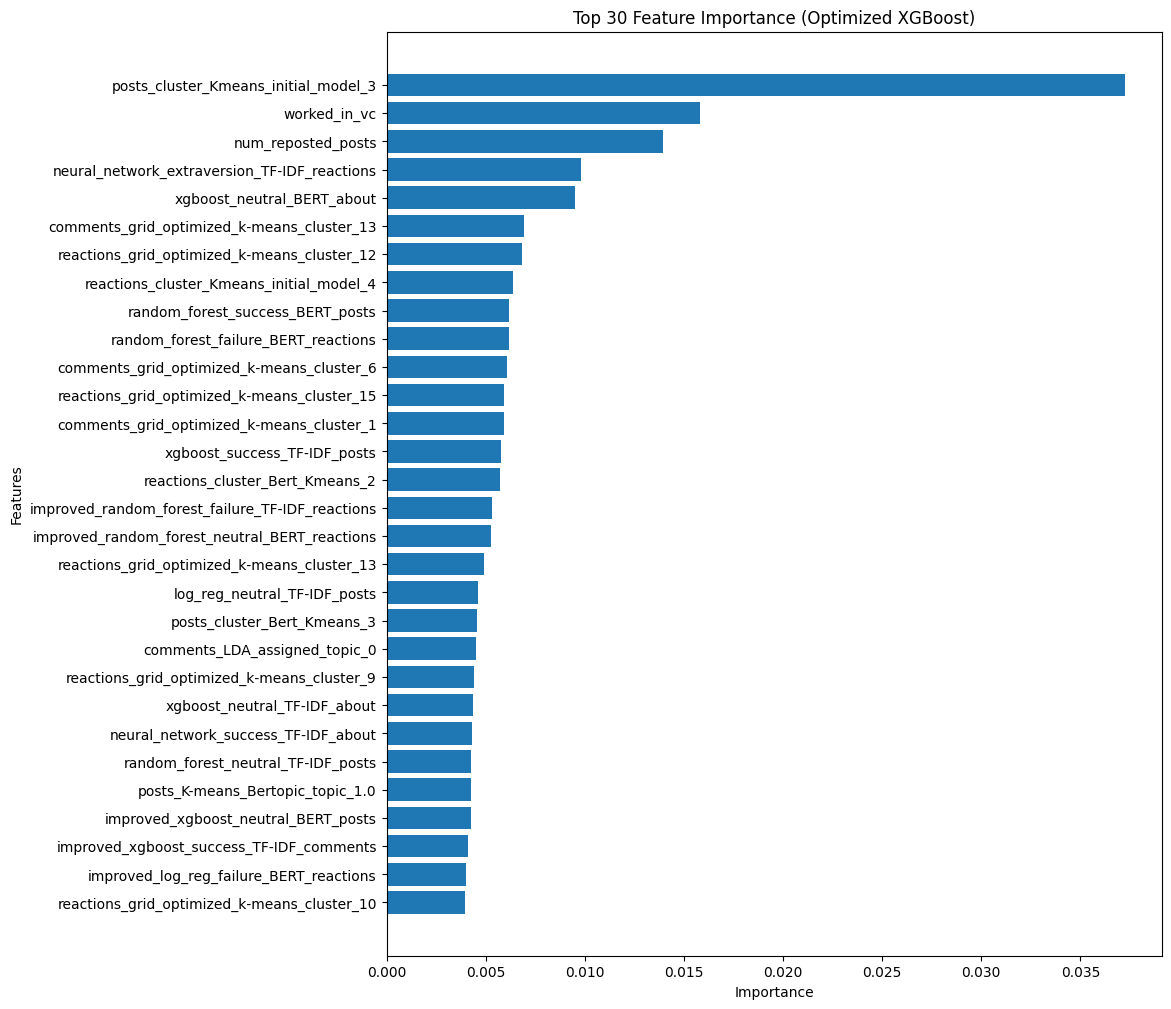

In [ ]:
# Select the top 30 features
top_30_features = feature_importance_df.head(30)

# Plot feature importance for the top 30 features
plt.figure(figsize=(10, 12))  # Adjust height for better readability
plt.barh(top_30_features['Feature'], top_30_features['Importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 30 Feature Importance (Optimized XGBoost)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.show()

#### XG Boost first laer of success prediction without followers

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:38:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Macro-Averaged Accuracy (Train): 0.997284014485256
Classification Report (Train Set):
              precision    recall  f1-score   support

          -1       1.00      0.99      0.99       300
           0       1.00      1.00      1.00      7100
           1       0.98      0.97      0.97       332

    accuracy                           1.00      7732
   macro avg       0.99      0.99      0.99      7732
weighted avg       1.00      1.00      1.00      7732

Macro-Averaged Accuracy (Test): 0.9135224871717477
Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.37      0.17      0.23       303
           0       0.93      0.99      0.96      6063
           1       0.38      0.09      0.15       260

    accuracy                           0.91      6626
   macro avg       0.56      0.42      0.45      6626
weighted avg       0.88      0.91      0.89      6626



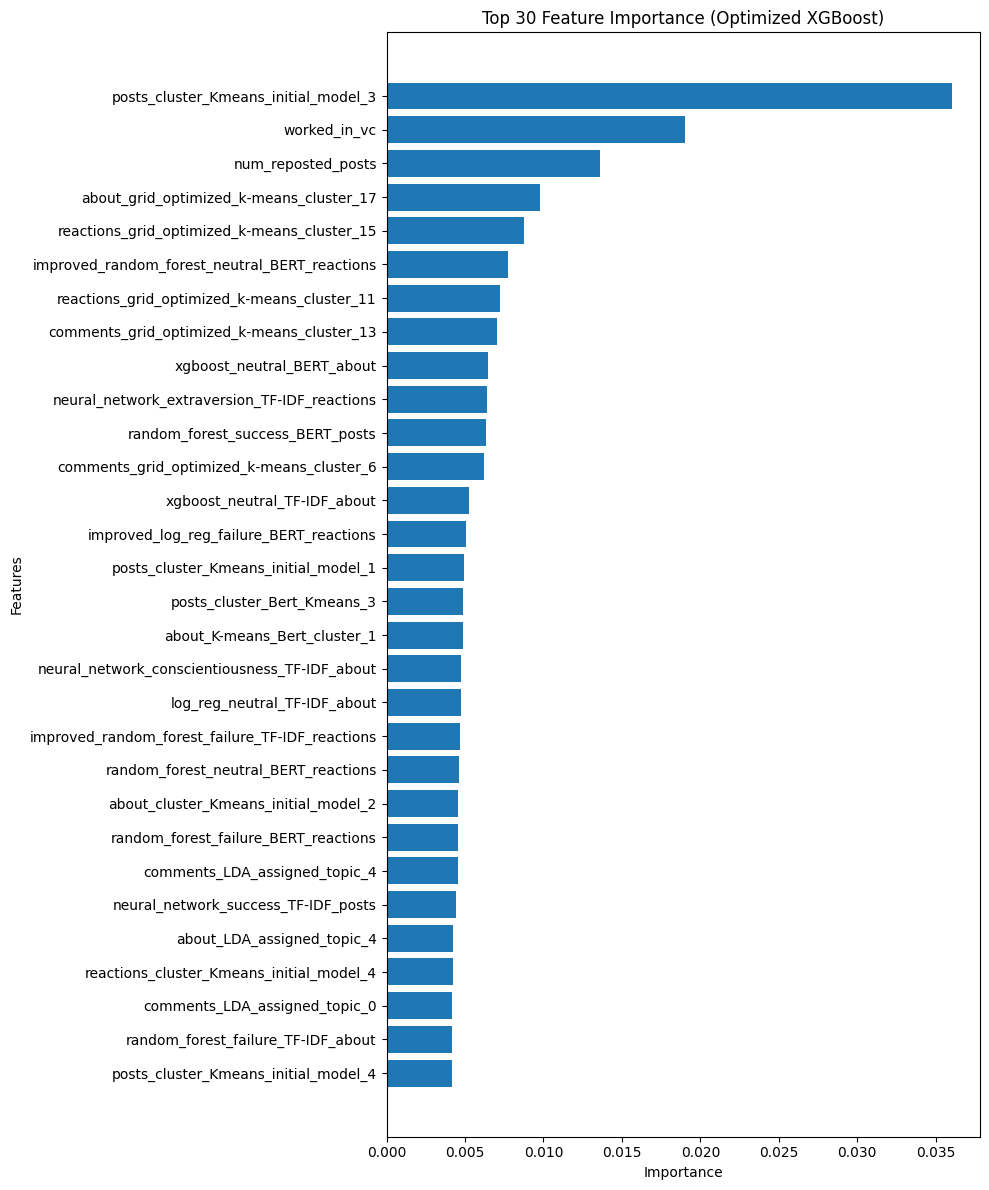

In [ ]:
# Create separate DataFrames excluding the irrelevant columns
irrelevant_columns = ['Organization Name', 'username', 'equity_rounds_raised_after_5_years',
                      'equity_raised_in_5_years', 'Success_until_now', 'followers']
X_train_data = train_data.drop(columns=irrelevant_columns + ['Success_after_5_years'])
X_test_data = test_data.drop(columns=irrelevant_columns + ['Success_after_5_years'])

y_train_data = train_data['Success_after_5_years']
y_test_data = test_data['Success_after_5_years']

# Transform target labels from -1, 0, 1 to 0, 1, 2
y_train_transformed = y_train_data + 1
y_test_transformed = y_test_data + 1

# Handle missing values natively with XGBoost (no imputation needed)
# Address imbalance using scale_pos_weight
class_counts = y_train_transformed.value_counts()
scale_pos_weights = {cls: len(y_train_transformed) / count for cls, count in class_counts.items()}

# Define XGBoost model
xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weights,
    use_label_encoder=False,
    eval_metric='mlogloss'  # Multi-class log-loss
)

# Train the model on the full training data
xgb_model.fit(X_train_data, y_train_transformed)

# Predict on train and test datasets
y_train_pred_transformed = xgb_model.predict(X_train_data)
y_test_pred_transformed = xgb_model.predict(X_test_data)

# Transform predictions back to original labels (-1, 0, 1)
y_train_pred = y_train_pred_transformed - 1
y_test_pred = y_test_pred_transformed - 1

# Evaluate performance on the training set
train_macro_accuracy = accuracy_score(y_train_data, y_train_pred)
print(f"Macro-Averaged Accuracy (Train): {train_macro_accuracy}")
print("Classification Report (Train Set):")
print(classification_report(y_train_data, y_train_pred, zero_division=0))

# Evaluate performance on the test set
test_macro_accuracy = accuracy_score(y_test_data, y_test_pred)
print(f"Macro-Averaged Accuracy (Test): {test_macro_accuracy}")
print("Classification Report (Test Set):")
print(classification_report(y_test_data, y_test_pred, zero_division=0))

# Add predictions to the original DataFrames
train_data1['Predicted_Success_after_5_years_XGB'] = y_train_pred
test_data1['Predicted_Success_after_5_years_XGB'] = y_test_pred

# Feature Importance
feature_importances = xgb_model.feature_importances_
feature_names = X_train_data.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Select the top 30 features
top_30_features = feature_importance_df.head(30)

# Plot feature importance for the top 30 features
plt.figure(figsize=(10, 12))  # Adjust height for better readability
plt.barh(top_30_features['Feature'], top_30_features['Importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 30 Feature Importance (Optimized XGBoost)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.tight_layout()
plt.show()


### XG Boost improved grid search first layer prediction model

In [ ]:
# Create separate DataFrames excluding the irrelevant columns
irrelevant_columns = ['Organization Name', 'username', 'equity_rounds_raised_after_5_years',
                      'equity_raised_in_5_years', 'Success_until_now']
X_train_data = train_data.drop(columns=irrelevant_columns + ['Success_after_5_years'])
X_test_data = test_data.drop(columns=irrelevant_columns + ['Success_after_5_years'])

y_train_data = train_data['Success_after_5_years']
y_test_data = test_data['Success_after_5_years']

# Transform target labels from -1, 0, 1 to 0, 1, 2
y_train_transformed = y_train_data + 1
y_test_transformed = y_test_data + 1

# Handle missing values natively with XGBoost (no imputation needed)
# Address imbalance using scale_pos_weight
class_counts = y_train_transformed.value_counts()
scale_pos_weights = {cls: len(y_train_transformed) / count for cls, count in class_counts.items()}

# Define initial XGBoost model
xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weights,
    use_label_encoder=False,
    eval_metric='mlogloss'  # Multi-class log-loss
)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.8, 1.0],
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='balanced_accuracy',  # Takes imbalanced dataset into account
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train_data, y_train_transformed)

# Get the best model
best_xgb_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict on train and test datasets using the optimized model
y_train_pred_transformed = best_xgb_model.predict(X_train_data)
y_test_pred_transformed = best_xgb_model.predict(X_test_data)

# Transform predictions back to original labels (-1, 0, 1)
y_train_pred = y_train_pred_transformed - 1
y_test_pred = y_test_pred_transformed - 1

# Evaluate performance on the training set
train_macro_accuracy = accuracy_score(y_train_data, y_train_pred)
print(f"Macro-Averaged Accuracy (Train): {train_macro_accuracy}")
print("Classification Report (Train Set):")
print(classification_report(y_train_data, y_train_pred, zero_division=0))

# Evaluate performance on the test set
test_macro_accuracy = accuracy_score(y_test_data, y_test_pred)
print(f"Macro-Averaged Accuracy (Test): {test_macro_accuracy}")
print("Classification Report (Test Set):")
print(classification_report(y_test_data, y_test_pred, zero_division=0))

# Add predictions to the original DataFrames
train_data1['Predicted_Success_after_5_years_XGB_optimized'] = y_train_pred
test_data1['Predicted_Success_after_5_years_XGB_optimized'] = y_test_pred


Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:05:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Macro-Averaged Accuracy (Train): 0.9776254526642525
Classification Report (Train Set):
              precision    recall  f1-score   support

          -1       1.00      0.86      0.93       300
           0       0.98      1.00      0.99      7100
           1       0.99      0.61      0.76       332

    accuracy                           0.98      7732
   macro avg       0.99      0.82      0.89      7732
weighted avg       0.98      0.98      0.98      7732

Macro-Averaged Accuracy (Test): 0.9032598853003321
Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.30      0.32      0.31       303
           0       0.94      0.97      0.96      6063
           1       0.19      0.06      0.09       260

    accuracy                           0.90      6626
   macro avg       0.48      0.45      0.45      6626


In [ ]:
# Get feature importance from the best model
feature_importance = best_xgb_model.feature_importances_

# Create a DataFrame to organize feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train_data.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df)


                                           Feature  Importance
35            posts_cluster_Kmeans_initial_model_3    0.030512
22                                    worked_in_vc    0.021277
2                               num_reposted_posts    0.014063
314  improved_random_forest_neutral_BERT_reactions    0.007380
471                     xgboost_neutral_BERT_about    0.007128
..                                             ...         ...
535      comments_grid_optimized_k-means_cluster_2    0.000000
531        comments_cluster_Kmeans_initial_model_3    0.000000
528        comments_cluster_Kmeans_initial_model_0    0.000000
527          neural_network_neuroticism_BERT_about    0.000000
236           reactions_K-means_Bertopic_topic_2.0    0.000000

[784 rows x 2 columns]


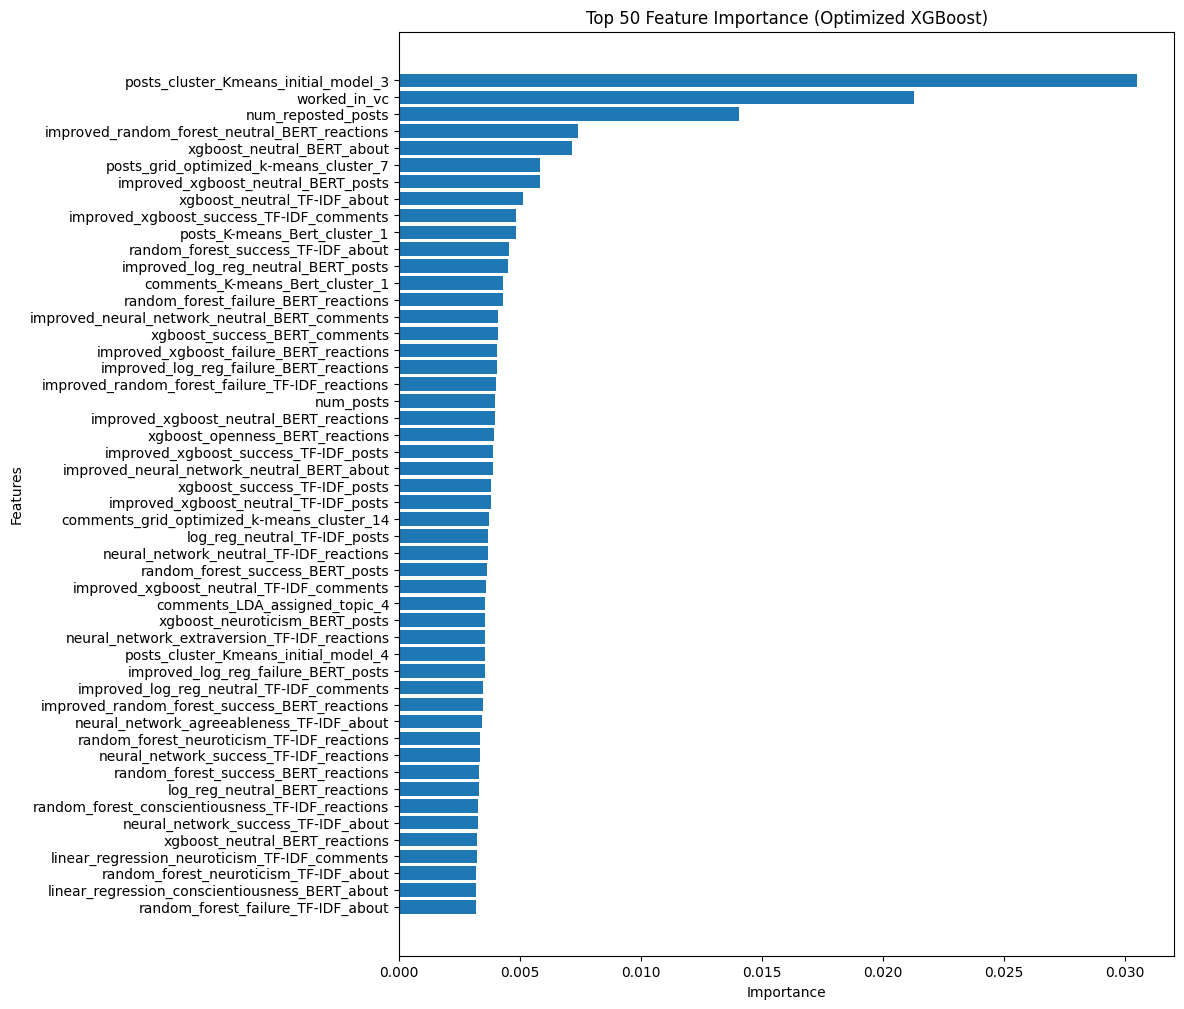

In [ ]:
# Select the top 50 features
top_50_features = feature_importance_df.head(50)

# Plot feature importance for the top 50 features
plt.figure(figsize=(10, 12))  # Adjust height for better readability
plt.barh(top_50_features['Feature'], top_50_features['Importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance (Optimized XGBoost)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.show()


### Neural Network

Summary
The combined approach of using class weights, early stopping, a balanced loss function, and validation split ensures the model effectively addresses the challenges posed by class imbalance. Class weights allow for proportional representation of all classes during training, while early stopping prevents overfitting to the majority class. The weighted loss function amplifies the importance of underrepresented classes, and the validation process ensures robust performance evaluation. This methodology is particularly suitable for scenarios where imbalanced data distributions can skew model predictions and reduce generalization.

In [ ]:
# Ensure train and test datasets have consistent columns
X_test_data = X_test_data[X_train_data.columns]

# Replace NaN with -1 (or any placeholder value)
X_train_data = X_train_data.fillna(-1)
X_test_data = X_test_data.fillna(-1)

# Convert training and testing datasets to NumPy arrays
X_train_array = X_train_data.to_numpy()
X_test_array = X_test_data.to_numpy()
y_train_array = y_train_transformed.to_numpy()
y_test_array = y_test_transformed.to_numpy()

# Calculate class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_array),
    y=y_train_array
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Reinitialize the neural network
model = Sequential([
    Input(shape=(X_train_array.shape[1],)),  # Input layer with correct shape
    Masking(mask_value=-1),                 # Mask placeholder values
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')          # Output layer for 3 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_array,
    y_train_array,
    epochs=50,
    batch_size=32,
    class_weight=class_weights,  # Address imbalance
    validation_split=0.2,
    callbacks=[early_stopping],  # Early stopping
    verbose=1
)

# Predict on train and test datasets
y_train_pred_prob = model.predict(X_train_array)
y_test_pred_prob = model.predict(X_test_array)

# Convert probabilities to class labels
y_train_pred_transformed = np.argmax(y_train_pred_prob, axis=1)
y_test_pred_transformed = np.argmax(y_test_pred_prob, axis=1)

# Transform predictions back to original labels (-1, 0, 1)
y_train_pred = y_train_pred_transformed - 1
y_test_pred = y_test_pred_transformed - 1

# Evaluate performance
train_macro_accuracy = accuracy_score(y_train_data, y_train_pred)
test_macro_accuracy = accuracy_score(y_test_data, y_test_pred)

print(f"Macro-Averaged Accuracy (Train): {train_macro_accuracy}")
print("Classification Report (Train Set):")
print(classification_report(y_train_data, y_train_pred, zero_division=0))

print(f"Macro-Averaged Accuracy (Test): {test_macro_accuracy}")
print("Classification Report (Test Set):")
print(classification_report(y_test_data, y_test_pred, zero_division=0))


Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4225 - loss: 42.7947 - val_accuracy: 0.0860 - val_loss: 13.1629
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4257 - loss: 9.8849 - val_accuracy: 0.1015 - val_loss: 4.4708
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3392 - loss: 7.8773 - val_accuracy: 0.0802 - val_loss: 3.8668
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2948 - loss: 4.8944 - val_accuracy: 0.0976 - val_loss: 2.4646
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3164 - loss: 2.5147 - val_accuracy: 0.0957 - val_loss: 1.1942
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2626 - loss: 2.3541 - val_accuracy: 0.6160 - val_loss: 0.9754
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3490 - loss: 1.5447 - val_accuracy: 0.0879 - val_loss: 1.6926
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2655 - loss: 1.8982 - val_accuracy:

### Improved Neural network takes too long

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.7 MB/s eta 0:00:00


In [ ]:
# Define the model for hyperparameter tuning
def build_model(hp):
    model = Sequential([
        Input(shape=(X_train_array.shape[1],)),  # Input layer with correct shape
        Masking(mask_value=-1),  # Mask placeholder values

        # Tune the number of units and dropout rate for the first dense layer
        Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=32), activation='relu'),
        Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)),

        # Tune the number of units and dropout rate for the second dense layer
        Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=16), activation='relu'),
        Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)),

        Dense(units=hp.Int('units_3', min_value=16, max_value=64, step=16), activation='relu'),

        # Output layer
        Dense(3, activation='softmax')  # Output for 3 classes
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Hyperparameter search using Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_array),
    y=y_train_array
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Search for the best hyperparameters
tuner.search(
    X_train_array,
    y_train_array,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights,
    verbose=1
)

# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units in the first dense layer is {best_hps.get('units_1')} with a dropout rate of {best_hps.get('dropout_1')}.
The optimal number of units in the second dense layer is {best_hps.get('units_2')} with a dropout rate of {best_hps.get('dropout_2')}.
The optimal number of units in the third dense layer is {best_hps.get('units_3')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_array,
    y_train_array,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights,
    verbose=1
)

# Predict on train and test datasets
y_train_pred_prob = best_model.predict(X_train_array)
y_test_pred_prob = best_model.predict(X_test_array)

# Convert probabilities to class labels
y_train_pred_transformed = np.argmax(y_train_pred_prob, axis=1)
y_test_pred_transformed = np.argmax(y_test_pred_prob, axis=1)

# Transform predictions back to original labels (-1, 0, 1)
y_train_pred = y_train_pred_transformed - 1
y_test_pred = y_test_pred_transformed - 1

# Evaluate performance
train_macro_accuracy = accuracy_score(y_train_data, y_train_pred)
test_macro_accuracy = accuracy_score(y_test_data, y_test_pred)

print(f"Macro-Averaged Accuracy (Train): {train_macro_accuracy}")
print("Classification Report (Train Set):")
print(classification_report(y_train_data, y_train_pred, zero_division=0))

print(f"Macro-Averaged Accuracy (Test): {test_macro_accuracy}")
print("Classification Report (Test Set):")
print(classification_report(y_test_data, y_test_pred, zero_division=0))


Trial 90 Complete [00h 00m 29s]
val_loss: 0.5318572521209717

Best val_loss So Far: 0.39912447333335876
Total elapsed time: 00h 17m 48s

The optimal number of units in the first dense layer is 128 with a dropout rate of 0.30000000000000004.
The optimal number of units in the second dense layer is 48 with a dropout rate of 0.1.
The optimal number of units in the third dense layer is 16.
The optimal learning rate for the optimizer is 0.0005.

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4790 - loss: 1.2133 - val_accuracy: 0.3988 - val_loss: 1.0829
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4564 - loss: 1.0293 - val_accuracy: 0.4538 - val_loss: 0.9821
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4781 - loss: 1.0555 - val_accuracy: 0.4932 - val_loss: 0.9432
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5047 - loss: 1.0263 - val_accuracy: 0.4428 - val_loss: 0.9580
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
print(class_weights)


## Second and thir layer of success prediction

### Randomn Forest second and third layer success prediction

Performance for equity_raised_in_5_years:
Mean Absolute Error (MAE): 53796379.0092
Mean Squared Error (MSE): 28956369715878076.0000
R-squared (R2): 0.0236
------------------------------
Performance for equity_rounds_raised_after_5_years:
Mean Absolute Error (MAE): 0.8488
Mean Squared Error (MSE): 1.3006
R-squared (R2): 0.0429
------------------------------


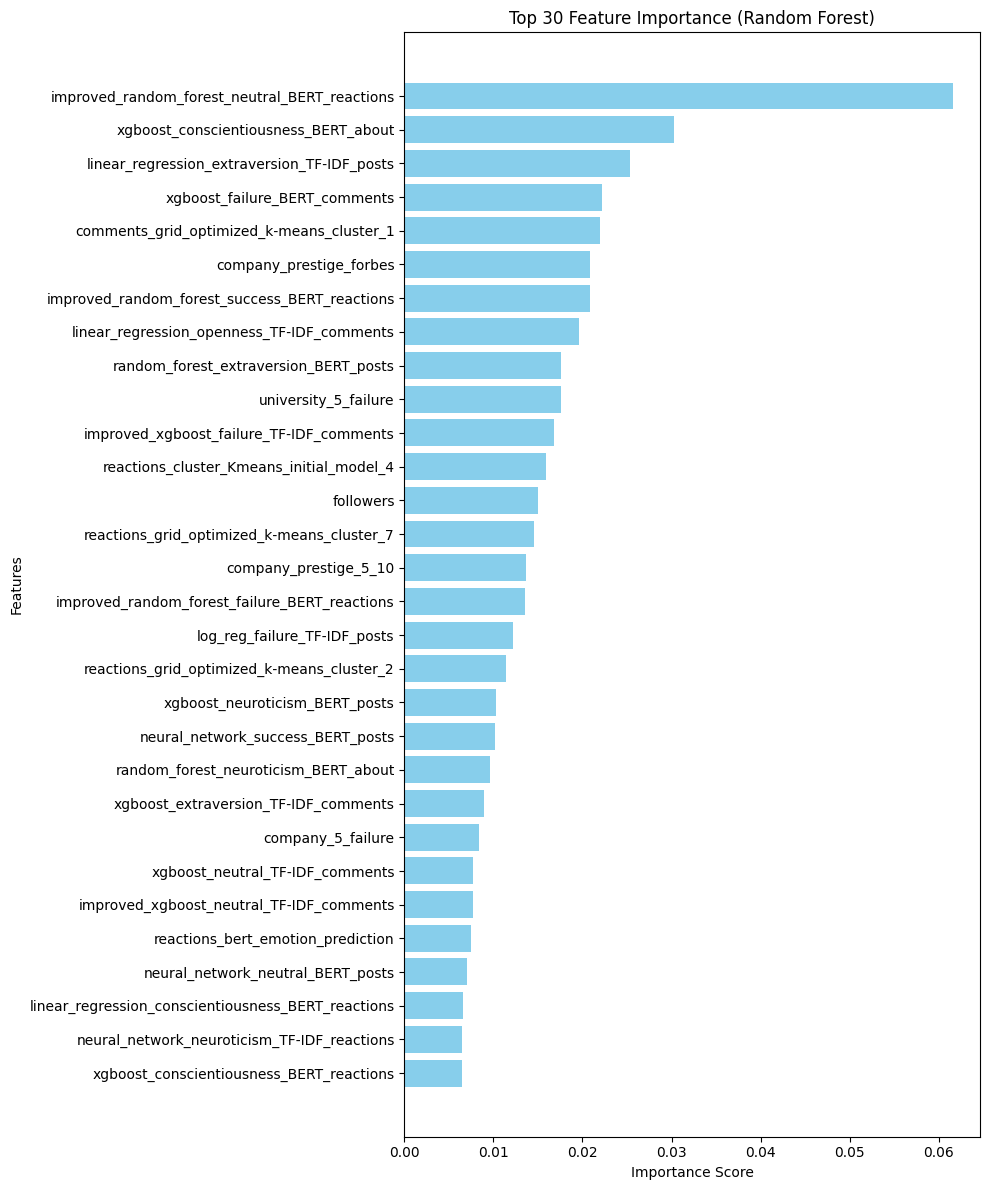

In [ ]:
# Define target variables and irrelevant columns
target_variables = ['equity_raised_in_5_years', 'equity_rounds_raised_after_5_years']
irrelevant_columns = ['Success_after_5_years', 'Organization Name', 'username', 'Success_until_now']

# Prepare the dataset
X_train_data = train_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')
X_test_data = test_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')
y_train_data = train_data[target_variables]
y_test_data = test_data[target_variables]

# Initialize a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)

# Train the model
rf_model.fit(X_train_data, y_train_data)

# Make predictions on the test set
predictions = rf_model.predict(X_test_data)

# Evaluate performance for each target variable
for i, target in enumerate(target_variables):
    print(f"Performance for {target}:")
    mae = mean_absolute_error(y_test_data[target], predictions[:, i])
    mse = mean_squared_error(y_test_data[target], predictions[:, i])
    r2 = r2_score(y_test_data[target], predictions[:, i])
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print("-" * 30)

# Add predictions to the original DataFrames
train_data1['Predicted_equity_raised_in_5_years'] = rf_model.predict(X_train_data)[:, 0]
train_data1['Predicted_equity_rounds_raised_after_5_years'] = rf_model.predict(X_train_data)[:, 1]

test_data1['Predicted_equity_raised_in_5_years'] = predictions[:, 0]
test_data1['Predicted_equity_rounds_raised_after_5_years'] = predictions[:, 1]

# Extract feature importance
feature_importances = rf_model.feature_importances_
feature_names = X_train_data.columns

# Create a DataFrame to sort and visualize importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Select the top 30 features
top_30_features = importance_df.head(30)

# Plot feature importance for the top 30 features
plt.figure(figsize=(10, 12))  # Adjust height for better readability
plt.barh(top_30_features['Feature'], top_30_features['Importance'], align='center', color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 30 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.tight_layout()  # Ensure the plot fits within the figure area
plt.show()


### Randomn Forest improved second and third layer success prediction-> randomized search because grid search takes too long

In [ ]:
# Define target variables and irrelevant columns
target_variables = ['equity_raised_in_5_years', 'equity_rounds_raised_after_5_years']
irrelevant_columns = ['Success_after_5_years', 'Organization Name', 'username', 'Success_until_now']

# Prepare the dataset
for i in tqdm(range(1), desc="Loading Data (Step 1/4)"):
    X_train_data = train_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')
    X_test_data = test_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')
    y_train_data = train_data[target_variables]
    y_test_data = test_data[target_variables]

# Define the hyperparameter distribution
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Perform RandomizedSearchCV for hyperparameter optimization
for i in tqdm(range(1), desc="Hyperparameter Tuning (Step 2/4)"):
    random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=50, cv=3,
                                       scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1, random_state=42)
    random_search.fit(X_train_data, y_train_data)

# Get the best model and parameters
for i in tqdm(range(1), desc="Model Selection (Step 3/4)"):
    best_rf_model = random_search.best_estimator_
    best_params = random_search.best_params_
    print("Best Parameters:", best_params)

# Make predictions on the test set
for i in tqdm(range(1), desc="Making Predictions (Step 4/4)"):
    predictions = best_rf_model.predict(X_test_data)

# Evaluate performance for each target variable
for i, target in enumerate(target_variables):
    print(f"Performance for {target}:")
    mae = mean_absolute_error(y_test_data[target], predictions[:, i])
    mse = mean_squared_error(y_test_data[target], predictions[:, i])
    r2 = r2_score(y_test_data[target], predictions[:, i])
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print("-" * 30)

# Add predictions to the original DataFrames
train_data['Predicted_equity_raised_in_5_years'] = best_rf_model.predict(X_train_data)[:, 0]
train_data['Predicted_equity_rounds_raised_after_5_years'] = best_rf_model.predict(X_train_data)[:, 1]

test_data['Predicted_equity_raised_in_5_years'] = predictions[:, 0]
test_data['Predicted_equity_rounds_raised_after_5_years'] = predictions[:, 1]

# Save updated datasets to CSV
train_data.to_csv('train_data_with_predictions.csv', index=False)
test_data.to_csv('test_data_with_predictions.csv', index=False)


Hyperparameter Tuning (Step 2/4):   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


Hyperparameter Tuning (Step 2/4):   0%|          | 0/1 [41:19<?, ?it/s]


KeyboardInterrupt: 

### XG Boost second and third layer success prediction

In [ ]:
# Define target variables and irrelevant columns
target_variables = ['equity_raised_in_5_years', 'equity_rounds_raised_after_5_years']
irrelevant_columns = ['Success_after_5_years', 'Organization Name', 'username', 'Success_until_now']

# Prepare the dataset
X_train_data = train_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')
X_test_data = test_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')
y_train_data = train_data[target_variables]
y_test_data = test_data[target_variables]

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(
    random_state=42,
    n_estimators=200,  # Number of trees
    learning_rate=0.05,  # Learning rate for boosting
    max_depth=6,  # Maximum tree depth
    subsample=0.8,  # Subsample ratio of training instances
    colsample_bytree=0.8  # Subsample ratio of features
)

# Train the model
xgb_model.fit(X_train_data, y_train_data)

# Make predictions on the test set
predictions = xgb_model.predict(X_test_data)

# Evaluate performance for each target variable
for i, target in enumerate(target_variables):
    print(f"Performance for {target}:")
    mae = mean_absolute_error(y_test_data[target], predictions[:, i])
    mse = mean_squared_error(y_test_data[target], predictions[:, i])
    r2 = r2_score(y_test_data[target], predictions[:, i])
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print("-" * 30)

# Add predictions to the original DataFrames
train_data1['Predicted_equity_raised_in_5_years'] = xgb_model.predict(X_train_data)[:, 0]
train_data1['Predicted_equity_rounds_raised_after_5_years'] = xgb_model.predict(X_train_data)[:, 1]

test_data1['Predicted_equity_raised_in_5_years'] = predictions[:, 0]
test_data1['Predicted_equity_rounds_raised_after_5_years'] = predictions[:, 1]


Performance for equity_raised_in_5_years:
Mean Absolute Error (MAE): 60492147.0063
Mean Squared Error (MSE): 28033310503782188.0000
R-squared (R2): 0.0547
------------------------------
Performance for equity_rounds_raised_after_5_years:
Mean Absolute Error (MAE): 646.8489
Mean Squared Error (MSE): 418414.8138
R-squared (R2): -307918.5938
------------------------------


Key Improvements
Log Transformation:

Applying np.log1p() to the target variables reduces skewness and normalizes the data, making it easier for the model to learn.
Hyperparameter Tuning:

A grid search tunes key hyperparameters like:
n_estimators: Number of boosting rounds.
learning_rate: Step size for boosting.
max_depth: Maximum depth of trees.
reg_lambda/reg_alpha: L2 and L1 regularization terms.
Cross-Validation:

Uses GridSearchCV to find the best combination of hyperparameters and prevent overfitting.
Reverse Transformation:

Applies np.expm1() to reverse the log transformation and bring predictions back to the original scale.


### XG Boost improved grid search second and third layer success prediction (takes too long)

In [ ]:
# Feature scaling for numerical stability
X_train_data = train_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')
X_test_data = test_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')
y_train_data = np.log1p(train_data[target_variables])  # Apply log transformation to target variables
y_test_data = np.log1p(test_data[target_variables])

# Initialize XGBRegressor with updated hyperparameters
xgb_model = XGBRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [1, 10, 100],
    'reg_alpha': [0, 1, 10]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_data, y_train_data)

# Best model from grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions
predictions = best_xgb_model.predict(X_test_data)
predictions = np.expm1(predictions)  # Reverse log transformation

# Evaluate performance for each target variable
for i, target in enumerate(target_variables):
    print(f"Performance for {target}:")
    mae = mean_absolute_error(test_data[target], predictions[:, i])
    mse = mean_squared_error(test_data[target], predictions[:, i])
    r2 = r2_score(test_data[target], predictions[:, i])
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print("-" * 30)


### LGBMRegressor

> does not support multi-target regressions, run seperately in the code below



Training LightGBM for target: equity_raised_in_5_years
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90841
[LightGBM] [Info] Number of data points in the train set: 7732, number of used features: 694
[LightGBM] [Info] Start training from score 36843787.870409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Performance for equity_raised_in_5_years:
Mean Absolute Error (MAE): 54282250.4008
Mean Squared Error (MSE): 27441712031206944.0000
R-squared (R2): 0.0747
------------------------------
Training LightGBM for target: equity_rounds_raised_after_5_years
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038769 seconds.
You c

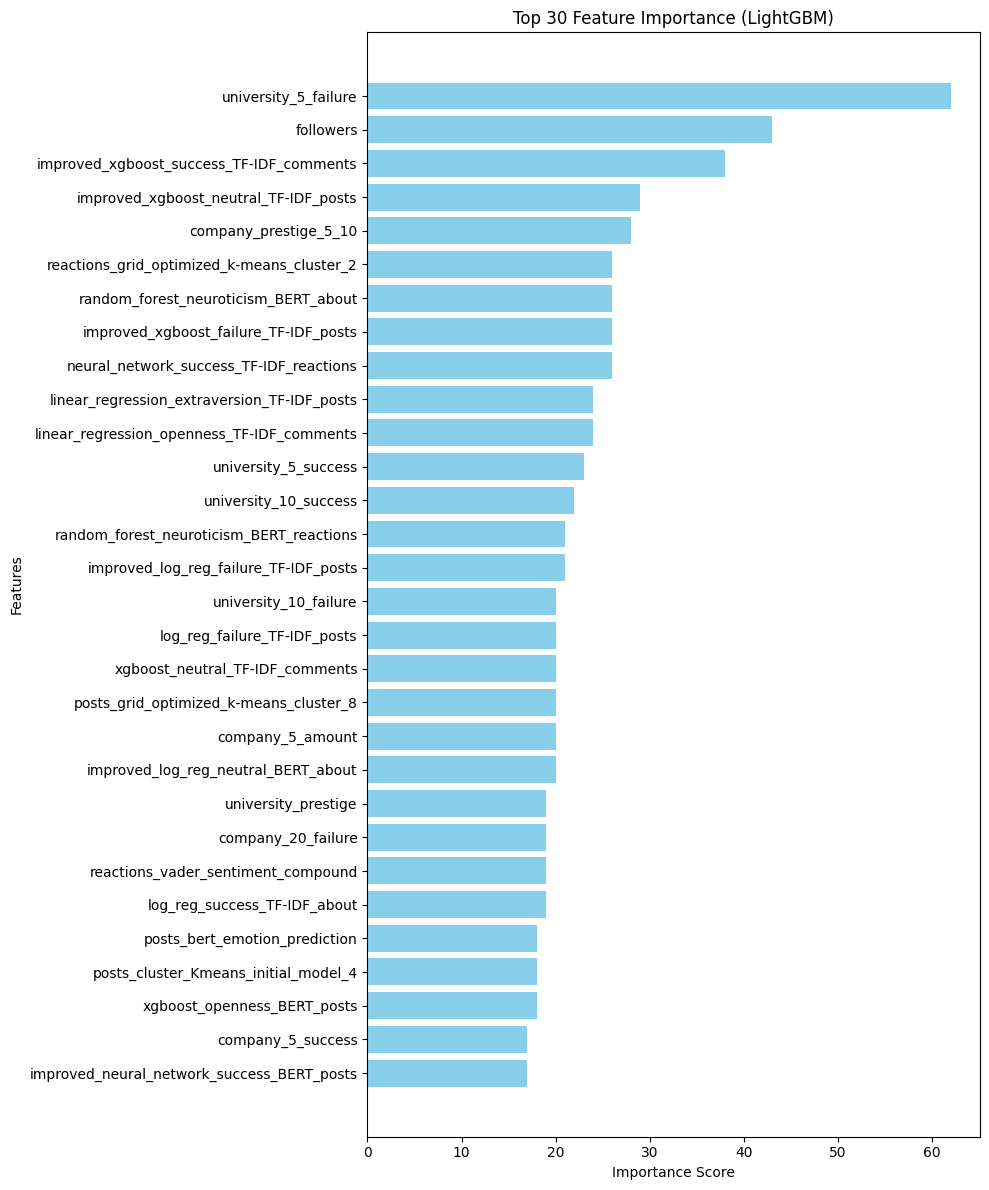

In [ ]:
# Define target variables and irrelevant columns
target_variables = ['equity_raised_in_5_years', 'equity_rounds_raised_after_5_years']
irrelevant_columns = ['Success_after_5_years', 'Organization Name', 'username', 'Success_until_now']

# Prepare the dataset
X_train_data = train_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')
X_test_data = test_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')

# Initialize dictionaries to store models and predictions
models = {}
predictions = {}

# Train a separate model for each target variable
for target in target_variables:
    print(f"Training LightGBM for target: {target}")

    # Prepare the target variable
    y_train_target = train_data[target]
    y_test_target = test_data[target]

    # Initialize LightGBM Regressor
    lgbm_model = LGBMRegressor(
        random_state=42,
        n_estimators=100,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8
    )

    # Train the model
    lgbm_model.fit(X_train_data, y_train_target)

    # Make predictions
    predictions[target] = lgbm_model.predict(X_test_data)

    # Evaluate performance
    mae = mean_absolute_error(y_test_target, predictions[target])
    mse = mean_squared_error(y_test_target, predictions[target])
    r2 = r2_score(y_test_target, predictions[target])

    print(f"Performance for {target}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print("-" * 30)

    # Store the model
    models[target] = lgbm_model

# Add predictions to the test DataFrame
for target in target_variables:
    test_data[f'Predicted_{target}'] = predictions[target]

# Feature Importance for one model (e.g., the first target)
feature_importances = models[target_variables[0]].feature_importances_
feature_names = X_train_data.columns

# Create a DataFrame to sort and visualize importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Select the top 30 features
top_30_features = importance_df.head(30)

# Plot feature importance for the top 30 features
plt.figure(figsize=(10, 12))
plt.barh(top_30_features['Feature'], top_30_features['Importance'], align='center', color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 30 Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#### LGBMRegression without Followers

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Training LightGBM for target: equity_raised_in_5_years
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90586
[LightGBM] [Info] Number of data points in the train set: 7732, number of used features: 693
[LightGBM] [Info] Start training from score 36843787.870409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Performance for equity_raised_in_5_years:
Mean Absolute Error (MAE): 54501139.1927
Mean Squared Error (MSE): 27856305520221692.0000
R-squared (R2): 0.0607
------------------------------
Training LightGBM for target: equity_rounds_raised_after_5_years
[LightGBM] [Warning] Found whitespace i

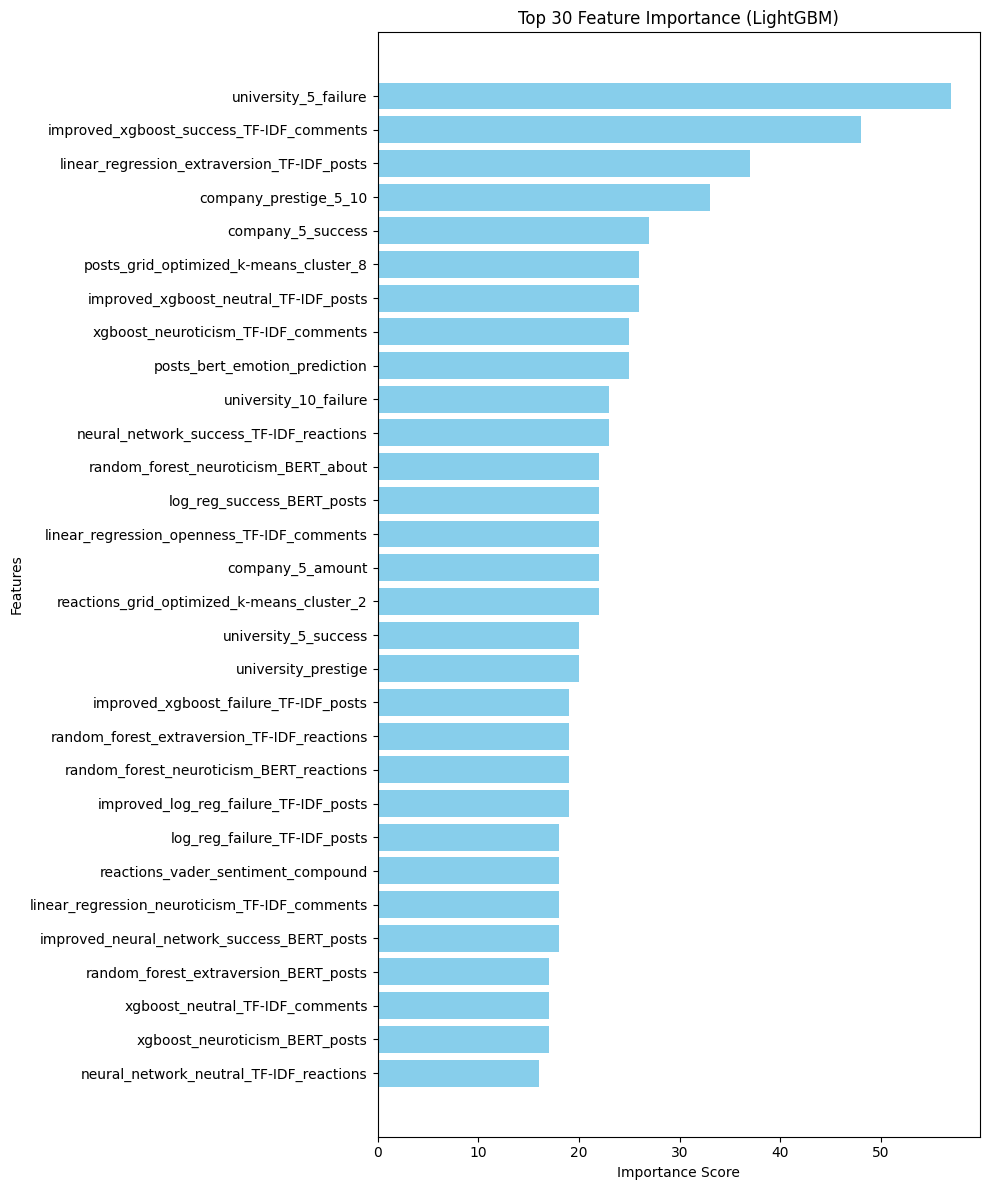

In [ ]:
# Define target variables and irrelevant columns
target_variables = ['equity_raised_in_5_years', 'equity_rounds_raised_after_5_years']
irrelevant_columns = ['Success_after_5_years', 'Organization Name', 'username', 'Success_until_now', 'followers']

# Prepare the dataset
X_train_data = train_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')
X_test_data = test_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')

# Initialize dictionaries to store models and predictions
models = {}
predictions = {}

# Train a separate model for each target variable
for target in target_variables:
    print(f"Training LightGBM for target: {target}")

    # Prepare the target variable
    y_train_target = train_data[target]
    y_test_target = test_data[target]

    # Initialize LightGBM Regressor
    lgbm_model = LGBMRegressor(
        random_state=42,
        n_estimators=100,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8
    )

    # Train the model
    lgbm_model.fit(X_train_data, y_train_target)

    # Make predictions
    predictions[target] = lgbm_model.predict(X_test_data)

    # Evaluate performance
    mae = mean_absolute_error(y_test_target, predictions[target])
    mse = mean_squared_error(y_test_target, predictions[target])
    r2 = r2_score(y_test_target, predictions[target])

    print(f"Performance for {target}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print("-" * 30)

    # Store the model
    models[target] = lgbm_model

# Add predictions to the test DataFrame
for target in target_variables:
    test_data[f'Predicted_{target}'] = predictions[target]

# Feature Importance for one model (e.g., the first target)
feature_importances = models[target_variables[0]].feature_importances_
feature_names = X_train_data.columns

# Create a DataFrame to sort and visualize importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Select the top 30 features
top_30_features = importance_df.head(30)

# Plot feature importance for the top 30 features
plt.figure(figsize=(10, 12))
plt.barh(top_30_features['Feature'], top_30_features['Importance'], align='center', color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 30 Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


The results of the predictions for the second and third layer of the three layered success definition demonstrate that the LightGBM Regressor consistently outperformed the Random Forest Regressor across most performance metrics, indicating its superior predictive capability.

For the first target variable, equity_raised_in_5_years, the LightGBM model exhibited a slight trade-off with a marginally higher Mean Absolute Error (MAE) (54,501,139.1927 compared to 53,912,355.1572 for Random Forest). However, it achieved a lower Mean Squared Error (MSE) (278,563,055,202,216.9 compared to 291,154,810,909,599.4), coupled with a notably improved R-squared (R²) value (0.0607 for LightGBM versus 0.0182 for Random Forest), suggesting that LightGBM provides better overall predictive performance despite minor differences in absolute error.

For the second target variable, equity_rounds_raised_after_5_years, LightGBM demonstrated clear superiority across all metrics. The MAE was reduced from 0.8487 (Random Forest) to 0.8291 (LightGBM), and the MSE was lowered from 1.3001 to 1.2136. Additionally, the R-squared (R²) value improved significantly from 0.0432 to 0.1069, reflecting a higher proportion of variance explained by the LightGBM model.

In conclusion, the results highlight that the LightGBM Regressor offers notable advantages over the Random Forest Regressor, particularly in terms of reducing error and improving the explanatory power of the model. These findings underscore LightGBM's effectiveness in handling large feature spaces and its suitability for tasks requiring precise predictions, making it a preferable choice for this study's regression tasks.

The results indicate that the LGBMRegressor outperforms the random baseline model across all evaluation metrics. Most notably, the R² value for the baseline model is negative, signifying that it performs worse than a simple mean-based prediction. In contrast, the LGBMRegressor achieves a positive R² of 0.0607, suggesting that it is able to explain a small portion of the variance in the target variable. The reduction in MSE by several orders of magnitude further highlights the superiority of the LGBMRegressor over the baseline. However, the relatively low R² value reveals that the model's overall predictive power remains limited, indicating that the relationship between the features and the target variable is not sufficiently captured.

### Improved LGBMRegressor takes too long

Takes too long

In [ ]:
# Define hyperparameter search space
param_distributions = {
    'n_estimators': randint(50, 500),  # Number of trees
    'learning_rate': uniform(0.01, 0.3),  # Learning rate
    'max_depth': randint(3, 15),  # Maximum depth of trees
    'num_leaves': randint(20, 100),  # Number of leaves
    'min_child_samples': randint(10, 50),  # Minimum data in leaf
    'subsample': uniform(0.6, 0.4),  # Subsample ratio
    'colsample_bytree': uniform(0.6, 0.4)  # Subsample ratio of features
}

# Initialize dictionaries to store models, predictions, and best parameters
best_models = {}
best_params = {}
predictions = {}

# Train and optimize a separate model for each target variable
for target in target_variables:
    print(f"Optimizing LightGBM for target: {target}")

    # Prepare the target variable
    y_train_target = train_data[target]
    y_test_target = test_data[target]

    # Initialize LightGBM Regressor
    lgbm_model = LGBMRegressor(random_state=42)

    # Perform RandomizedSearchCV for hyperparameter optimization
    random_search = RandomizedSearchCV(
        estimator=lgbm_model,
        param_distributions=param_distributions,
        n_iter=50,  # Number of random configurations to test
        scoring='r2',  # Optimize for R-squared
        cv=3,  # 3-fold cross-validation
        verbose=2,
        random_state=42,
        n_jobs=-1  # Use all available CPUs
    )

    # Fit the RandomizedSearchCV to the training data
    random_search.fit(X_train_data, y_train_target)

    # Get the best model and parameters
    best_models[target] = random_search.best_estimator_
    best_params[target] = random_search.best_params_
    print(f"Best Parameters for {target}: {random_search.best_params_}")

    # Make predictions using the optimized model
    predictions[target] = best_models[target].predict(X_test_data)

    # Evaluate performance
    mae = mean_absolute_error(y_test_target, predictions[target])
    mse = mean_squared_error(y_test_target, predictions[target])
    r2 = r2_score(y_test_target, predictions[target])

    print(f"Performance for {target}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print("-" * 30)

# Add optimized predictions to the test DataFrame
for target in target_variables:
    test_data[f'Optimized_Predicted_{target}'] = predictions[target]

# Print the best hyperparameters
for target in target_variables:
    print(f"Best hyperparameters for {target}: {best_params[target]}")


Optimizing LightGBM for target: equity_raised_in_5_years
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90586
[LightGBM] [Info] Number of data points in the train set: 7732, number of used features: 693
[LightGBM] [Info] Start training from score 36843787.870409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

KeyboardInterrupt: 

### Feature Segment Analysis
Run the best models with wirst educational and experience features, then a second time with additionally including the about section, then a third time with post, comments, reactions features to discover the relative importance of the feature segments.


Training XGBoost on dataset: experience_education


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:11:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Macro-Averaged Accuracy (Train): 0.9472322814278323
Classification Report (Train Set):
              precision    recall  f1-score   support

          -1       0.96      0.34      0.50       300
           0       0.95      1.00      0.97      7100
           1       1.00      0.38      0.55       332

    accuracy                           0.95      7732
   macro avg       0.97      0.57      0.67      7732
weighted avg       0.95      0.95      0.94      7732

Macro-Averaged Accuracy (Test): 0.9037126471476004
Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.09      0.01      0.02       303
           0       0.92      0.99      0.95      6063
           1       0.12      0.02      0.04       260

    accuracy                           0.90      6626
   macro avg       0.37      0.34      0.34      6626
weighted avg       0.85      0.90      0.87      6626



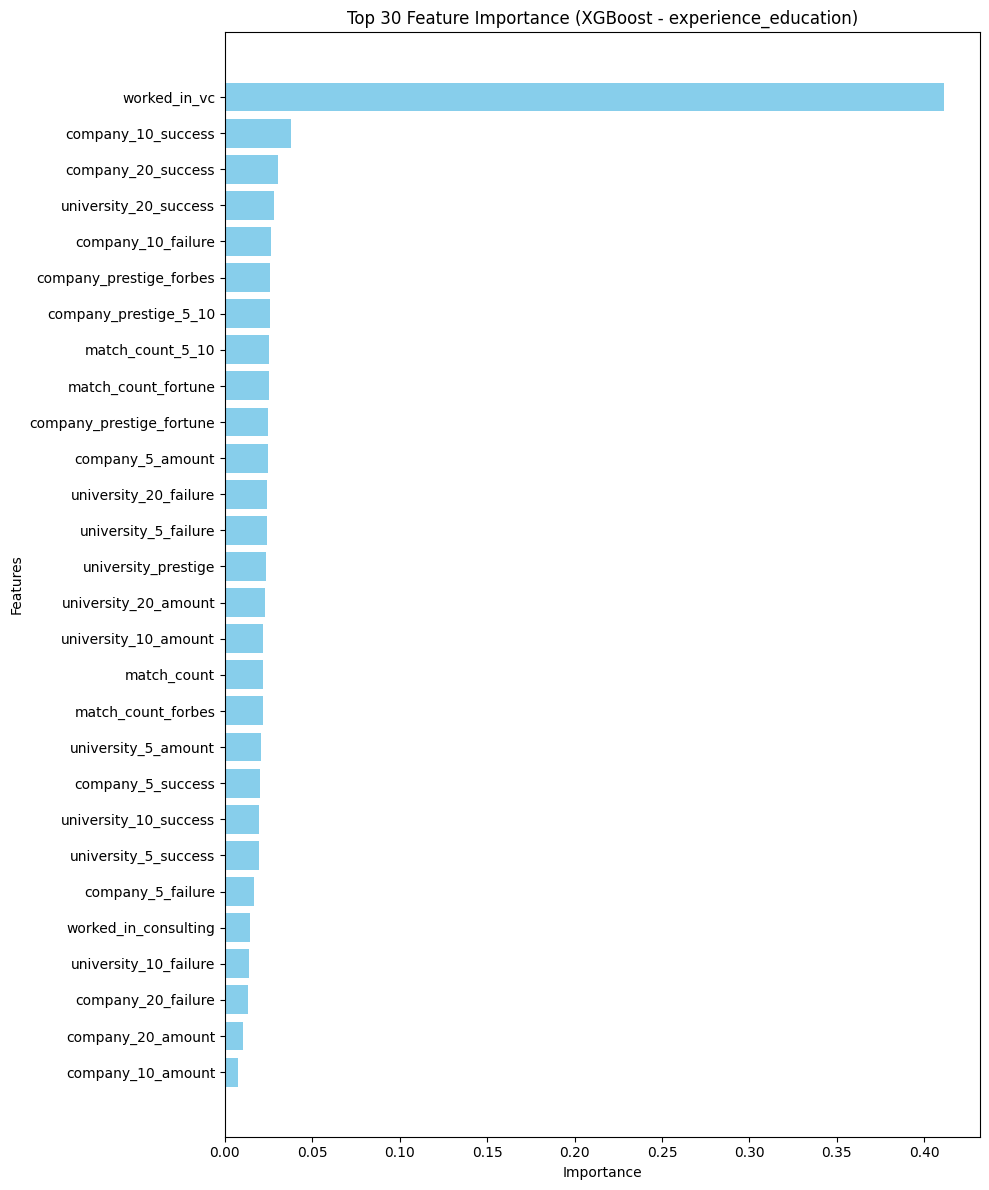


Training XGBoost on dataset: education_experience_about


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:11:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Macro-Averaged Accuracy (Train): 0.9826656394453005
Classification Report (Train Set):
              precision    recall  f1-score   support

          -1       0.97      0.85      0.90       306
           0       0.98      1.00      0.99      9680
           1       0.95      0.73      0.82       398

    accuracy                           0.98     10384
   macro avg       0.97      0.86      0.91     10384
weighted avg       0.98      0.98      0.98     10384

Macro-Averaged Accuracy (Test): 0.932609630266552
Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.35      0.03      0.05       303
           0       0.94      1.00      0.97      8699
           1       0.18      0.02      0.04       302

    accuracy                           0.93      9304
   macro avg       0.49      0.35      0.35      9304
weighted avg       0.89      0.93      0.91      9304



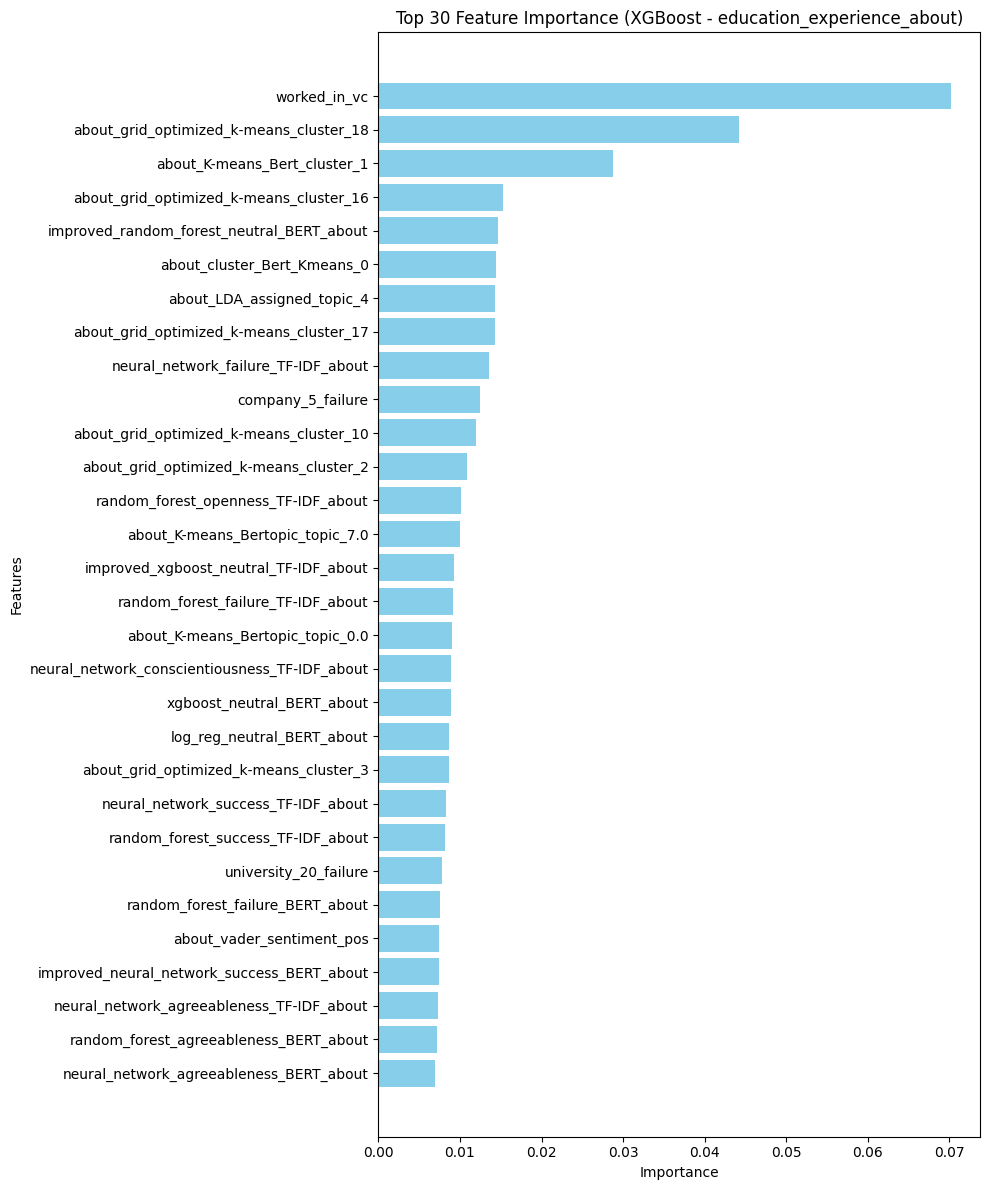


Training XGBoost on dataset: posts_reaction_comments


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:11:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Macro-Averaged Accuracy (Train): 0.9857102829924349
Classification Report (Train Set):
              precision    recall  f1-score   support

          -1       0.91      0.97      0.94       330
           0       0.99      1.00      0.99     27560
           1       0.80      0.59      0.68       662

    accuracy                           0.99     28552
   macro avg       0.90      0.85      0.87     28552
weighted avg       0.98      0.99      0.98     28552

Macro-Averaged Accuracy (Test): 0.9739062702843048
Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.08      0.02      0.03       303
           0       0.98      1.00      0.99     30039
           1       0.46      0.08      0.14       470

    accuracy                           0.97     30812
   macro avg       0.51      0.37      0.39     30812
weighted avg       0.96      0.97      0.97     30812



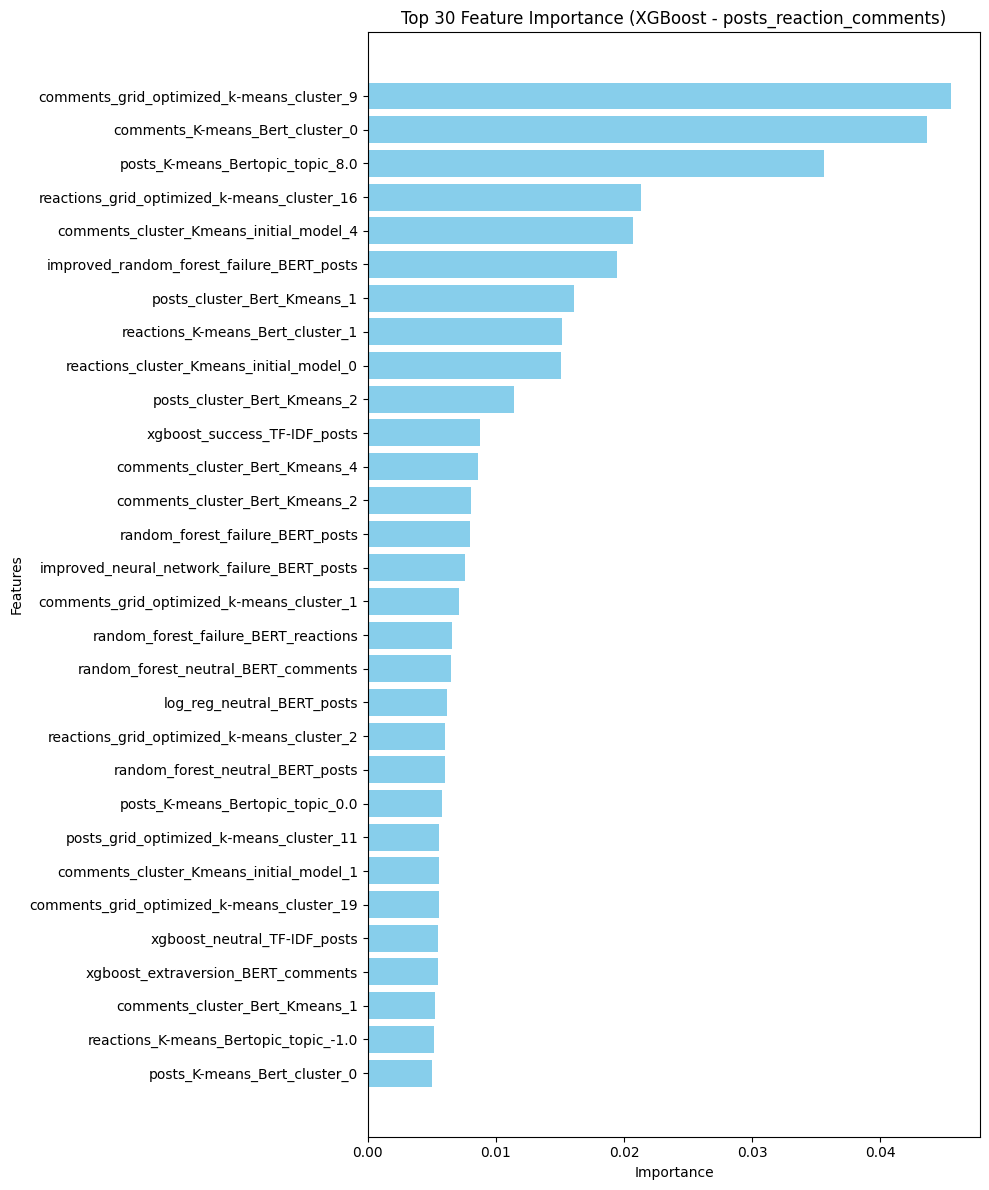

In [ ]:
# Define datasets
datasets = [
    {
        'train_data': train_data_experience_education,
        'test_data': test_data_experience_education,
        'name': 'experience_education'
    },
    {
        'train_data': education_experience_about_train,
        'test_data': education_experience_about_test,
        'name': 'education_experience_about'
    },
    {
        'train_data': posts_reaction_comments_train,
        'test_data': posts_reaction_comments_test,
        'name': 'posts_reaction_comments'
    }
]

# Define irrelevant columns
irrelevant_columns = ['username', 'equity_rounds_raised_after_5_years', 'equity_raised_in_5_years']

# Loop through each dataset
for dataset in datasets:
    print(f"\nTraining XGBoost on dataset: {dataset['name']}")

    train_data = dataset['train_data']
    test_data = dataset['test_data']

    # Prepare training and testing data
    X_train_data = train_data.drop(columns=irrelevant_columns + ['Success_after_5_years'], errors='ignore')
    X_test_data = test_data.drop(columns=irrelevant_columns + ['Success_after_5_years'], errors='ignore')

    y_train_data = train_data['Success_after_5_years']
    y_test_data = test_data['Success_after_5_years']

    # Transform target labels from -1, 0, 1 to 0, 1, 2
    y_train_transformed = y_train_data + 1
    y_test_transformed = y_test_data + 1

    # Address imbalance using scale_pos_weight
    class_counts = y_train_transformed.value_counts()
    scale_pos_weights = {cls: len(y_train_transformed) / count for cls, count in class_counts.items()}

    # Define XGBoost model
    xgb_model = XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weights,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    # Train the model
    xgb_model.fit(X_train_data, y_train_transformed)

    # Predict on train and test datasets
    y_train_pred_transformed = xgb_model.predict(X_train_data)
    y_test_pred_transformed = xgb_model.predict(X_test_data)

    # Transform predictions back to original labels (-1, 0, 1)
    y_train_pred = y_train_pred_transformed - 1
    y_test_pred = y_test_pred_transformed - 1

    # Evaluate performance on the training set
    train_macro_accuracy = accuracy_score(y_train_data, y_train_pred)
    print(f"Macro-Averaged Accuracy (Train): {train_macro_accuracy}")
    print("Classification Report (Train Set):")
    print(classification_report(y_train_data, y_train_pred, zero_division=0))

    # Evaluate performance on the test set
    test_macro_accuracy = accuracy_score(y_test_data, y_test_pred)
    print(f"Macro-Averaged Accuracy (Test): {test_macro_accuracy}")
    print("Classification Report (Test Set):")
    print(classification_report(y_test_data, y_test_pred, zero_division=0))

    # Add predictions to the original DataFrames
    train_data[f'Predicted_Success_after_5_years_XGB_{dataset["name"]}'] = y_train_pred
    test_data[f'Predicted_Success_after_5_years_XGB_{dataset["name"]}'] = y_test_pred

    # Save updated datasets (optional)
    train_data.to_csv(f'train_data_{dataset["name"]}_with_predictions.csv', index=False)
    test_data.to_csv(f'test_data_{dataset["name"]}_with_predictions.csv', index=False)

    # Extract and visualize feature importance
    feature_importances = xgb_model.feature_importances_
    feature_names = X_train_data.columns

    # Create a DataFrame to store feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Select the top 30 features
    top_30_features = feature_importance_df.head(30)

    # Plot feature importance for the top 30 features
    plt.figure(figsize=(10, 12))  # Adjust height for better readability
    plt.barh(top_30_features['Feature'], top_30_features['Importance'], align='center', color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'Top 30 Feature Importance (XGBoost - {dataset["name"]})')
    plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
    plt.tight_layout()
    plt.show()


In [ ]:
# Define datasets
datasets = [
    {
        'train_data': train_data_experience_education,
        'test_data': test_data_experience_education,
        'name': 'experience_education'
    },
    {
        'train_data': education_experience_about_train,
        'test_data': education_experience_about_test,
        'name': 'education_experience_about'
    },
    {
        'train_data': posts_reaction_comments_train,
        'test_data': posts_reaction_comments_test,
        'name': 'posts_reaction_comments'
    }
]

# Define irrelevant columns
irrelevant_columns = ['username', 'equity_rounds_raised_after_5_years', 'equity_raised_in_5_years']

# Loop through each dataset
for dataset in datasets:
    print(f"\nTraining XGBoost on dataset: {dataset['name']}")

    train_data = dataset['train_data']
    test_data = dataset['test_data']

    # Prepare training and testing data
    X_train_data = train_data.drop(columns=irrelevant_columns + ['Success_after_5_years'], errors='ignore')
    X_test_data = test_data.drop(columns=irrelevant_columns + ['Success_after_5_years'], errors='ignore')

    y_train_data = train_data['Success_after_5_years']
    y_test_data = test_data['Success_after_5_years']

    # Transform target labels from -1, 0, 1 to 0, 1, 2
    y_train_transformed = y_train_data + 1
    y_test_transformed = y_test_data + 1

    # Address imbalance using scale_pos_weight
    class_counts = y_train_transformed.value_counts()
    scale_pos_weights = {cls: len(y_train_transformed) / count for cls, count in class_counts.items()}

    # Define XGBoost model
    xgb_model = XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weights,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    # Train the model
    xgb_model.fit(X_train_data, y_train_transformed)

    # Predict on train and test datasets
    y_train_pred_transformed = xgb_model.predict(X_train_data)
    y_test_pred_transformed = xgb_model.predict(X_test_data)

    # Transform predictions back to original labels (-1, 0, 1)
    y_train_pred = y_train_pred_transformed - 1
    y_test_pred = y_test_pred_transformed - 1

    # Evaluate performance on the training set
    train_macro_accuracy = accuracy_score(y_train_data, y_train_pred)
    print(f"Macro-Averaged Accuracy (Train): {train_macro_accuracy}")
    print("Classification Report (Train Set):")
    print(classification_report(y_train_data, y_train_pred, zero_division=0))

    # Evaluate performance on the test set
    test_macro_accuracy = accuracy_score(y_test_data, y_test_pred)
    print(f"Macro-Averaged Accuracy (Test): {test_macro_accuracy}")
    print("Classification Report (Test Set):")
    print(classification_report(y_test_data, y_test_pred, zero_division=0))

    # Add predictions to the original DataFrames
    train_data1[f'Predicted_Success_after_5_years_XGB_{dataset["name"]}'] = y_train_pred
    test_data1[f'Predicted_Success_after_5_years_XGB_{dataset["name"]}'] = y_test_pred

    # Save updated datasets (optional)
    train_data.to_csv(f'train_data_{dataset["name"]}_with_predictions.csv', index=False)
    test_data.to_csv(f'test_data_{dataset["name"]}_with_predictions.csv', index=False)



Training XGBoost on dataset: experience_education


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Macro-Averaged Accuracy (Train): 0.9472322814278323
Classification Report (Train Set):
              precision    recall  f1-score   support

          -1       0.96      0.34      0.50       300
           0       0.95      1.00      0.97      7100
           1       1.00      0.38      0.55       332

    accuracy                           0.95      7732
   macro avg       0.97      0.57      0.67      7732
weighted avg       0.95      0.95      0.94      7732

Macro-Averaged Accuracy (Test): 0.9037126471476004
Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.09      0.01      0.02       303
           0       0.92      0.99      0.95      6063
           1       0.12      0.02      0.04       260

    accuracy                           0.90      6626
   macro avg       0.37      0.34      0.34      6626
weighted avg       0.85      0.90      0.87      6626


Training XGBoost on dataset: education_experience_about


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:33:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Macro-Averaged Accuracy (Train): 0.9826656394453005
Classification Report (Train Set):
              precision    recall  f1-score   support

          -1       0.97      0.85      0.90       306
           0       0.98      1.00      0.99      9680
           1       0.95      0.73      0.82       398

    accuracy                           0.98     10384
   macro avg       0.97      0.86      0.91     10384
weighted avg       0.98      0.98      0.98     10384

Macro-Averaged Accuracy (Test): 0.932609630266552
Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.35      0.03      0.05       303
           0       0.94      1.00      0.97      8699
           1       0.18      0.02      0.04       302

    accuracy                           0.93      9304
   macro avg       0.49      0.35      0.35      9304
weighted avg       0.89      0.93      0.91      9304


Training XGBoost on dataset: posts_reaction_comments


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:33:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Macro-Averaged Accuracy (Train): 0.9857102829924349
Classification Report (Train Set):
              precision    recall  f1-score   support

          -1       0.91      0.97      0.94       330
           0       0.99      1.00      0.99     27560
           1       0.80      0.59      0.68       662

    accuracy                           0.99     28552
   macro avg       0.90      0.85      0.87     28552
weighted avg       0.98      0.99      0.98     28552

Macro-Averaged Accuracy (Test): 0.9739062702843048
Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.08      0.02      0.03       303
           0       0.98      1.00      0.99     30039
           1       0.46      0.08      0.14       470

    accuracy                           0.97     30812
   macro avg       0.51      0.37      0.39     30812
weighted avg       0.96      0.97      0.97     30812




Running LightGBM on dataset: experience_education
Training LightGBM for target: equity_raised_in_5_years
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3346
[LightGBM] [Info] Number of data points in the train set: 7732, number of used features: 29
[LightGBM] [Info] Start training from score 36843787.870409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

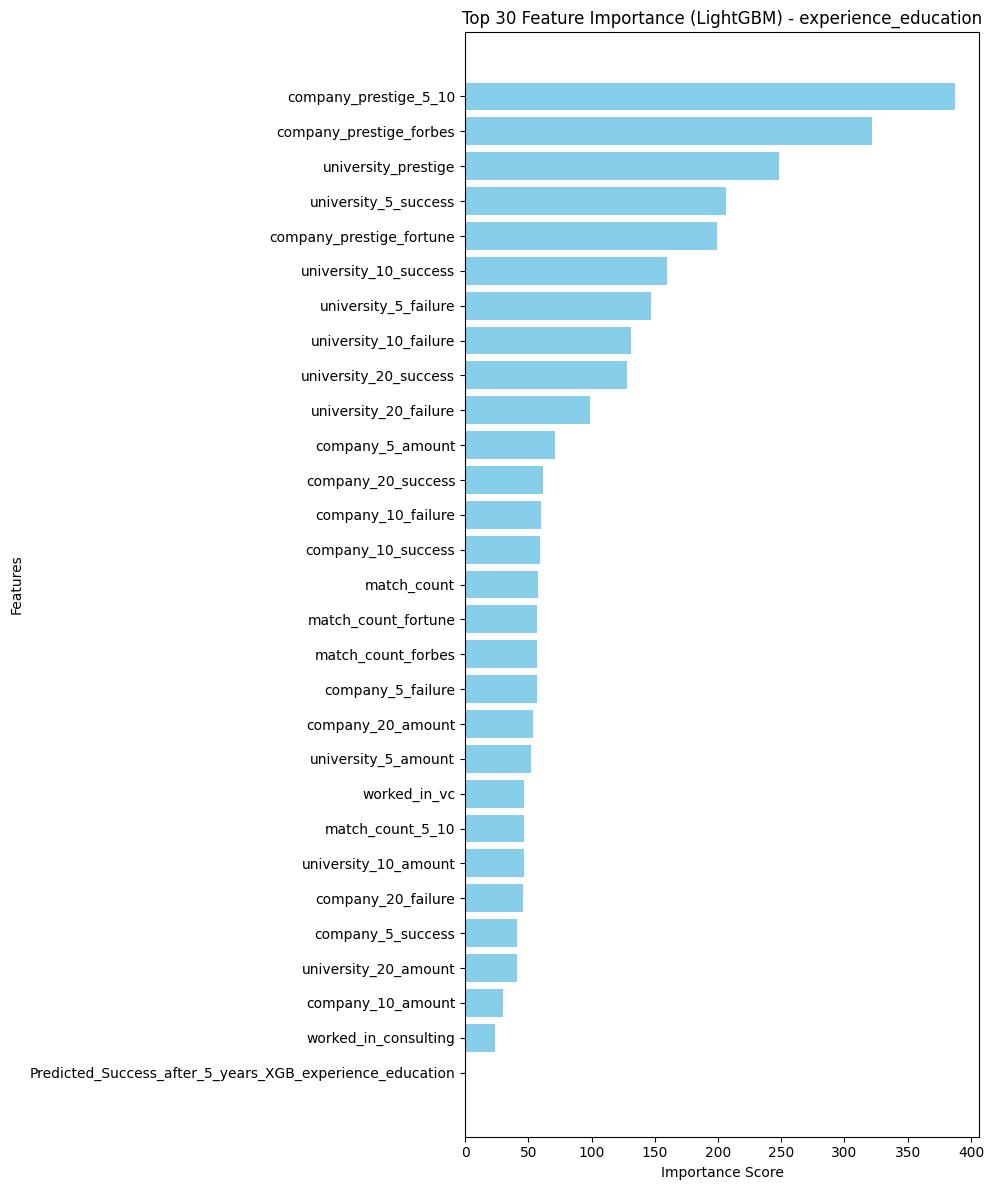


Running LightGBM on dataset: education_experience_about
Training LightGBM for target: equity_raised_in_5_years
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24385
[LightGBM] [Info] Number of data points in the train set: 10384, number of used features: 195
[LightGBM] [Info] Start training from score 34459506.419106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Performance for equity_raised_in_5_years:
Mean Absolute Error (MAE): 57556339.3943
Mean Squared Error (MSE): 26354295634552284.0000
R-squared (R2): 0.0141
------------------------------
Training LightGBM for target: equity_rounds_raised_after_5_years
[LightGBM] [Warning] Found whitespace in feature_names, 

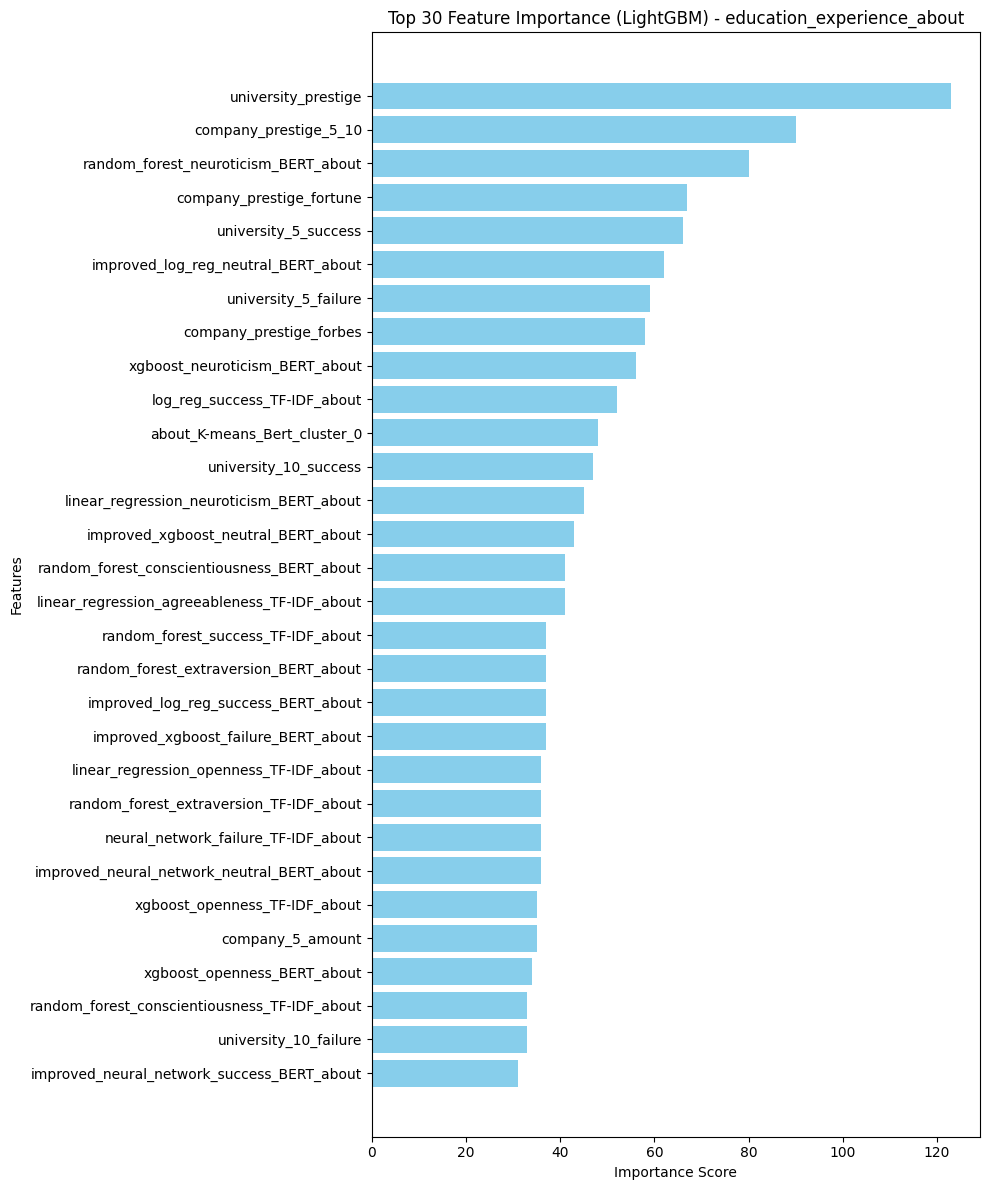


Running LightGBM on dataset: posts_reaction_comments
Training LightGBM for target: equity_raised_in_5_years
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65434
[LightGBM] [Info] Number of data points in the train set: 28552, number of used features: 500
[LightGBM] [Info] Start training from score 24468601.537686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

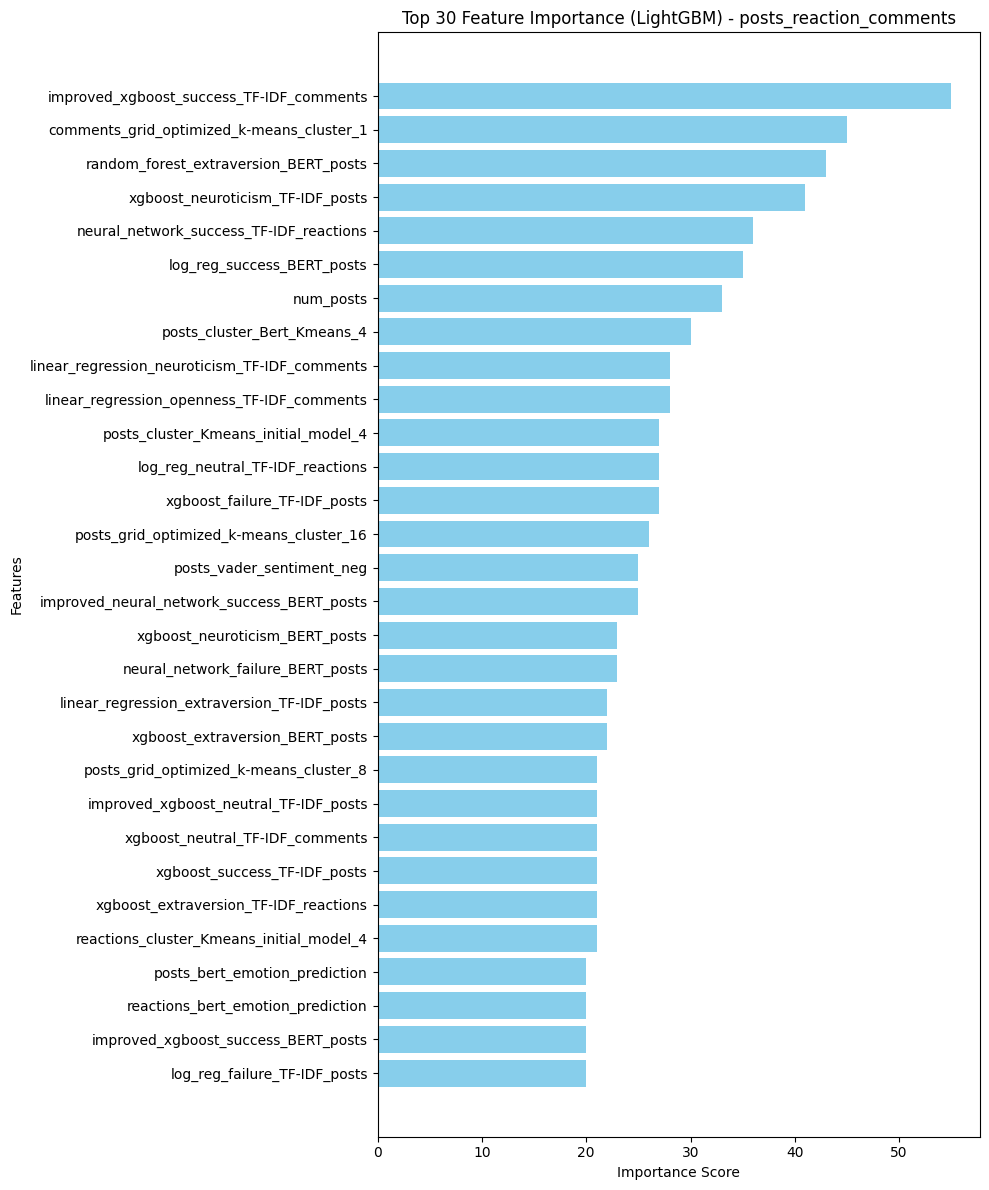

In [ ]:
# Define datasets
datasets = [
    {
        'train_data': train_data_experience_education,
        'test_data': test_data_experience_education,
        'name': 'experience_education'
    },
    {
        'train_data': education_experience_about_train,
        'test_data': education_experience_about_test,
        'name': 'education_experience_about'
    },
    {
        'train_data': posts_reaction_comments_train,
        'test_data': posts_reaction_comments_test,
        'name': 'posts_reaction_comments'
    }
]

# Define target variables and irrelevant columns
target_variables = ['equity_raised_in_5_years', 'equity_rounds_raised_after_5_years']
irrelevant_columns = ['username', 'Success_after_5_years']

# Loop through each dataset
for dataset in datasets:
    print(f"\nRunning LightGBM on dataset: {dataset['name']}")

    # Extract train and test data
    train_data = dataset['train_data']
    test_data = dataset['test_data']

    # Prepare training and testing data
    X_train_data = train_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')
    X_test_data = test_data.drop(columns=irrelevant_columns + target_variables, errors='ignore')

    # Initialize dictionaries to store models and predictions
    models = {}
    predictions = {}

    # Train a separate model for each target variable
    for target in target_variables:
        print(f"Training LightGBM for target: {target}")

        # Prepare the target variable
        y_train_target = train_data[target]
        y_test_target = test_data[target]

        # Initialize LightGBM Regressor
        lgbm_model = LGBMRegressor(
            random_state=42,
            n_estimators=100,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8
        )

        # Train the model
        lgbm_model.fit(X_train_data, y_train_target)

        # Make predictions
        predictions[target] = lgbm_model.predict(X_test_data)

        # Evaluate performance
        mae = mean_absolute_error(y_test_target, predictions[target])
        mse = mean_squared_error(y_test_target, predictions[target])
        r2 = r2_score(y_test_target, predictions[target])

        print(f"Performance for {target}:")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"R-squared (R2): {r2:.4f}")
        print("-" * 30)

        # Store the model
        models[target] = lgbm_model

    # Add predictions to the test DataFrame
    for target in target_variables:
        test_data[f'Predicted_{target}_{dataset["name"]}'] = predictions[target]

    # Feature Importance for one model (e.g., the first target)
    feature_importances = models[target_variables[0]].feature_importances_
    feature_names = X_train_data.columns

    # Create a DataFrame to sort and visualize importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Select the top 30 features
    top_30_features = importance_df.head(30)

    # Plot feature importance for the top 30 features
    plt.figure(figsize=(10, 12))
    plt.barh(top_30_features['Feature'], top_30_features['Importance'], align='center', color='skyblue')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title(f'Top 30 Feature Importance (LightGBM) - {dataset["name"]}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Optional: Save updated test data with predictions
    test_data.to_csv(f'test_data_with_predictions_{dataset["name"]}.csv', index=False)
